# Packages and Functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns

pd.set_option('display.max_columns', None)

In [2]:
def adjust_data_types(df):
    for col in df.columns:
        unique_vals = df[col].unique()
        if df[col].dtypes == 'object':
            None
#         elif (set(unique_vals) == {0, 1}) or col == 'userId':
#             df[col] = df[col].astype('int64')
#         else:
#             df[col] = df[col].astype('float64')
        elif (set(unique_vals) != {0, 1}):
            df[col] = df[col].astype('float64')
        else:
            df[col] = df[col].astype('int64')
    return df

In [3]:
# ho_t02['userId'] = ho_t02['userId'].astype('str')
# ho_t02 = adjust_data_types(ho_t02)
# ho_t02.info()

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier

from sklearn.feature_selection import RFE, RFECV, VarianceThreshold

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, make_scorer, confusion_matrix, roc_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold, permutation_test_score
from sklearn.base import clone


from imblearn.metrics import geometric_mean_score
import shap

from imblearn.over_sampling import SMOTE, ADASYN, SMOTENC, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from imblearn.pipeline import Pipeline
# from sklearn.pipeline import Pipeline

import dice_ml

from catboost import CatBoostClassifier

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
UserConfigValidationException will be deprecated from dice_ml.utils. Please import UserConfigValidationException from raiutils.exceptions.


In [5]:
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return specificity

specificity_scorer = make_scorer(specificity_score)

def npv_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    npv = tn / (tn + fn)
    return npv

npv_scorer = make_scorer(npv_score)

g_mean_scorer = make_scorer(geometric_mean_score)


skf = StratifiedKFold(10, shuffle=True, random_state=0)

# def get_cat_cols(df):
#     one_hot_encoded_columns = []

#     for idx, column in enumerate(df.columns):
#         if df[column].nunique() == 2 and set(df[column].unique()) == {0, 1}:
#             one_hot_encoded_columns.append(idx)

#     return one_hot_encoded_columns

def get_cat_cols(df):
    return df.select_dtypes(include=['object']).columns.tolist()

# get_cat_cols(ho_t02)
# cat_cols = get_cat_cols(ho_t02)
# num_cols = [col for col in ho_t02.columns if col not in cat_cols]
# cat_cols, num_cols

In [6]:
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE, ADASYN, SMOTENC, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours, TomekLinks
from imblearn.combine import SMOTEENN, SMOTETomek


from sklearn.base import BaseEstimator, TransformerMixin

class DropCategoricalFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Assuming X is a DataFrame
        non_categorical_cols = X.select_dtypes(exclude=['object']).columns.tolist()
        return X[non_categorical_cols]


def knn_class2(df, scorer, label_col, scaler, random_state=0):
    X = df.drop(['userId', 'lastFirstName', label_col], axis=1)
    y = df.loc[:, label_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.25,
                                                        stratify=y,
                                                        random_state=random_state)

    pipeline = Pipeline([
        ('scaler', scaler),
        ('resampling', None),
        ('classifier', KNeighborsClassifier())
    ])

    param_grid = {
#         'scaler': [StandardScaler(),
#                    MinMaxScaler(),
#                    RobustScaler()
#                   ],
#         'resampling': [SMOTE(random_state=random_state),
#                        SMOTENC(categorical_features=get_cat_cols(X),
#                                random_state=random_state),
#                        ADASYN(random_state=random_state),
# #                        RandomOverSampler(random_state=random_state),
#                        RandomUnderSampler(random_state=random_state)],
#         'scaler': [RobustScaler(),
#                    PowerTransformer()],
#         'resampling': [SMOTENC(categorical_features=get_cat_cols(X),
#                                random_state=random_state),
        'resampling': [
            SMOTE(random_state=random_state),
            ADASYN(random_state=random_state),
#             SMOTEENN(random_state=random_state),
#             SMOTETomek(random_state=random_state),
            EditedNearestNeighbours(),
#             TomekLinks(),
            RandomOverSampler(random_state=random_state),
            RandomUnderSampler(random_state=random_state)
        ],
        'classifier__n_neighbors': list(range(1, 16)),
        'classifier__metric': ['euclidean', 'cosine', 'hamming', 'braycurtis',
                               'chebyshev', 'canberra', 'cityblock', 'sqeuclidean'
                              ]
    }

    start_time_cv = time.time()
    grid_search = GridSearchCV(pipeline, param_grid,
                               cv=skf, scoring=scorer,
                               n_jobs=-1,
                               verbose=4, return_train_score=True)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_estimator = grid_search.best_estimator_
    cv_results = grid_search.cv_results_
    end_time_cv = time.time()

    print("Best Hyperparameters:", best_params)
    print("Best Validation Score (Precision):", best_score)
    print('Best Estimator:', best_estimator)
    print('Mean Train Score (Precision)', np.mean(cv_results['mean_train_score']))
    print('Std Train Score (Precision)', np.mean(cv_results['std_train_score']))
    elapsed_time_cv = (end_time_cv - start_time_cv)
    print(f'GridSearchCV Runtime: {elapsed_time_cv} secs')

    num_runs = 5
    metrics_per_run = []

    for run in range(num_runs):
        modified_random_state = random_state + run

        start_time = time.time()
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.25,
                                                            stratify=y,
                                                            random_state=modified_random_state)

        modified_estimator = clone(best_estimator)
#         if not (isinstance(best_estimator.named_steps['resampling'], EditedNearestNeighbours) or
#             isinstance(best_estimator.named_steps['resampling'], TomekLinks)):
#             modified_estimator.named_steps['resampling'].set_params(random_state=modified_random_state)
#         modified_estimator.named_steps['classifier'].set_params(random_state=modified_random_state)
        modified_estimator.fit(X_train, y_train)

        y_pred = modified_estimator.predict(X_test)

        end_time = time.time()
        elapsed_time = (end_time - start_time)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        specificity = specificity_score(y_test, y_pred)
        npv = npv_score(y_test, y_pred)
        g_mean = geometric_mean_score(y_test, y_pred)

        print(f"Run {run + 1} - Random State: {modified_random_state}")
        print(f"Test Precision: {precision}")

#         y_hat = modified_estimator.predict_proba(X_test)[:, 1]

#         fpr, tpr, thresholds = roc_curve(y_test, y_hat)
#         gmeans = np.sqrt(tpr * (1-fpr))
#         ix = np.argmax(gmeans)
#         print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

#         plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
#         plt.plot(fpr, tpr, marker='.', label='Original')
#         plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.legend()

#         plt.show()

        metrics_per_run.append({
            'Random State': modified_random_state,
            'Test Accuracy': accuracy,
            'Test Precision': precision,
            'Test Recall': recall,
            'Test F1 Score': f1,
            'Test Specificity': specificity,
            'Test G-mean': g_mean,
            'Test NPV': npv,
            'Runtime': elapsed_time
        })

    metrics_df = pd.DataFrame(metrics_per_run)

    avg_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print('Ave Test Precision:', avg_metrics['Test Precision'])
    print('Stdev Test Precision:', std_metrics['Test Precision'])
    print("Ave Test Accuracy:", avg_metrics['Test Accuracy'])
    print('Stdev Test Accuracy:', std_metrics['Test Accuracy'])
    print("Ave Test Specificity:", avg_metrics['Test Specificity'])
    print("Ave Test Recall:", avg_metrics['Test Recall'])
    print('Ave Test NPV:', avg_metrics['Test NPV'])
    print("Ave Test F1-Score:", avg_metrics['Test F1 Score'])
    print("Ave Test G-mean:", avg_metrics['Test G-mean'])
    print("Ave Runtime:", avg_metrics['Runtime'])

    model_info = {
        'best_params': best_params,
        'best_cv_score': best_score,
        'mean_train_score': np.mean(cv_results['mean_train_score']),
        'std_train_score': np.mean(cv_results['std_train_score']),
        'average_test_precision': avg_metrics['Test Precision'],
        'stdev_test_precision': std_metrics['Test Precision'],
        'average_test_accuracy': avg_metrics['Test Accuracy'],
        'stdev_test_accuracy': std_metrics['Test Accuracy'],
        'average_runtime': avg_metrics['Runtime'],
        'average_test_specificity': avg_metrics['Test Specificity'],
        'average_test_recall': avg_metrics['Test Recall'],
        'average_test_npv': avg_metrics['Test NPV'],
        'average_test_f1_score': avg_metrics['Test F1 Score'],
        'average_test_g_mean': avg_metrics['Test G-mean']
    }

    return grid_search, best_estimator, model_info, metrics_df

def svm_class2(df, scorer, label_col, scaler, random_state=0):
    X = df.drop(['userId', 'lastFirstName', label_col], axis=1)
    y = df.loc[:, label_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.25,
                                                        stratify=y,
                                                        random_state=random_state)

    pipeline = Pipeline([
        ('scaler', scaler),
        ('resampling', None),
        ('classifier', SVC(random_state=random_state, max_iter=1000,
                           verbose=True))
    ])

    param_grid = {
#         'scaler': [StandardScaler(),
#                    MinMaxScaler(),
#                    RobustScaler()
#         ],
        'resampling': [SMOTE(random_state=random_state),
                       ADASYN(random_state=random_state),
#                        SMOTEENN(random_state=random_state),
#                        SMOTETomek(random_state=random_state),
                       EditedNearestNeighbours(),
#                        TomekLinks(),
                       RandomOverSampler(random_state=random_state),
                       RandomUnderSampler(random_state=random_state)],
        'classifier__C': list(np.logspace(-6, 6, num=13)),
        'classifier__probability': [True, False],
        'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    }

    start_time_cv = time.time()
    grid_search = GridSearchCV(pipeline, param_grid,
                               cv=skf, scoring=scorer,
                               n_jobs=-1,
                               verbose=4, return_train_score=True)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_estimator = grid_search.best_estimator_
    cv_results = grid_search.cv_results_
    end_time_cv = time.time()

    print("Best Hyperparameters:", best_params)
    print("Best Validation Score (Precision):", best_score)
    print('Best Estimator:', best_estimator)
    print('Mean Train Score (Precision)', np.mean(cv_results['mean_train_score']))
    print('Std Train Score (Precision)', np.mean(cv_results['std_train_score']))
    elapsed_time_cv = (end_time_cv - start_time_cv)
    print(f'GridSearchCV Runtime: {elapsed_time_cv} secs')

    num_runs = 5
    metrics_per_run = []

    for run in range(num_runs):
        modified_random_state = random_state + run

        start_time = time.time()
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.25,
                                                            stratify=y,
                                                            random_state=modified_random_state)

        modified_estimator = clone(best_estimator)
#         if not (isinstance(best_estimator.named_steps['resampling'], EditedNearestNeighbours) or
#             isinstance(best_estimator.named_steps['resampling'], TomekLinks)):
#             modified_estimator.named_steps['resampling'].set_params(random_state=modified_random_state)
#         modified_estimator.named_steps['classifier'].set_params(random_state=modified_random_state)
        modified_estimator.fit(X_train, y_train)

        y_pred = modified_estimator.predict(X_test)

        end_time = time.time()
        elapsed_time = (end_time - start_time)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        specificity = specificity_score(y_test, y_pred)
        npv = npv_score(y_test, y_pred)
        g_mean = geometric_mean_score(y_test, y_pred)

        print(f"Run {run + 1} - Random State: {modified_random_state}")
        print(f"Test Precision: {precision}")

#         y_hat = modified_estimator.predict_proba(X_test)[:, 1]

#         fpr, tpr, thresholds = roc_curve(y_test, y_hat)
#         gmeans = np.sqrt(tpr * (1-fpr))
#         ix = np.argmax(gmeans)
#         print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

#         plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
#         plt.plot(fpr, tpr, marker='.', label='Original')
#         plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.legend()

#         plt.show()

        metrics_per_run.append({
            'Random State': modified_random_state,
            'Test Accuracy': accuracy,
            'Test Precision': precision,
            'Test Recall': recall,
            'Test F1 Score': f1,
            'Test Specificity': specificity,
            'Test G-mean': g_mean,
            'Test NPV': npv,
            'Runtime': elapsed_time
        })

    metrics_df = pd.DataFrame(metrics_per_run)

    avg_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print('Ave Test Precision:', avg_metrics['Test Precision'])
    print('Stdev Test Precision:', std_metrics['Test Precision'])
    print("Ave Test Accuracy:", avg_metrics['Test Accuracy'])
    print('Stdev Test Accuracy:', std_metrics['Test Accuracy'])
    print("Ave Test Specificity:", avg_metrics['Test Specificity'])
    print("Ave Test Recall:", avg_metrics['Test Recall'])
    print('Ave Test NPV:', avg_metrics['Test NPV'])
    print("Ave Test F1-Score:", avg_metrics['Test F1 Score'])
    print("Ave Test G-mean:", avg_metrics['Test G-mean'])
    print("Ave Runtime:", avg_metrics['Runtime'])

    model_info = {
        'best_params': best_params,
        'best_cv_score': best_score,
        'mean_train_score': np.mean(cv_results['mean_train_score']),
        'std_train_score': np.mean(cv_results['std_train_score']),
        'average_test_precision': avg_metrics['Test Precision'],
        'stdev_test_precision': std_metrics['Test Precision'],
        'average_test_accuracy': avg_metrics['Test Accuracy'],
        'stdev_test_accuracy': std_metrics['Test Accuracy'],
        'average_runtime': avg_metrics['Runtime'],
        'average_test_specificity': avg_metrics['Test Specificity'],
        'average_test_recall': avg_metrics['Test Recall'],
        'average_test_npv': avg_metrics['Test NPV'],
        'average_test_f1_score': avg_metrics['Test F1 Score'],
        'average_test_g_mean': avg_metrics['Test G-mean']
    }

    return grid_search, best_estimator, model_info, metrics_df

def logreg_class2(df, scorer, label_col, scaler, random_state=0):
    X = df.drop(['userId', 'lastFirstName', label_col], axis=1)
    y = df.loc[:, label_col]

#     scaler = RobustScaler()
#     X_scaled = scaler.fit_transform(X)
#     pca = PCA().fit(X_scaled)

#     # 2. Plot the cumulative explained variance
#     explained_var_ratio = pca.explained_variance_ratio_
#     cumulative_explained_var = np.cumsum(explained_var_ratio)

#     # 3. Find the number of components that explain up to 90% of the variance
#     num_components = np.argmax(cumulative_explained_var >= 0.90) + 1
#     print(f"Number of components that explain up to 90% of variance: {num_components}")

#     # Refit PCA with the selected number of components
#     pca_90 = PCA(n_components=num_components)
#     X = pca_90.fit_transform(X_scaled)

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.25,
                                                        stratify=y,
                                                        random_state=random_state)

    pipeline = Pipeline([
#         ('drop_categorical', None),
#         ('encoder', None),
        ('scaler', scaler),
        ('resampling', None),
        ('classifier', LogisticRegression(random_state=random_state, max_iter=1000))
    ])

    param_grid = {
#         'drop_categorical': [None, DropCategoricalFeatures()]
#         'encoder': [None, OneHotEncoder(sparse_output=False)],
#         'scaler': [
#             StandardScaler(),
#             MinMaxScaler(),
#             RobustScaler()
#         ],
        'resampling': [SMOTE(random_state=random_state),
                       ADASYN(random_state=random_state),
#                        SMOTEENN(random_state=random_state),
#                        SMOTETomek(random_state=random_state),
                       EditedNearestNeighbours(),
#                        TomekLinks(),
                       RandomOverSampler(random_state=random_state),
                       RandomUnderSampler(random_state=random_state)],
        'classifier__C': list(np.logspace(-6, 6, num=13)),
        'classifier__penalty': ['l2', None],
        'classifier__solver': ['liblinear', 'lbfgs', 'newton-cholesky']
#         'classifier__penalty': ['l1', l2', 'elasticnet', 'None']
    }

    start_time_cv = time.time()
    grid_search = GridSearchCV(pipeline, param_grid,
                               cv=skf, scoring=scorer,
                               n_jobs=-1,
                               verbose=4, return_train_score=True)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_estimator = grid_search.best_estimator_
    cv_results = grid_search.cv_results_
    end_time_cv = time.time()

    print("Best Hyperparameters:", best_params)
    print("Best Validation Score (Precision):", best_score)
    print('Best Estimator:', best_estimator)
    print('Mean Train Score (Precision)', np.mean(cv_results['mean_train_score']))
    print('Std Train Score (Precision)', np.mean(cv_results['std_train_score']))
    elapsed_time_cv = (end_time_cv - start_time_cv)
    print(f'GridSearchCV Runtime: {elapsed_time_cv} secs')

    num_runs = 5
    metrics_per_run = []

    for run in range(num_runs):
        modified_random_state = random_state + run

        start_time = time.time()
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.25,
                                                            stratify=y,
                                                            random_state=modified_random_state)

        modified_estimator = clone(best_estimator)
#         if not (isinstance(best_estimator.named_steps['resampling'], EditedNearestNeighbours) or
#             isinstance(best_estimator.named_steps['resampling'], TomekLinks)):
#             modified_estimator.named_steps['resampling'].set_params(random_state=modified_random_state)
#         modified_estimator.named_steps['classifier'].set_params(random_state=modified_random_state)
        modified_estimator.fit(X_train, y_train)

        y_pred = modified_estimator.predict(X_test)

        end_time = time.time()
        elapsed_time = (end_time - start_time)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        specificity = specificity_score(y_test, y_pred)
        npv = npv_score(y_test, y_pred)
        g_mean = geometric_mean_score(y_test, y_pred)

        print(f"Run {run + 1} - Random State: {modified_random_state}")
        print(f"Test Precision: {precision}")

#         y_hat = modified_estimator.predict_proba(X_test)[:, 1]

#         fpr, tpr, thresholds = roc_curve(y_test, y_hat)
#         gmeans = np.sqrt(tpr * (1-fpr))
#         ix = np.argmax(gmeans)
#         print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

#         plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
#         plt.plot(fpr, tpr, marker='.', label='Original')
#         plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.legend()

#         plt.show()

        metrics_per_run.append({
            'Random State': modified_random_state,
            'Test Accuracy': accuracy,
            'Test Precision': precision,
            'Test Recall': recall,
            'Test F1 Score': f1,
            'Test Specificity': specificity,
            'Test G-mean': g_mean,
            'Test NPV': npv,
            'Runtime': elapsed_time
        })

    metrics_df = pd.DataFrame(metrics_per_run)

    avg_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print('Ave Test Precision:', avg_metrics['Test Precision'])
    print('Stdev Test Precision:', std_metrics['Test Precision'])
    print("Ave Test Accuracy:", avg_metrics['Test Accuracy'])
    print('Stdev Test Accuracy:', std_metrics['Test Accuracy'])
    print("Ave Test Specificity:", avg_metrics['Test Specificity'])
    print("Ave Test Recall:", avg_metrics['Test Recall'])
    print('Ave Test NPV:', avg_metrics['Test NPV'])
    print("Ave Test F1-Score:", avg_metrics['Test F1 Score'])
    print("Ave Test G-mean:", avg_metrics['Test G-mean'])
    print("Ave Runtime:", avg_metrics['Runtime'])

    model_info = {
        'best_params': best_params,
        'best_cv_score': best_score,
        'mean_train_score': np.mean(cv_results['mean_train_score']),
        'std_train_score': np.mean(cv_results['std_train_score']),
        'average_test_precision': avg_metrics['Test Precision'],
        'stdev_test_precision': std_metrics['Test Precision'],
        'average_test_accuracy': avg_metrics['Test Accuracy'],
        'stdev_test_accuracy': std_metrics['Test Accuracy'],
        'average_runtime': avg_metrics['Runtime'],
        'average_test_specificity': avg_metrics['Test Specificity'],
        'average_test_recall': avg_metrics['Test Recall'],
        'average_test_npv': avg_metrics['Test NPV'],
        'average_test_f1_score': avg_metrics['Test F1 Score'],
        'average_test_g_mean': avg_metrics['Test G-mean']
    }

    return grid_search, best_estimator, model_info, metrics_df



def dt_class2(df, scorer, label_col, scaler, random_state=0):
    X = df.drop(['userId', 'lastFirstName', label_col], axis=1)
    y = df.loc[:, label_col]

#     scaler = RobustScaler()
#     X_scaled = scaler.fit_transform(X)
#     pca = PCA().fit(X_scaled)

#     # 2. Plot the cumulative explained variance
#     explained_var_ratio = pca.explained_variance_ratio_
#     cumulative_explained_var = np.cumsum(explained_var_ratio)

#     # 3. Find the number of components that explain up to 90% of the variance
#     num_components = np.argmax(cumulative_explained_var >= 0.90) + 1
#     print(f"Number of components that explain up to 90% of variance: {num_components}")

#     # Refit PCA with the selected number of components
#     pca_90 = PCA(n_components=num_components)
#     X = pca_90.fit_transform(X_scaled)

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.25,
                                                        stratify=y,
                                                        random_state=random_state)

    cat_cols = get_cat_cols(X_train)
    num_cols = [col for col in X_train.columns if col not in cat_cols]


    pipeline = Pipeline([
        ('scaler', scaler),
        ('resampling', None),
        ('classifier', DecisionTreeClassifier(random_state=random_state))
    ])

    param_grid = {
#         'scaler': [
#             StandardScaler(), 
#             RobustScaler(),
#             MinMaxScaler()
#         ],
        'resampling': [
            SMOTE(random_state=random_state),
            ADASYN(random_state=random_state),
            SMOTEENN(random_state=random_state),
            SMOTETomek(random_state=random_state),
            EditedNearestNeighbours(),
            TomekLinks(),
            RandomOverSampler(random_state=random_state),
            RandomUnderSampler(random_state=random_state)
        ],
#         'classifier__max_depth': [3],
# #         'classifier__min_samples_split': [1],
#         'classifier__min_samples_leaf': [1],
#         'classifier__max_depth': [2, 5],
#         'classifier__min_samples_split': [3],
#         'classifier__min_samples_leaf': [3],
# #         'classifier__max_features': ['auto', 'sqrt', 'log2', None],
#         'classifier__criterion': ["entropy", "log_loss"]
#         'classifier__max_depth': [2, 3],
#         'classifier__min_samples_split': [1],
#         'classifier__min_samples_leaf': [2, 3],
        'classifier__max_depth': [2, 3, 5],
        'classifier__min_samples_split': [2, 3],
        'classifier__min_samples_leaf': [1, 2, 3],
        'classifier__max_features': ['auto', 'sqrt', 'log2', None],
        'classifier__criterion': ["gini", "entropy", "log_loss"]
    }

    start_time_cv = time.time()
    grid_search = GridSearchCV(pipeline, param_grid,
#                                cv=10, scoring=scorer,
                               cv=skf, scoring=scorer,
                               n_jobs=-1,
                               verbose=4, return_train_score=True)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_estimator = grid_search.best_estimator_
    cv_results = grid_search.cv_results_
    end_time_cv = time.time()

    print("Best Hyperparameters:", best_params)
    print("Best Validation Score (Precision):", best_score)
    print('Best Estimator:', best_estimator)
    print('Mean Train Score (Precision)', np.mean(cv_results['mean_train_score']))
    print('Std Train Score (Precision)', np.mean(cv_results['std_train_score']))
    elapsed_time_cv = (end_time_cv - start_time_cv)
    print(f'GridSearchCV Runtime: {elapsed_time_cv} secs')

    num_runs = 5
    metrics_per_run = []

    for run in range(num_runs):
        modified_random_state = random_state + run

        start_time = time.time()
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.25,
                                                            stratify=y,
                                                            random_state=modified_random_state)

        modified_estimator = clone(best_estimator)
#         if not (isinstance(best_estimator.named_steps['resampling'], EditedNearestNeighbours) or
#             isinstance(best_estimator.named_steps['resampling'], TomekLinks)):
#             modified_estimator.named_steps['resampling'].set_params(random_state=modified_random_state)
#         modified_estimator.named_steps['classifier'].set_params(random_state=modified_random_state)
        modified_estimator.fit(X_train, y_train)

        y_pred = modified_estimator.predict(X_test)

        end_time = time.time()
        elapsed_time = (end_time - start_time)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        specificity = specificity_score(y_test, y_pred)
        npv = npv_score(y_test, y_pred)
        g_mean = geometric_mean_score(y_test, y_pred)

        print(f"Run {run + 1} - Random State: {modified_random_state}")
        print(f"Test Precision: {precision}")

#         y_hat = modified_estimator.predict_proba(X_test)[:, 1]

#         fpr, tpr, thresholds = roc_curve(y_test, y_hat)
#         gmeans = np.sqrt(tpr * (1-fpr))
#         ix = np.argmax(gmeans)
#         print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

#         plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
#         plt.plot(fpr, tpr, marker='.', label='Original')
#         plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.legend()

#         plt.show()

        metrics_per_run.append({
            'Random State': modified_random_state,
            'Test Accuracy': accuracy,
            'Test Precision': precision,
            'Test Recall': recall,
            'Test F1 Score': f1,
            'Test Specificity': specificity,
            'Test G-mean': g_mean,
            'Test NPV': npv,
            'Runtime': elapsed_time
        })

    metrics_df = pd.DataFrame(metrics_per_run)

    avg_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print('Ave Test Precision:', avg_metrics['Test Precision'])
    print('Stdev Test Precision:', std_metrics['Test Precision'])
    print("Ave Test Accuracy:", avg_metrics['Test Accuracy'])
    print('Stdev Test Accuracy:', std_metrics['Test Accuracy'])
    print("Ave Test Specificity:", avg_metrics['Test Specificity'])
    print("Ave Test Recall:", avg_metrics['Test Recall'])
    print('Ave Test NPV:', avg_metrics['Test NPV'])
    print("Ave Test F1-Score:", avg_metrics['Test F1 Score'])
    print("Ave Test G-mean:", avg_metrics['Test G-mean'])
    print("Ave Runtime:", avg_metrics['Runtime'])

    model_info = {
        'best_params': best_params,
        'best_cv_score': best_score,
        'mean_train_score': np.mean(cv_results['mean_train_score']),
        'std_train_score': np.mean(cv_results['std_train_score']),
        'average_test_precision': avg_metrics['Test Precision'],
        'stdev_test_precision': std_metrics['Test Precision'],
        'average_test_accuracy': avg_metrics['Test Accuracy'],
        'stdev_test_accuracy': std_metrics['Test Accuracy'],
        'average_runtime': avg_metrics['Runtime'],
        'average_test_specificity': avg_metrics['Test Specificity'],
        'average_test_recall': avg_metrics['Test Recall'],
        'average_test_npv': avg_metrics['Test NPV'],
        'average_test_f1_score': avg_metrics['Test F1 Score'],
        'average_test_g_mean': avg_metrics['Test G-mean']
    }

    return grid_search, best_estimator, model_info, metrics_df

from sklearn.decomposition import TruncatedSVD

def rf_class2(df, scorer, label_col, scaler, random_state=0):
#     df_majority = df[df.home_ownership_class == 0]
#     df_minority = df[df.home_ownership_class == 1]

# #     display(df_majority)
# #     display(df_minority)
# #     print(len(df_majority), len(df_minority))
#     # Randomly downsample majority class
#     df_majority_downsampled = df_majority.sample(frac=0.2,
#                                                  random_state=random_state)
#     df = pd.concat([df_majority_downsampled, df_minority], axis=0)

    X = df.drop(['userId', 'lastFirstName', label_col], axis=1)
    y = df.loc[:, label_col]

#     scaler = RobustScaler()
#     X_scaled = scaler.fit_transform(X)
#     pca = PCA().fit(X_scaled)

#     # 2. Plot the cumulative explained variance
#     explained_var_ratio = pca.explained_variance_ratio_
#     cumulative_explained_var = np.cumsum(explained_var_ratio)

#     # 3. Find the number of components that explain up to 90% of the variance
#     num_components = np.argmax(cumulative_explained_var >= 0.90) + 1
#     print(f"Number of components that explain up to 90% of variance: {num_components}")

#     # Refit PCA with the selected number of components
#     pca_90 = PCA(n_components=num_components)
#     X = pca_90.fit_transform(X_scaled)

#     scaler = RobustScaler()
#     X_scaled = scaler.fit_transform(X)

#     n_components = X_scaled.shape[1]  # Maximum number of components
#     svd = TruncatedSVD(n_components=n_components)
#     X_svd = svd.fit_transform(X_scaled)

#     # Step 3: Find number of components that explain at least 90% variance
#     cum_variance = np.cumsum(svd.explained_variance_ratio_)
#     num_components = np.argmax(cum_variance >= 0.90) + 1  # +1 because Python indexing starts from 0
#     X_selected = X_svd[:, :num_components]

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.25,
                                                        stratify=y,
                                                        random_state=random_state)

#     X_resampled, y_resampled = RandomOverSampler(random_state=random_state).fit_resample(X_train, y_train)
#     class_counts_original = np.bincount(y_train.astype(int))
#     class_counts_resampled = np.bincount(y_resampled.astype(int))

    # Assuming 0 is the majority class, calculate its upweight factor
#     majority_class_original = class_counts_original[0]
#     majority_class_resampled = class_counts_resampled[0]
#     upweight_factor = majority_class_original / majority_class_resampled

#     minority_class_original = class_counts_original[1]
#     minority_class_resampled = class_counts_resampled[1]
#     downweight_factor = minority_class_original / minority_class_resampled

    pipeline = Pipeline([
        ('scaler', scaler),
        ('resampling', None),
        ('classifier', RandomForestClassifier(random_state=random_state))
    ])

    param_grid = {
#         'scaler': [
#             StandardScaler(),
#             MinMaxScaler(),
#             RobustScaler()
#         ],
#         'resampling': [SMOTE(random_state=random_state),
#                        SMOTENC(categorical_features=get_cat_cols(X),
#                                random_state=random_state),
#                        ADASYN(random_state=random_state),
# #                        RandomOverSampler(random_state=random_state),
#                        RandomUnderSampler(random_state=random_state)],
#         'scaler': [RobustScaler(),
#                    PowerTransformer()],
#         'resampling': [SMOTENC(categorical_features=get_cat_cols(X),
#                                random_state=random_state),
        'resampling': [
            SMOTE(random_state=random_state),
            ADASYN(random_state=random_state),
#             SMOTEENN(random_state=random_state),
#             SMOTETomek(random_state=random_state),
            EditedNearestNeighbours(),
#             TomekLinks(),
            RandomOverSampler(random_state=random_state),
            RandomUnderSampler(random_state=random_state)
        ],
        'classifier__n_estimators': [200, 300],
        'classifier__max_depth': [2, 3],
        'classifier__min_samples_split': [2, 3],
        'classifier__min_samples_leaf': [2, 3],
        'classifier__oob_score': [True, False],
        'classifier__criterion': ["gini", "entropy", "log_loss"]

#         'classifier__n_estimators': [200, 250],
#         'classifier__max_depth': [2, 3],
#         'classifier__min_samples_split': [3, 4],
#         'classifier__min_samples_leaf': [3, 4],
#         'classifier__oob_score': [True, False],
#         'classifier__criterion': ["gini", "entropy", "log_loss"]
    }
#         'classifier__n_estimators': [200, 250, 300],
# #         'classifier__max_depth': [2, 3, 4],
#         'classifier__max_depth': [2],
#         'classifier__class_weight': [{0: 263/807, 1:1}],
#         'classifier__oob_score': [True],
# #         'classifier__class_weight': [{0: 1, 1:807/263}],
#         'classifier__min_samples_split': [3, 4],
#         'classifier__min_samples_leaf': [3, 4],
#         'classifier__criterion': ["gini", "entropy", "log_loss"]
#     }
    start_time_cv = time.time()
    grid_search = GridSearchCV(pipeline, param_grid,
#                                cv=10, scoring=scorer,
                               cv=skf, scoring=scorer,
                               n_jobs=-1,
                               verbose=4, return_train_score=True)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_estimator = grid_search.best_estimator_
    cv_results = grid_search.cv_results_
    end_time_cv = time.time()

    print("Best Hyperparameters:", best_params)
    print("Best Validation Score (Precision):", best_score)
    print('Best Estimator:', best_estimator)
    print('Mean Train Score (Precision)', np.mean(cv_results['mean_train_score']))
    print('Std Train Score (Precision)', np.mean(cv_results['std_train_score']))
    elapsed_time_cv = (end_time_cv - start_time_cv)
    print(f'GridSearchCV Runtime: {elapsed_time_cv} secs')

    num_runs = 5
    metrics_per_run = []

    for run in range(num_runs):
        modified_random_state = random_state + run

        start_time = time.time()
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.25,
                                                            stratify=y,
                                                            random_state=modified_random_state)

        modified_estimator = clone(best_estimator)
#         if not (isinstance(best_estimator.named_steps['resampling'], EditedNearestNeighbours) or
#             isinstance(best_estimator.named_steps['resampling'], TomekLinks)):
#             modified_estimator.named_steps['resampling'].set_params(random_state=modified_random_state)
#         modified_estimator.named_steps['classifier'].set_params(random_state=modified_random_state)
        modified_estimator.fit(X_train, y_train)

        y_pred = modified_estimator.predict(X_test)

        end_time = time.time()
        elapsed_time = (end_time - start_time)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        specificity = specificity_score(y_test, y_pred)
        npv = npv_score(y_test, y_pred)
        g_mean = geometric_mean_score(y_test, y_pred)

        print(f"Run {run + 1} - Random State: {modified_random_state}")
        print(f"Test Precision: {precision}")

#         y_hat = modified_estimator.predict_proba(X_test)[:, 1]

#         fpr, tpr, thresholds = roc_curve(y_test, y_hat)
#         gmeans = np.sqrt(tpr * (1-fpr))
#         ix = np.argmax(gmeans)
#         print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

#         plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
#         plt.plot(fpr, tpr, marker='.', label='Original')
#         plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.legend()

#         plt.show()

        metrics_per_run.append({
            'Random State': modified_random_state,
            'Test Accuracy': accuracy,
            'Test Precision': precision,
            'Test Recall': recall,
            'Test F1 Score': f1,
            'Test Specificity': specificity,
            'Test G-mean': g_mean,
            'Test NPV': npv,
            'Runtime': elapsed_time
        })

    metrics_df = pd.DataFrame(metrics_per_run)

    avg_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print('Ave Test Precision:', avg_metrics['Test Precision'])
    print('Stdev Test Precision:', std_metrics['Test Precision'])
    print("Ave Test Accuracy:", avg_metrics['Test Accuracy'])
    print('Stdev Test Accuracy:', std_metrics['Test Accuracy'])
    print("Ave Test Specificity:", avg_metrics['Test Specificity'])
    print("Ave Test Recall:", avg_metrics['Test Recall'])
    print('Ave Test NPV:', avg_metrics['Test NPV'])
    print("Ave Test F1-Score:", avg_metrics['Test F1 Score'])
    print("Ave Test G-mean:", avg_metrics['Test G-mean'])
    print("Ave Runtime:", avg_metrics['Runtime'])

    model_info = {
        'best_params': best_params,
        'best_cv_score': best_score,
        'mean_train_score': np.mean(cv_results['mean_train_score']),
        'std_train_score': np.mean(cv_results['std_train_score']),
        'average_test_precision': avg_metrics['Test Precision'],
        'stdev_test_precision': std_metrics['Test Precision'],
        'average_test_accuracy': avg_metrics['Test Accuracy'],
        'stdev_test_accuracy': std_metrics['Test Accuracy'],
        'average_runtime': avg_metrics['Runtime'],
        'average_test_specificity': avg_metrics['Test Specificity'],
        'average_test_recall': avg_metrics['Test Recall'],
        'average_test_npv': avg_metrics['Test NPV'],
        'average_test_f1_score': avg_metrics['Test F1 Score'],
        'average_test_g_mean': avg_metrics['Test G-mean']
    }

    return grid_search, best_estimator, model_info, metrics_df

def gbm_class2(df, scorer, label_col, scaler, random_state=0):
    X = df.drop(['userId', 'lastFirstName', label_col], axis=1)
    y = df.loc[:, label_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.25,
                                                        stratify=y,
                                                        random_state=random_state)

    pipeline = Pipeline([
        ('scaler', scaler),
        ('resampling', None),
        ('classifier', GradientBoostingClassifier(random_state=random_state))
    ])

    param_grid = {
#         'scaler': [StandardScaler(),
#                    MinMaxScaler(),
#                    RobustScaler()
#                   ],
        'resampling': [
            SMOTE(random_state=random_state),
                       ADASYN(random_state=random_state),
#                        SMOTEENN(random_state=random_state),
#                        SMOTETomek(random_state=random_state),
                       EditedNearestNeighbours(),
#                        TomekLinks(),
                       RandomOverSampler(random_state=random_state),
                       RandomUnderSampler(random_state=random_state)],
#         'classifier__n_estimators': [200],
#         'classifier__max_depth': [None],
#         'classifier__min_samples_leaf': [3],
#         'classifier__min_samples_split': [5],
#         'classifier__learning_rate': [0.1]
        'classifier__n_estimators': [200, 250],
        'classifier__max_depth': [2, 3],
        'classifier__min_samples_leaf': [2, 3],
        'classifier__min_samples_split': [2, 3],
        'classifier__learning_rate': [0.1]
    }
#         'loss': ['log_loss', 'deviance', 'exponential']
#         'min_samples_leaf': [1, 2, 3],
#         'min_samples_split': [2, 3, 5],

    start_time_cv = time.time()
    grid_search = GridSearchCV(pipeline, param_grid,
                               cv=skf, scoring=scorer,
                               n_jobs=-1,
                               verbose=4, return_train_score=True)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_estimator = grid_search.best_estimator_
    cv_results = grid_search.cv_results_
    end_time_cv = time.time()

    print("Best Hyperparameters:", best_params)
    print("Best Validation Score (Precision):", best_score)
    print('Best Estimator:', best_estimator)
    print('Mean Train Score (Precision)', np.mean(cv_results['mean_train_score']))
    print('Std Train Score (Precision)', np.mean(cv_results['std_train_score']))
    elapsed_time_cv = (end_time_cv - start_time_cv)
    print(f'GridSearchCV Runtime: {elapsed_time_cv} secs')

    num_runs = 5
    metrics_per_run = []

    for run in range(num_runs):
        modified_random_state = random_state + run

        start_time = time.time()
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.25,
                                                            stratify=y,
                                                            random_state=modified_random_state)

        modified_estimator = clone(best_estimator)
#         if not (isinstance(best_estimator.named_steps['resampling'], EditedNearestNeighbours) or
#             isinstance(best_estimator.named_steps['resampling'], TomekLinks)):
#             modified_estimator.named_steps['resampling'].set_params(random_state=modified_random_state)
#         modified_estimator.named_steps['classifier'].set_params(random_state=modified_random_state)
        modified_estimator.fit(X_train, y_train)

        y_pred = modified_estimator.predict(X_test)

        end_time = time.time()
        elapsed_time = (end_time - start_time)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        specificity = specificity_score(y_test, y_pred)
        npv = npv_score(y_test, y_pred)
        g_mean = geometric_mean_score(y_test, y_pred)

        print(f"Run {run + 1} - Random State: {modified_random_state}")
        print(f"Test Precision: {precision}")

#         y_hat = modified_estimator.predict_proba(X_test)[:, 1]

#         fpr, tpr, thresholds = roc_curve(y_test, y_hat)
#         gmeans = np.sqrt(tpr * (1-fpr))
#         ix = np.argmax(gmeans)
#         print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

#         plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
#         plt.plot(fpr, tpr, marker='.', label='Original')
#         plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.legend()

#         plt.show()

        metrics_per_run.append({
            'Random State': modified_random_state,
            'Test Accuracy': accuracy,
            'Test Precision': precision,
            'Test Recall': recall,
            'Test F1 Score': f1,
            'Test Specificity': specificity,
            'Test G-mean': g_mean,
            'Test NPV': npv,
            'Runtime': elapsed_time
        })

    metrics_df = pd.DataFrame(metrics_per_run)

    avg_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print('Ave Test Precision:', avg_metrics['Test Precision'])
    print('Stdev Test Precision:', std_metrics['Test Precision'])
    print("Ave Test Accuracy:", avg_metrics['Test Accuracy'])
    print('Stdev Test Accuracy:', std_metrics['Test Accuracy'])
    print("Ave Test Specificity:", avg_metrics['Test Specificity'])
    print("Ave Test Recall:", avg_metrics['Test Recall'])
    print('Ave Test NPV:', avg_metrics['Test NPV'])
    print("Ave Test F1-Score:", avg_metrics['Test F1 Score'])
    print("Ave Test G-mean:", avg_metrics['Test G-mean'])
    print("Ave Runtime:", avg_metrics['Runtime'])

    model_info = {
        'best_params': best_params,
        'best_cv_score': best_score,
        'mean_train_score': np.mean(cv_results['mean_train_score']),
        'std_train_score': np.mean(cv_results['std_train_score']),
        'average_test_precision': avg_metrics['Test Precision'],
        'stdev_test_precision': std_metrics['Test Precision'],
        'average_test_accuracy': avg_metrics['Test Accuracy'],
        'stdev_test_accuracy': std_metrics['Test Accuracy'],
        'average_runtime': avg_metrics['Runtime'],
        'average_test_specificity': avg_metrics['Test Specificity'],
        'average_test_recall': avg_metrics['Test Recall'],
        'average_test_npv': avg_metrics['Test NPV'],
        'average_test_f1_score': avg_metrics['Test F1 Score'],
        'average_test_g_mean': avg_metrics['Test G-mean']
    }

    return grid_search, best_estimator, model_info, metrics_df

def lgbm_class2(df, scorer, label_col, scaler, random_state=0):
    X = df.drop(['userId', 'lastFirstName', label_col], axis=1)
    y = df.loc[:, label_col]

#     scaler = RobustScaler()
#     X_scaled = scaler.fit_transform(X)
#     pca = PCA().fit(X_scaled)

#     # 2. Plot the cumulative explained variance
#     explained_var_ratio = pca.explained_variance_ratio_
#     cumulative_explained_var = np.cumsum(explained_var_ratio)

#     plt.figure(figsize=(10, 6))
#     plt.plot(range(1, len(explained_var_ratio)+1), cumulative_explained_var, marker='o', linestyle='--')
#     plt.title('Cumulative Explained Variance Plot')
#     plt.xlabel('Number of Components')
#     plt.ylabel('Cumulative Explained Variance')
#     plt.grid(True)
#     plt.show()

#     # 3. Find the number of components that explain up to 90% of the variance
#     num_components = np.argmax(cumulative_explained_var >= 0.90) + 1
#     print(f"Number of components that explain up to 90% of variance: {num_components}")

#     # Refit PCA with the selected number of components
#     pca_90 = PCA(n_components=num_components)
#     X = pca_90.fit_transform(X_scaled)

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.25,
                                                        stratify=y,
                                                        random_state=random_state)

    pipeline = Pipeline([
        ('scaler', scaler),
        ('resampling', None),
        ('classifier', LGBMClassifier(random_state=random_state))
    ])

    param_grid = {
#         'scaler': [StandardScaler(),
#                    MinMaxScaler(),
#                    RobustScaler()
#                   ],
#         'resampling': [SMOTE(random_state=random_state),
#                        SMOTENC(categorical_features=get_cat_cols(X),
#                                random_state=random_state),
#                        ADASYN(random_state=random_state),
# #                        RandomOverSampler(random_state=random_state),
#                        RandomUnderSampler(random_state=random_state)],
#         'scaler': [RobustScaler(),
#                    PowerTransformer()],
#         'resampling': [SMOTENC(categorical_features=get_cat_cols(X),
#                                random_state=random_state),
        'resampling': [SMOTE(random_state=random_state),
                       ADASYN(random_state=random_state),
#                        SMOTEENN(random_state=random_state),
#                        SMOTETomek(random_state=random_state),
                       EditedNearestNeighbours(),
#                        TomekLinks(),
                       RandomOverSampler(random_state=random_state),
                       RandomUnderSampler(random_state=random_state)],
#         'classifier__n_estimators': [400, 450],
#         'classifier__learning_rate': [0.01],
#         'classifier__num_leaves': [20, 25],
#         'classifier__min_child_samples': [40, 45],
#         'classifier__class_weight': [{0: 263/807, 1:1}, {0: 1, 1:807/263}],
#         'classifier__class_weight': [{0: 1, 1:807/263}],
#         'classifier__max_depth': [2, 3],
#         'classifier__boosting_type': ['gbdt', 'dart', 'goss']

        'classifier__n_estimators': [200, 300, 400],
        'classifier__learning_rate': [0.1, 0.01],
#         'classifier__num_leaves': [20, 25],
#         'classifier__min_child_samples': [40, 45],
#         'classifier__class_weight': [{0: 263/807, 1:1}, {0: 1, 1:807/263}],
#         'classifier__class_weight': [{0: 1, 1:807/263}],
        'classifier__max_depth': [2, 3],
        'classifier__boosting_type': ['gbdt', 'dart', 'goss']
    }
#         'classifier__num_leaves': [20, 31, 40],
#         'classifier__min_child_samples': [10, 20, 30],
#         'classifier__max_depth': [-1, 5, 10],

    start_time_cv = time.time()
    grid_search = GridSearchCV(pipeline, param_grid,
                               cv=skf, scoring=scorer,
                               n_jobs=-1,
                               verbose=4, return_train_score=True)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_estimator = grid_search.best_estimator_
    cv_results = grid_search.cv_results_
    end_time_cv = time.time()

    print("Best Hyperparameters:", best_params)
    print("Best Validation Score (Precision):", best_score)
    print('Best Estimator:', best_estimator)
    print('Mean Train Score (Precision)', np.mean(cv_results['mean_train_score']))
    print('Std Train Score (Precision)', np.mean(cv_results['std_train_score']))
    elapsed_time_cv = (end_time_cv - start_time_cv)
    print(f'GridSearchCV Runtime: {elapsed_time_cv} secs')

    num_runs = 5
    metrics_per_run = []

    for run in range(num_runs):
        modified_random_state = random_state + run

        start_time = time.time()
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.25,
                                                            stratify=y,
                                                            random_state=modified_random_state)

        modified_estimator = clone(best_estimator)
#         if not (isinstance(best_estimator.named_steps['resampling'], EditedNearestNeighbours) or
#             isinstance(best_estimator.named_steps['resampling'], TomekLinks)):
#             modified_estimator.named_steps['resampling'].set_params(random_state=modified_random_state)
#         modified_estimator.named_steps['classifier'].set_params(random_state=modified_random_state)
        modified_estimator.fit(X_train, y_train)

        y_pred = modified_estimator.predict(X_test)

        end_time = time.time()
        elapsed_time = (end_time - start_time)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        specificity = specificity_score(y_test, y_pred)
        npv = npv_score(y_test, y_pred)
        g_mean = geometric_mean_score(y_test, y_pred)

        print(f"Run {run + 1} - Random State: {modified_random_state}")
        print(f"Test Precision: {precision}")

#         y_hat = modified_estimator.predict_proba(X_test)[:, 1]

#         fpr, tpr, thresholds = roc_curve(y_test, y_hat)
#         gmeans = np.sqrt(tpr * (1-fpr))
#         ix = np.argmax(gmeans)
#         print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

#         plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
#         plt.plot(fpr, tpr, marker='.', label='Original')
#         plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.legend()

#         plt.show()

        metrics_per_run.append({
            'Random State': modified_random_state,
            'Test Accuracy': accuracy,
            'Test Precision': precision,
            'Test Recall': recall,
            'Test F1 Score': f1,
            'Test Specificity': specificity,
            'Test G-mean': g_mean,
            'Test NPV': npv,
            'Runtime': elapsed_time
        })

    metrics_df = pd.DataFrame(metrics_per_run)

    avg_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print('Ave Test Precision:', avg_metrics['Test Precision'])
    print('Stdev Test Precision:', std_metrics['Test Precision'])
    print("Ave Test Accuracy:", avg_metrics['Test Accuracy'])
    print('Stdev Test Accuracy:', std_metrics['Test Accuracy'])
    print("Ave Test Specificity:", avg_metrics['Test Specificity'])
    print("Ave Test Recall:", avg_metrics['Test Recall'])
    print('Ave Test NPV:', avg_metrics['Test NPV'])
    print("Ave Test F1-Score:", avg_metrics['Test F1 Score'])
    print("Ave Test G-mean:", avg_metrics['Test G-mean'])
    print("Ave Runtime:", avg_metrics['Runtime'])

    model_info = {
        'best_params': best_params,
        'best_cv_score': best_score,
        'mean_train_score': np.mean(cv_results['mean_train_score']),
        'std_train_score': np.mean(cv_results['std_train_score']),
        'average_test_precision': avg_metrics['Test Precision'],
        'stdev_test_precision': std_metrics['Test Precision'],
        'average_test_accuracy': avg_metrics['Test Accuracy'],
        'stdev_test_accuracy': std_metrics['Test Accuracy'],
        'average_runtime': avg_metrics['Runtime'],
        'average_test_specificity': avg_metrics['Test Specificity'],
        'average_test_recall': avg_metrics['Test Recall'],
        'average_test_npv': avg_metrics['Test NPV'],
        'average_test_f1_score': avg_metrics['Test F1 Score'],
        'average_test_g_mean': avg_metrics['Test G-mean']
    }

    return grid_search, best_estimator, model_info, metrics_df

def xgb_class2(df, scorer, label_col, scaler, random_state=0):
    X = df.drop(['userId', 'lastFirstName', label_col], axis=1)
    y = df.loc[:, label_col]

#     scaler = RobustScaler()
#     X_scaled = scaler.fit_transform(X)
#     pca = PCA().fit(X_scaled)

#     # 2. Plot the cumulative explained variance
#     explained_var_ratio = pca.explained_variance_ratio_
#     cumulative_explained_var = np.cumsum(explained_var_ratio)

#     # 3. Find the number of components that explain up to 90% of the variance
#     num_components = np.argmax(cumulative_explained_var >= 0.90) + 1
#     print(f"Number of components that explain up to 90% of variance: {num_components}")

#     # Refit PCA with the selected number of components
#     pca_90 = PCA(n_components=num_components)
#     X = pca_90.fit_transform(X_scaled)

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.25,
                                                        stratify=y,
                                                        random_state=random_state)

    pipeline = Pipeline([
        ('scaler', scaler),
        ('resampling', None),
        ('classifier', XGBClassifier(random_state=random_state))
    ])

    param_grid = {
#         'scaler': [
#             StandardScaler(),
#             MinMaxScaler(),
#             RobustScaler()
#         ],
#         'resampling': [SMOTE(random_state=random_state),
#                        SMOTENC(categorical_features=get_cat_cols(X),
#                                random_state=random_state),
#                        ADASYN(random_state=random_state),
# #                        RandomOverSampler(random_state=random_state),
#                        RandomUnderSampler(random_state=random_state)],
#         'scaler': [RobustScaler(),
#                    PowerTransformer()],
#         'resampling': [SMOTENC(categorical_features=get_cat_cols(X),
#                                random_state=random_state),
        'resampling': [SMOTE(random_state=random_state),
                       ADASYN(random_state=random_state),
#                        SMOTEENN(random_state=random_state),
#                        SMOTETomek(random_state=random_state),
                       EditedNearestNeighbours(),
#                        TomekLinks(),
                       RandomOverSampler(random_state=random_state),
                       RandomUnderSampler(random_state=random_state)],
# #         'classifier__n_estimators': [200, 250],
#         'classifier__learning_rate': [2, 3],
# #         'classifier__max_depth': [2, 3],
#         'classifier__max_leaves': [5],
#         'classifier__grow_policy': ['depthwise', 'lossguide']
        'classifier__n_estimators': [200, 250],
        'classifier__learning_rate': [0.01, 0.1, 1],
        'classifier__max_depth': [None, 2, 3],
        'classifier__max_leaves': [10, 20, 30],
        'classifier__grow_policy': ['depthwise', 'lossguide']
    }
#         'classifier__max_depth': [None, 5, 10],
#         'classifier__max_leaves': [0, 10, 20],

    start_time_cv = time.time()
    grid_search = GridSearchCV(pipeline, param_grid,
                               cv=skf, scoring=scorer,
                               n_jobs=-1,
                               verbose=4, return_train_score=True)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_estimator = grid_search.best_estimator_
    cv_results = grid_search.cv_results_
    end_time_cv = time.time()

    print("Best Hyperparameters:", best_params)
    print("Best Validation Score (Precision):", best_score)
    print('Best Estimator:', best_estimator)
    print('Mean Train Score (Precision)', np.mean(cv_results['mean_train_score']))
    print('Std Train Score (Precision)', np.mean(cv_results['std_train_score']))
    elapsed_time_cv = (end_time_cv - start_time_cv)
    print(f'GridSearchCV Runtime: {elapsed_time_cv} secs')

    num_runs = 5
    metrics_per_run = []

    for run in range(num_runs):
        modified_random_state = random_state + run

        start_time = time.time()
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.25,
                                                            stratify=y,
                                                            random_state=modified_random_state)

        modified_estimator = clone(best_estimator)
#         if not (isinstance(best_estimator.named_steps['resampling'], EditedNearestNeighbours) or
#             isinstance(best_estimator.named_steps['resampling'], TomekLinks)):
#             modified_estimator.named_steps['resampling'].set_params(random_state=modified_random_state)
#         modified_estimator.named_steps['classifier'].set_params(random_state=modified_random_state)
        modified_estimator.fit(X_train, y_train)

        y_pred = modified_estimator.predict(X_test)

        end_time = time.time()
        elapsed_time = (end_time - start_time)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        specificity = specificity_score(y_test, y_pred)
        npv = npv_score(y_test, y_pred)
        g_mean = geometric_mean_score(y_test, y_pred)

        print(f"Run {run + 1} - Random State: {modified_random_state}")
        print(f"Test Precision: {precision}")

#         y_hat = modified_estimator.predict_proba(X_test)[:, 1]

#         fpr, tpr, thresholds = roc_curve(y_test, y_hat)
#         gmeans = np.sqrt(tpr * (1-fpr))
#         ix = np.argmax(gmeans)
#         print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

#         plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
#         plt.plot(fpr, tpr, marker='.', label='Original')
#         plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.legend()

#         plt.show()

        metrics_per_run.append({
            'Random State': modified_random_state,
            'Test Accuracy': accuracy,
            'Test Precision': precision,
            'Test Recall': recall,
            'Test F1 Score': f1,
            'Test Specificity': specificity,
            'Test G-mean': g_mean,
            'Test NPV': npv,
            'Runtime': elapsed_time
        })

    metrics_df = pd.DataFrame(metrics_per_run)

    avg_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print('Ave Test Precision:', avg_metrics['Test Precision'])
    print('Stdev Test Precision:', std_metrics['Test Precision'])
    print("Ave Test Accuracy:", avg_metrics['Test Accuracy'])
    print('Stdev Test Accuracy:', std_metrics['Test Accuracy'])
    print("Ave Test Specificity:", avg_metrics['Test Specificity'])
    print("Ave Test Recall:", avg_metrics['Test Recall'])
    print('Ave Test NPV:', avg_metrics['Test NPV'])
    print("Ave Test F1-Score:", avg_metrics['Test F1 Score'])
    print("Ave Test G-mean:", avg_metrics['Test G-mean'])
    print("Ave Runtime:", avg_metrics['Runtime'])

    model_info = {
        'best_params': best_params,
        'best_cv_score': best_score,
        'mean_train_score': np.mean(cv_results['mean_train_score']),
        'std_train_score': np.mean(cv_results['std_train_score']),
        'average_test_precision': avg_metrics['Test Precision'],
        'stdev_test_precision': std_metrics['Test Precision'],
        'average_test_accuracy': avg_metrics['Test Accuracy'],
        'stdev_test_accuracy': std_metrics['Test Accuracy'],
        'average_runtime': avg_metrics['Runtime'],
        'average_test_specificity': avg_metrics['Test Specificity'],
        'average_test_recall': avg_metrics['Test Recall'],
        'average_test_npv': avg_metrics['Test NPV'],
        'average_test_f1_score': avg_metrics['Test F1 Score'],
        'average_test_g_mean': avg_metrics['Test G-mean']
    }

    return grid_search, best_estimator, model_info, metrics_df

def adaboost_class2(df, scorer, label_col, scaler, random_state=0):
    X = df.drop(['userId', 'lastFirstName', label_col], axis=1)
    y = df.loc[:, label_col]

#     scaler = RobustScaler()
#     X_scaled = scaler.fit_transform(X)
#     pca = PCA().fit(X_scaled)

#     # 2. Plot the cumulative explained variance
#     explained_var_ratio = pca.explained_variance_ratio_
#     cumulative_explained_var = np.cumsum(explained_var_ratio)

#     # 3. Find the number of components that explain up to 90% of the variance
#     num_components = np.argmax(cumulative_explained_var >= 0.90) + 1
#     print(f"Number of components that explain up to 90% of variance: {num_components}")

#     # Refit PCA with the selected number of components
#     pca_90 = PCA(n_components=num_components)
#     X = pca_90.fit_transform(X_scaled)

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.25,
                                                        stratify=y,
                                                        random_state=random_state)

    cat_cols = get_cat_cols(X_train)
    num_cols = [col for col in X_train.columns if col not in cat_cols]

    pipeline = Pipeline([
        ('scaler', scaler),
        ('resampling', None),
        ('classifier', AdaBoostClassifier(
            random_state=random_state))
    ])

    param_grid = {
#         'scaler': [
#             StandardScaler(),
#             MinMaxScaler(),
#             RobustScaler()
#         ],
        'resampling': [
            SMOTE(random_state=random_state),
            ADASYN(random_state=random_state),
#             SMOTEENN(random_state=random_state),
#             SMOTETomek(random_state=random_state),
            EditedNearestNeighbours(),
#             TomekLinks(),
            RandomOverSampler(random_state=random_state),
            RandomUnderSampler(random_state=random_state)],
        'classifier__n_estimators': [200, 300],
        'classifier__estimator': [DecisionTreeClassifier(
            random_state=random_state,
#             criterion='entropy', max_depth=3,
#             min_samples_leaf=2, min_samples_split=2
        ),
                                  RandomForestClassifier(
            random_state=random_state,
#             max_depth=3, min_samples_leaf=2,
#             min_samples_split=2, n_estimators=250,
#             oob_score=True
                                                        )],
#         'classifier__learning_rate': [0.01, 0.1, 1],
        'classifier__algorithm': ['SAMME', 'SAMME.R']
    }

    start_time_cv = time.time()
    grid_search = GridSearchCV(pipeline, param_grid,
                               cv=skf, scoring=scorer,
                               n_jobs=-1,
                               verbose=4, return_train_score=True)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_estimator = grid_search.best_estimator_
    cv_results = grid_search.cv_results_
    end_time_cv = time.time()

    print("Best Hyperparameters:", best_params)
    print("Best Validation Score (Precision):", best_score)
    print('Best Estimator:', best_estimator)
    print('Mean Train Score (Precision)', np.mean(cv_results['mean_train_score']))
    print('Std Train Score (Precision)', np.mean(cv_results['std_train_score']))
    elapsed_time_cv = (end_time_cv - start_time_cv)
    print(f'GridSearchCV Runtime: {elapsed_time_cv} secs')

    num_runs = 5
    metrics_per_run = []

    for run in range(num_runs):
        modified_random_state = random_state + run

        start_time = time.time()
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.25,
                                                            stratify=y,
                                                            random_state=modified_random_state)

        modified_estimator = clone(best_estimator)
#         if not (isinstance(best_estimator.named_steps['resampling'], EditedNearestNeighbours) or
#             isinstance(best_estimator.named_steps['resampling'], TomekLinks)):
#             modified_estimator.named_steps['resampling'].set_params(random_state=modified_random_state)
#         modified_estimator.named_steps['classifier'].set_params(random_state=modified_random_state)
        modified_estimator.fit(X_train, y_train)

        y_pred = modified_estimator.predict(X_test)

        end_time = time.time()
        elapsed_time = (end_time - start_time)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        specificity = specificity_score(y_test, y_pred)
        npv = npv_score(y_test, y_pred)
        g_mean = geometric_mean_score(y_test, y_pred)

        print(f"Run {run + 1} - Random State: {modified_random_state}")
        print(f"Test Precision: {precision}")

#         y_hat = modified_estimator.predict_proba(X_test)[:, 1]

#         fpr, tpr, thresholds = roc_curve(y_test, y_hat)
#         gmeans = np.sqrt(tpr * (1-fpr))
#         ix = np.argmax(gmeans)
#         print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

#         plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
#         plt.plot(fpr, tpr, marker='.', label='Original')
#         plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.legend()

#         plt.show()

        metrics_per_run.append({
            'Random State': modified_random_state,
            'Test Accuracy': accuracy,
            'Test Precision': precision,
            'Test Recall': recall,
            'Test F1 Score': f1,
            'Test Specificity': specificity,
            'Test G-mean': g_mean,
            'Test NPV': npv,
            'Runtime': elapsed_time
        })

    metrics_df = pd.DataFrame(metrics_per_run)

    avg_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print('Ave Test Precision:', avg_metrics['Test Precision'])
    print('Stdev Test Precision:', std_metrics['Test Precision'])
    print("Ave Test Accuracy:", avg_metrics['Test Accuracy'])
    print('Stdev Test Accuracy:', std_metrics['Test Accuracy'])
    print("Ave Test Specificity:", avg_metrics['Test Specificity'])
    print("Ave Test Recall:", avg_metrics['Test Recall'])
    print('Ave Test NPV:', avg_metrics['Test NPV'])
    print("Ave Test F1-Score:", avg_metrics['Test F1 Score'])
    print("Ave Test G-mean:", avg_metrics['Test G-mean'])
    print("Ave Runtime:", avg_metrics['Runtime'])

    model_info = {
        'best_params': best_params,
        'best_cv_score': best_score,
        'mean_train_score': np.mean(cv_results['mean_train_score']),
        'std_train_score': np.mean(cv_results['std_train_score']),
        'average_test_precision': avg_metrics['Test Precision'],
        'stdev_test_precision': std_metrics['Test Precision'],
        'average_test_accuracy': avg_metrics['Test Accuracy'],
        'stdev_test_accuracy': std_metrics['Test Accuracy'],
        'average_runtime': avg_metrics['Runtime'],
        'average_test_specificity': avg_metrics['Test Specificity'],
        'average_test_recall': avg_metrics['Test Recall'],
        'average_test_npv': avg_metrics['Test NPV'],
        'average_test_f1_score': avg_metrics['Test F1 Score'],
        'average_test_g_mean': avg_metrics['Test G-mean']
    }

    return grid_search, best_estimator, model_info, metrics_df

from sklearn.linear_model import RidgeClassifier

def ridge_class2(df, scorer, label_col, scaler, random_state=0):
    X = df.drop(['userId', 'lastFirstName', label_col], axis=1)
    y = df.loc[:, label_col]

#     scaler = RobustScaler()
#     X_scaled = scaler.fit_transform(X)
#     pca = PCA().fit(X_scaled)

#     # 2. Plot the cumulative explained variance
#     explained_var_ratio = pca.explained_variance_ratio_
#     cumulative_explained_var = np.cumsum(explained_var_ratio)

#     # 3. Find the number of components that explain up to 90% of the variance
#     num_components = np.argmax(cumulative_explained_var >= 0.90) + 1
#     print(f"Number of components that explain up to 90% of variance: {num_components}")

#     # Refit PCA with the selected number of components
#     pca_90 = PCA(n_components=num_components)
#     X = pca_90.fit_transform(X_scaled)

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.25,
                                                        stratify=y,
                                                        random_state=random_state)

    cat_cols = get_cat_cols(X_train)
    num_cols = [col for col in X_train.columns if col not in cat_cols]
    
    cat_transformer = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    num_transformer = Pipeline([
        ('variance_threshold', VarianceThreshold(threshold=0.15))
    ])
    
    preprocessor = ColumnTransformer(
        transformers = [
            ('num', num_transformer, num_cols),
            ('cat', cat_transformer, cat_cols)
        ],
        remainder='passthrough'
    )

    preprocessor_num = ColumnTransformer(
        transformers = [
            ('num', num_transformer, num_cols)
        ],
        remainder='drop'
    )

    preprocessor_drop_cat = ColumnTransformer(
        transformers = [
            ('num', 'passthrough', num_cols)
        ],
        remainder='drop'
    )

    pipeline = Pipeline([
#         ('preprocessor', None),
        ('preprocessor', preprocessor_drop_cat),
        ('scaler', scaler),
        ('resampling', None),
        ('var_threshold', VarianceThreshold(threshold=0.15)),
        ('classifier', RidgeClassifier(max_iter=1000, random_state=random_state))
    ])

    param_grid = {
#         'preprocessor': [
#             preprocessor_drop_cat,
#             preprocessor,
#             preprocessor_num            
#         ],
        'resampling': [ADASYN(random_state=random_state),
                       SMOTEENN(random_state=random_state),
                       SMOTETomek(random_state=random_state),
                       EditedNearestNeighbours(),
                       TomekLinks(),
                       RandomUnderSampler(random_state=random_state)],
        'classifier__alpha': [0.01, 0.1, 1, 10, 100, 1000],
        'classifier__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sag', 'saga'],
    }

    start_time_cv = time.time()
    grid_search = GridSearchCV(pipeline, param_grid,
                               cv=10, scoring=scorer,
                               n_jobs=-1,
                               verbose=4, return_train_score=True)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_estimator = grid_search.best_estimator_
    cv_results = grid_search.cv_results_
    end_time_cv = time.time()

    print("Best Hyperparameters:", best_params)
    print("Best Validation Score (Precision):", best_score)
    print('Best Estimator:', best_estimator)
    print('Mean Train Score (Precision)', np.mean(cv_results['mean_train_score']))
    print('Std Train Score (Precision)', np.mean(cv_results['std_train_score']))
    elapsed_time_cv = (end_time_cv - start_time_cv)
    print(f'GridSearchCV Runtime: {elapsed_time_cv} secs')

    num_runs = 5
    metrics_per_run = []

    for run in range(num_runs):
        modified_random_state = random_state + run

        start_time = time.time()
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.25,
                                                            stratify=y,
                                                            random_state=modified_random_state)

        modified_estimator = clone(best_estimator)
#         if not (isinstance(best_estimator.named_steps['resampling'], EditedNearestNeighbours) or
#             isinstance(best_estimator.named_steps['resampling'], TomekLinks)):
#             modified_estimator.named_steps['resampling'].set_params(random_state=modified_random_state)
#         modified_estimator.named_steps['classifier'].set_params(random_state=modified_random_state)
        modified_estimator.fit(X_train, y_train)

        y_pred = modified_estimator.predict(X_test)

        end_time = time.time()
        elapsed_time = (end_time - start_time)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        specificity = specificity_score(y_test, y_pred)
        npv = npv_score(y_test, y_pred)
        g_mean = geometric_mean_score(y_test, y_pred)

        print(f"Run {run + 1} - Random State: {modified_random_state}")
        print(f"Test Precision: {precision}")

#         y_hat = modified_estimator.predict_proba(X_test)[:, 1]

#         fpr, tpr, thresholds = roc_curve(y_test, y_hat)
#         gmeans = np.sqrt(tpr * (1-fpr))
#         ix = np.argmax(gmeans)
#         print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

#         plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
#         plt.plot(fpr, tpr, marker='.', label='Original')
#         plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.legend()

#         plt.show()

        metrics_per_run.append({
            'Random State': modified_random_state,
            'Test Accuracy': accuracy,
            'Test Precision': precision,
            'Test Recall': recall,
            'Test F1 Score': f1,
            'Test Specificity': specificity,
            'Test G-mean': g_mean,
            'Test NPV': npv,
            'Runtime': elapsed_time
        })

    metrics_df = pd.DataFrame(metrics_per_run)

    avg_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print('Ave Test Precision:', avg_metrics['Test Precision'])
    print('Stdev Test Precision:', std_metrics['Test Precision'])
    print("Ave Test Accuracy:", avg_metrics['Test Accuracy'])
    print('Stdev Test Accuracy:', std_metrics['Test Accuracy'])
    print("Ave Test Specificity:", avg_metrics['Test Specificity'])
    print("Ave Test Recall:", avg_metrics['Test Recall'])
    print('Ave Test NPV:', avg_metrics['Test NPV'])
    print("Ave Test F1-Score:", avg_metrics['Test F1 Score'])
    print("Ave Test G-mean:", avg_metrics['Test G-mean'])
    print("Ave Runtime:", avg_metrics['Runtime'])

    model_info = {
        'best_params': best_params,
        'best_cv_score': best_score,
        'mean_train_score': np.mean(cv_results['mean_train_score']),
        'std_train_score': np.mean(cv_results['std_train_score']),
        'average_test_precision': avg_metrics['Test Precision'],
        'stdev_test_precision': std_metrics['Test Precision'],
        'average_test_accuracy': avg_metrics['Test Accuracy'],
        'stdev_test_accuracy': std_metrics['Test Accuracy'],
        'average_runtime': avg_metrics['Runtime'],
        'average_test_specificity': avg_metrics['Test Specificity'],
        'average_test_recall': avg_metrics['Test Recall'],
        'average_test_npv': avg_metrics['Test NPV'],
        'average_test_f1_score': avg_metrics['Test F1 Score'],
        'average_test_g_mean': avg_metrics['Test G-mean']
    }

    return grid_search, best_estimator, model_info, metrics_df

def catboost_class2(df, scorer, label_col, scaler, random_state=0):
    X = df.drop(['userId', 'lastFirstName', label_col], axis=1)
    y = df.loc[:, label_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.25,
                                                        stratify=y,
                                                        random_state=random_state)

    pipeline = Pipeline([
        ('scaler', scaler),
        ('resampling', None),
        ('classifier', CatBoostClassifier(random_state=random_state))
    ])

    param_grid = {
#         'scaler': [StandardScaler(),
#                    MinMaxScaler(),
#                    RobustScaler()
#                   ],
        'resampling': [
            SMOTE(random_state=random_state),
                       ADASYN(random_state=random_state),
#                        SMOTEENN(random_state=random_state),
#                        SMOTETomek(random_state=random_state),
                       EditedNearestNeighbours(),
#                        TomekLinks(),
                       RandomOverSampler(random_state=random_state),
                       RandomUnderSampler(random_state=random_state)],
#         'classifier__n_estimators': [200],
#         'classifier__max_depth': [None],
#         'classifier__min_samples_leaf': [3],
#         'classifier__min_samples_split': [5],
#         'classifier__learning_rate': [0.1]
#         'classifier__n_estimators': [200, 250],
#         'classifier__max_depth': [2, 3],
#         'classifier__min_samples_leaf': [2, 3],
#         'classifier__min_samples_split': [2, 3],
#         'classifier__learning_rate': [0.1]
    }
#         'loss': ['log_loss', 'deviance', 'exponential']
#         'min_samples_leaf': [1, 2, 3],
#         'min_samples_split': [2, 3, 5],

    start_time_cv = time.time()
    grid_search = GridSearchCV(pipeline, param_grid,
                               cv=skf, scoring=scorer,
                               n_jobs=-1,
                               verbose=4, return_train_score=True)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_estimator = grid_search.best_estimator_
    cv_results = grid_search.cv_results_
    end_time_cv = time.time()

    print("Best Hyperparameters:", best_params)
    print("Best Validation Score (Precision):", best_score)
    print('Best Estimator:', best_estimator)
    print('Mean Train Score (Precision)', np.mean(cv_results['mean_train_score']))
    print('Std Train Score (Precision)', np.mean(cv_results['std_train_score']))
    elapsed_time_cv = (end_time_cv - start_time_cv)
    print(f'GridSearchCV Runtime: {elapsed_time_cv} secs')

    num_runs = 5
    metrics_per_run = []

    for run in range(num_runs):
        modified_random_state = random_state + run

        start_time = time.time()
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.25,
                                                            stratify=y,
                                                            random_state=modified_random_state)

        modified_estimator = clone(best_estimator)
#         if not (isinstance(best_estimator.named_steps['resampling'], EditedNearestNeighbours) or
#             isinstance(best_estimator.named_steps['resampling'], TomekLinks)):
#             modified_estimator.named_steps['resampling'].set_params(random_state=modified_random_state)
#         modified_estimator.named_steps['classifier'].set_params(random_state=modified_random_state)
        modified_estimator.fit(X_train, y_train)

        y_pred = modified_estimator.predict(X_test)

        end_time = time.time()
        elapsed_time = (end_time - start_time)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        specificity = specificity_score(y_test, y_pred)
        npv = npv_score(y_test, y_pred)
        g_mean = geometric_mean_score(y_test, y_pred)

        print(f"Run {run + 1} - Random State: {modified_random_state}")
        print(f"Test Precision: {precision}")

#         y_hat = modified_estimator.predict_proba(X_test)[:, 1]

#         fpr, tpr, thresholds = roc_curve(y_test, y_hat)
#         gmeans = np.sqrt(tpr * (1-fpr))
#         ix = np.argmax(gmeans)
#         print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

#         plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
#         plt.plot(fpr, tpr, marker='.', label='Original')
#         plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.legend()

#         plt.show()

        metrics_per_run.append({
            'Random State': modified_random_state,
            'Test Accuracy': accuracy,
            'Test Precision': precision,
            'Test Recall': recall,
            'Test F1 Score': f1,
            'Test Specificity': specificity,
            'Test G-mean': g_mean,
            'Test NPV': npv,
            'Runtime': elapsed_time
        })

    metrics_df = pd.DataFrame(metrics_per_run)

    avg_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print('Ave Test Precision:', avg_metrics['Test Precision'])
    print('Stdev Test Precision:', std_metrics['Test Precision'])
    print("Ave Test Accuracy:", avg_metrics['Test Accuracy'])
    print('Stdev Test Accuracy:', std_metrics['Test Accuracy'])
    print("Ave Test Specificity:", avg_metrics['Test Specificity'])
    print("Ave Test Recall:", avg_metrics['Test Recall'])
    print('Ave Test NPV:', avg_metrics['Test NPV'])
    print("Ave Test F1-Score:", avg_metrics['Test F1 Score'])
    print("Ave Test G-mean:", avg_metrics['Test G-mean'])
    print("Ave Runtime:", avg_metrics['Runtime'])

    model_info = {
        'best_params': best_params,
        'best_cv_score': best_score,
        'mean_train_score': np.mean(cv_results['mean_train_score']),
        'std_train_score': np.mean(cv_results['std_train_score']),
        'average_test_precision': avg_metrics['Test Precision'],
        'stdev_test_precision': std_metrics['Test Precision'],
        'average_test_accuracy': avg_metrics['Test Accuracy'],
        'stdev_test_accuracy': std_metrics['Test Accuracy'],
        'average_runtime': avg_metrics['Runtime'],
        'average_test_specificity': avg_metrics['Test Specificity'],
        'average_test_recall': avg_metrics['Test Recall'],
        'average_test_npv': avg_metrics['Test NPV'],
        'average_test_f1_score': avg_metrics['Test F1 Score'],
        'average_test_g_mean': avg_metrics['Test G-mean']
    }

    return grid_search, best_estimator, model_info, metrics_df

## Outlier Analysis Functions

In [7]:
from sklearn.covariance import EllipticEnvelope
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

def plot_hist_ee(df, bins=1_000, xlim=None):
    df_X = df.copy().drop(['userId', 'lastFirstName', 'home_ownership_class'], axis=1)
    df_names = df.copy()[['userId', 'lastFirstName']]
    n_samples = df.shape[0]
    
#     scaler = StandardScaler()
#     scaled_data = scaler.fit_transform(df_X)
    scaled_data = df_X

    model = EllipticEnvelope(random_state=0)
    model.fit(scaled_data)
    
    model_scores = model.score_samples(scaled_data)
    
    plt.hist(model_scores, bins=bins)
    plt.xlabel('Elliptic Envelope scores')
    plt.ylabel('Frequency')
    plt.title(f'Elliptic Envelope score histogram')
    if xlim is not None:
        plt.xlim(xlim, 0)
    plt.show()

    return model_scores

def plot_ee(df, scores, threshold):
    model_scores = scores

    outlier_mask = model_scores < threshold
    plt.scatter(df.iloc[outlier_mask, df.columns.get_loc('basicMonthlySalary')],
                df.iloc[outlier_mask, df.columns.get_loc('monthlyFamilyIncome')], c='purple',
                label='Predicted Outliers')
    plt.scatter(df.iloc[~outlier_mask, df.columns.get_loc('basicMonthlySalary')],
                df.iloc[~outlier_mask, df.columns.get_loc('monthlyFamilyIncome')], c='yellow',
                label='Predicted Inliers')
    plt.xlabel('Basic Monthly Salary')
    plt.ylabel('Monthly Family Income')
    plt.title(f'Elliptic Envelope, Threshold = {threshold}')
    plt.legend()
    plt.show()

    df2 = df.copy()
    df2['pred_outlier'] = (model_scores.reshape(-1, 1) < threshold)

    print('Number of predicted outliers:',
          df2[df2['pred_outlier'] == True].shape[0])
    display(df2[df2['pred_outlier'] == True])

def plot_hist_gmm(df, n_components, covariance_type='full', bins=1_000, xlim=None):
    df_X = df.copy().drop(['userId', 'lastFirstName', 'home_ownership_class'], axis=1)
    df_names = df.copy()[['userId', 'lastFirstName']]
    n_samples = df.shape[0]
    
#     scaler = StandardScaler()
#     scaled_data = scaler.fit_transform(df_X)
    scaled_data = df_X

    model = GaussianMixture(n_components=n_components,
                            covariance_type=covariance_type,
                            random_state=0)
    model.fit(scaled_data)
    
    model_scores = model.score_samples(scaled_data)
    
    plt.hist(model_scores, bins=bins)
    plt.xlabel(f'{n_components}-component Gaussian Mixture Model scores')
    plt.ylabel('Frequency')
    plt.title(f'{n_components}-component Gaussian Mixture Model score histogram')
    if xlim is not None:
        plt.xlim(xlim, 0)
    plt.show()

    return model_scores

def plot_gmm(df, n_components, scores, threshold):
    model_scores = scores

    outlier_mask = model_scores < threshold
    plt.scatter(df.iloc[outlier_mask, df.columns.get_loc('basicMonthlySalary')],
                df.iloc[outlier_mask, df.columns.get_loc('monthlyFamilyIncome')], c='purple',
                label='Predicted Outliers')
    plt.scatter(df.iloc[~outlier_mask, df.columns.get_loc('basicMonthlySalary')],
                df.iloc[~outlier_mask, df.columns.get_loc('monthlyFamilyIncome')], c='yellow',
                label='Predicted Inliers')
    plt.xlabel('Basic Monthly Salary')
    plt.ylabel('Monthly Family Income')
    plt.title(f'{n_components}-component Gaussian Mixture Model, Threshold = {threshold}')
    plt.legend()
    plt.show()

    df2 = df.copy()
    df2['pred_outlier'] = (model_scores.reshape(-1, 1) < threshold)

    print('Number of predicted outliers:',
          df2[df2['pred_outlier'] == True].shape[0])
    display(df2[df2['pred_outlier'] == True])

def plot_hist_lof(df, n_neighbors=20, bins=1_000, xlim=None):
    df_X = df.copy().drop(['userId', 'lastFirstName', 'home_ownership_class'], axis=1)
    df_names = df.copy()[['userId', 'lastFirstName']]
    n_samples = df.shape[0]
    
#     scaler = StandardScaler()
#     scaled_data = scaler.fit_transform(df_X)
    scaled_data = df_X

    model = LocalOutlierFactor(n_neighbors=n_neighbors)
    model.fit(scaled_data)
    
#     model_scores = model.score_samples(scaled_data)
    model_scores = model.negative_outlier_factor_
    
    plt.hist(model_scores, bins=bins)
    plt.xlabel(f'{n_neighbors}-neighbor Local Outlier Factor (LOF) scores')
    plt.ylabel('Frequency')
    plt.title(f'{n_neighbors}-neighbor Local Outlier Factor (LOF) score histogram')
    if xlim is not None:
        plt.xlim(xlim, 0)
    plt.show()

    return model_scores

def plot_lof(df, n_neighbors, scores, threshold):
    model_scores = scores

    outlier_mask = model_scores < threshold
    plt.scatter(df.iloc[outlier_mask, df.columns.get_loc('basicMonthlySalary')],
                df.iloc[outlier_mask, df.columns.get_loc('monthlyFamilyIncome')], c='purple',
                label='Predicted Outliers')
    plt.scatter(df.iloc[~outlier_mask, df.columns.get_loc('basicMonthlySalary')],
                df.iloc[~outlier_mask, df.columns.get_loc('monthlyFamilyIncome')], c='yellow',
                label='Predicted Inliers')
    plt.xlabel('Basic Monthly Salary')
    plt.ylabel('Monthly Family Income')
    plt.title(f'{n_neighbors}-neighbor Local Outlier Factor (LOF), Threshold = {threshold}')
    plt.legend()
    plt.show()

    df2 = df.copy()
    df2['pred_outlier'] = (model_scores.reshape(-1, 1) < threshold)

    print('Number of predicted outliers:',
          df2[df2['pred_outlier'] == True].shape[0])
    display(df2[df2['pred_outlier'] == True])

def plot_hist_ocsvm(df, kernel='rbf', bins=1_000, xlim=None):
    df_X = df.copy().drop(['userId', 'lastFirstName', 'home_ownership_class'], axis=1)
    df_names = df.copy()[['userId', 'lastFirstName']]
    n_samples = df.shape[0]
    
#     scaler = StandardScaler()
#     scaled_data = scaler.fit_transform(df_X)
    scaled_data = df_X

    model = OneClassSVM(kernel=kernel, degree=4)
    model.fit(scaled_data)
    
    model_scores = model.score_samples(scaled_data)
    
    plt.hist(model_scores, bins=bins)
    plt.xlabel(f'{kernel}-kernel One-Class SVM (OCSVM) scores')
    plt.ylabel('Frequency')
    plt.title(f'{kernel}-kernel One-Class SVM (OCSVM) score histogram')
    if xlim is not None:
        plt.xlim(xlim, 0)
    plt.show()

    return model_scores

def plot_hist_ocsvm2(df, kernel='rbf', bins=1_000, xlim=None):
    df_X = df.copy().drop(['userId', 'lastFirstName', 'ageing_class'], axis=1)
    df_names = df.copy()[['userId', 'lastFirstName']]
    n_samples = df.shape[0]
    
#     scaler = StandardScaler()
#     scaled_data = scaler.fit_transform(df_X)
    scaled_data = df_X

    model = OneClassSVM(kernel=kernel, degree=4)
    model.fit(scaled_data)
    
    model_scores = model.score_samples(scaled_data)
    
    plt.hist(model_scores, bins=bins)
    plt.xlabel(f'{kernel}-kernel One-Class SVM (OCSVM) scores')
    plt.ylabel('Frequency')
    plt.title(f'{kernel}-kernel One-Class SVM (OCSVM) score histogram')
    if xlim is not None:
        plt.xlim(xlim, 0)
    plt.show()

    return model_scores

def plot_ocsvm(df, kernel, scores, threshold):
    model_scores = scores

    outlier_mask = model_scores < threshold
    plt.scatter(df.iloc[outlier_mask, df.columns.get_loc('basicMonthlySalary')],
                df.iloc[outlier_mask, df.columns.get_loc('monthlyFamilyIncome')], c='purple',
                label='Predicted Outliers')
    plt.scatter(df.iloc[~outlier_mask, df.columns.get_loc('basicMonthlySalary')],
                df.iloc[~outlier_mask, df.columns.get_loc('monthlyFamilyIncome')], c='yellow',
                label='Predicted Inliers')
    plt.xlabel('Basic Monthly Salary')
    plt.ylabel('Monthly Family Income')
    plt.title(f'{kernel}-kernel One-Class SVM (OCSVM), Threshold = {threshold}')
    plt.legend()
    plt.show()

    df2 = df.copy()
    df2['pred_outlier'] = (model_scores.reshape(-1, 1) < threshold)

    print('Number of predicted outliers:',
          df2[df2['pred_outlier'] == True].shape[0])
    display(df2[df2['pred_outlier'] == True])

    return list(df2[df2['pred_outlier'] == True].index)

def plot_hist_if(df, n_estimators=100, bins=1_000, xlim=None):
    df_X = df.copy().drop(['userId', 'lastFirstName', 'home_ownership_class'], axis=1)
    df_names = df.copy()[['userId', 'lastFirstName']]
    n_samples = df.shape[0]
    
#     scaler = StandardScaler()
#     scaled_data = scaler.fit_transform(df_X)
    scaled_data = df_X

    model = IsolationForest(n_estimators=n_estimators, random_state=0)
    model.fit(scaled_data)
    
    model_scores = model.score_samples(scaled_data)
    
    plt.hist(model_scores, bins=bins)
    plt.xlabel(f'{n_estimators}-estimator Isolation Forest (IF) scores')
    plt.ylabel('Frequency')
    plt.title(f'{n_estimators}-estimator Isolation Forest (IF) score histogram')
    if xlim is not None:
        plt.xlim(xlim, 0)
    plt.show()

    return model_scores

def plot_if(df, n_estimators, scores, threshold):
    model_scores = scores

    outlier_mask = model_scores < threshold
    plt.scatter(df.iloc[outlier_mask, df.columns.get_loc('basicMonthlySalary')],
                df.iloc[outlier_mask, df.columns.get_loc('monthlyFamilyIncome')], c='purple',
                label='Predicted Outliers')
    plt.scatter(df.iloc[~outlier_mask, df.columns.get_loc('basicMonthlySalary')],
                df.iloc[~outlier_mask, df.columns.get_loc('monthlyFamilyIncome')], c='yellow',
                label='Predicted Inliers')
    plt.xlabel('Basic Monthly Salary')
    plt.ylabel('Monthly Family Income')
    plt.title(f'{n_estimators}-estimator Isolation Forest (IF), Threshold = {threshold}')
    plt.legend()
    plt.show()

    df2 = df.copy()
    df2['pred_outlier'] = (model_scores.reshape(-1, 1) < threshold)

    print('Number of predicted outliers:',
          df2[df2['pred_outlier'] == True].shape[0])
    display(df2[df2['pred_outlier'] == True])

    return list(df2[df2['pred_outlier'] == True].index)

# Loading and Preprocessing the Dataset

In [8]:
# Loading the dataset
dataset = pd.read_csv('data/df_merged_no_nans.csv')
# dataset = dataset.drop('Unnamed: 0', axis=1)

# Creating 'daysFromDateEntryStart'
dataset['dateEntry'] = pd.to_datetime(dataset['dateEntry'], format='%Y-%m-%d')
dateEntryStart = pd.to_datetime('2022-03-28', format='%Y-%m-%d')
dataset['daysFromDateEntryStart'] = (dataset['dateEntry'] - dateEntryStart).dt.days

# Dropping irrelevant columns
cols_to_drop = [
    'id', 'fullName', 'firstName', 'lastName', 'address', 'occupation', 'dateEntry'
]
dataset = dataset.drop(cols_to_drop, axis=1)

boolean_columns = [col for col in dataset.columns if dataset[col].dtype == bool]
dataset[boolean_columns] = dataset[boolean_columns].apply(lambda x: x.astype('int'))

columns_to_move = ['lastFirstName', 'age', 'gender', 'province', 'job']
columns_remaining = [col for col in dataset.columns if col not in columns_to_move]

new_column_order = columns_to_move + columns_remaining
dataset = dataset[new_column_order]
dataset.insert(0, 'userId', dataset.pop('userId'))

def map_ageing_class(row):
    found_in_hdmf = row['foundInHDMF']
    home_ownership_class = row['home_ownership_class']

    if home_ownership_class == 0:
        return np.nan
    elif found_in_hdmf in [' Current', 'FP', '01 mos', '02 mos', '03 mos']:
        return 0
    elif found_in_hdmf in ['04 mos', '05 mos']:
        return 1

# One-hot encoding of categorical columns
# dataset = pd.get_dummies(dataset, columns=['gender'], prefix='gender', drop_first='True')
# dataset = pd.get_dummies(dataset, columns=['province'], prefix='province')
# dataset = pd.get_dummies(dataset, columns=['job'], prefix='job')

dataset['home_ownership_class'] = ((dataset['foundInOS'] != 'False') |
                                   (dataset['foundInHDMF'] != 'False')).astype('int')

# dataset['ageing_class'] = dataset['home_ownership_class'].astype('int64')
# dataset['ageing_class'] = dataset.apply(map_ageing_class, axis=1)

cols_to_drop = ['foundInOS', 'foundInHDMF']
dataset = dataset.drop(cols_to_drop, axis=1)

dataset

userId          lastFirstName  age  gender      province  \
0        370          IBALI, HOWARD   24    MALE  METRO MANILA   
1       1025  PATALINGHOG, KIMBERLY   26  FEMALE  METRO MANILA   
2       1105      TEMILLOSO, DENNIS   40    MALE  METRO MANILA   
3       1719         OSCARES, ELMER   32    MALE       UNKNOWN   
4       2081         LEGASPI, MANNY   39    MALE  METRO MANILA   
...      ...                    ...  ...     ...           ...   
1065   12850         LIPANGO, ARVIN   34    MALE  METRO MANILA   
1066   12852          TEJADA, JERIC   27    MALE        LAGUNA   
1067   12853         RAMOS, RHEALYN   27  FEMALE        CAVITE   
1068   12854         BURGOS, LIEZEL   48  FEMALE        ILOILO   
1069   12857     SEÑERES, JENNY MAE   24  FEMALE  METRO MANILA   

                         job  basicMonthlySalary  \
0          SERVICE AND SALES               19000   
1          SERVICE AND SALES               15000   
2          SERVICE AND SALES               20000   
3           MACHINE OPERATOR               21200   
4           CLERICAL SUPPORT               19800   
...                      ...                 ...   
1065  ASSOCIATE PROFESSIONAL               19000   
1066         CRAFT AND TRADE                  20   
1067       SERVICE AND SALES               13962   
1068       SERVICE AND SALES               51000   
1069       SERVICE AND SALES               98800   

      preferredNetDisposableIncomeId  workingFamilyCount  residentsCount  \
0                                  2                   3               3   
1                                  3                   2               4   
2                                  2                   0               3   
3                                  2                   0               5   
4                                  2                   0               0   
...                              ...                 ...             ...   
1065                               2                   2               4   
1066                               2                   1               1   
1067                               1                   2               4   
1068                               2                   0               5   
1069                               3                   3               3   

      monthlyFamilyIncome  food  hygiene  houseCleaning  fare  parking  \
0                 40000.0  1000      500            200   200        0   
1                 30000.0  5000     3000           2000  2000        0   
2                 30000.0  3000      500            300   200       50   
3                 12000.0  2000      500            200   392        0   
4                 25000.0  5000     2000           1000  1500        0   
...                   ...   ...      ...            ...   ...      ...   
1065              19000.0  5000     1000           1000     1        1   
1066              20000.0  5000      500            400   280        0   
1067              40000.0     4        2              1     3        1   
1068              51000.0  5000     3000           1500  2000        0   
1069             143800.0  7000     3000           2000     0        0   

      gasoline  tuition  allowance  uniform  otherEducation  emergency  \
0            0        0         50        0               0        500   
1            0        0          0        0               0       2000   
2           50      500        100      100              50        500   
3            0        0          0        0               0        100   
4            0     1000        500     1500               0          0   
...        ...      ...        ...      ...             ...        ...   
1065         1     1000        500        1            1000       1000   
1066         0        0          0        0               0          0   
1067         1        0          0        0               0      30000   
1068         0    15000       9000        0   

In [9]:
df = dataset.copy()

df['monthlyUtilityBills'] = (
    df['water'] + df['electricity'] + df['rent'] +
    df['internet'] + df['mobileLoad']
)
df['monthlyVices'] = (
    df['smoking'] + df['alcohol'] + df['gambling'] +
    df['smallLottery'] + df['otherVices']
)
df['monthlyExpenses'] = (
    df['food'] + df['hygiene'] + df['houseCleaning'] +
    df['fare'] + df['parking'] + df['gasoline'] +
    df['tuition'] + df['allowance'] + df['uniform'] +
    df['otherEducation'] + df['emergency'] + df['medicine'] +
    df['repair'] + df['cinema'] + df['dineOut'] +
    df['leisure'] + df['personalCare'] + df['clothing'] +
    df['vehicleLoan'] + df['monthlyUtilityBills'] +
    df['informalLenders'] + df['companyLoan'] + df['privateLoans'] +
    df['governmentLoans'] + df['monthlyVices']
)
df['monthlySoloNetIncome'] = (
    df['basicMonthlySalary'] - df['monthlyExpenses']
)
df['positiveMonthlySoloNetIncome'] = (
    df['monthlySoloNetIncome'] > 0
).astype(int)
df['monthlyFamilyNetIncome'] = (
    df['monthlyFamilyIncome'] - df['monthlyExpenses']
)
df['positiveMonthlyFamilyNetIncome'] = (
    df['monthlyFamilyNetIncome'] > 0
).astype(int)
df['monthlySoloNetIncomeWithSavings'] = (
    df['basicMonthlySalary'] + df['savings'] - df['monthlyExpenses']
)
df['positiveMonthlySoloNetIncomeWithSavings'] = (
    df['monthlySoloNetIncomeWithSavings'] > 0
).astype(int)
df['monthlyFamilyNetIncomeWithSavings'] = (
    df['monthlyFamilyIncome'] + df['savings'] - df['monthlyExpenses']
)
df['positiveMonthlyFamilyNetIncomeWithSavings'] = (
    df['monthlyFamilyNetIncomeWithSavings'] > 0
).astype(int)
df['monthlyFamilyIncome - basicMonthlySalary'] = (
    df['monthlyFamilyIncome'] - df['basicMonthlySalary']
)
df['positive monthlyFamilyIncome - basicMonthlySalary'] = (
    df['monthlyFamilyIncome - basicMonthlySalary'] > 0
).astype(int)
df['basicMonthlySalary - monthlyExpenses'] = (
    df['basicMonthlySalary'] - df['monthlyExpenses']
)
df['positive basicMonthlySalary - monthlyExpenses'] = (
    df['basicMonthlySalary - monthlyExpenses'] > 0
).astype(int)
df['monthlyFamilyIncome - monthlyExpenses'] = (
    df['monthlyFamilyIncome'] - df['monthlyExpenses']
)
df['positive monthlyFamilyIncome - monthlyExpenses'] = (
    df['monthlyFamilyIncome - monthlyExpenses'] > 0
).astype(int)
df['basicMonthlySalary / monthlyFamilyIncome'] = np.where(
    df['monthlyFamilyIncome'] == 0,
    np.nan,
    df['basicMonthlySalary'] / df['monthlyFamilyIncome']
)
df['monthlyExpenses / basicMonthlySalary'] = np.where(
    df['basicMonthlySalary'] == 0,
    np.nan,
    df['monthlyExpenses'] / df['basicMonthlySalary']
)
df['monthlyExpenses / monthlyFamilyIncome'] = np.where(
    df['monthlyFamilyIncome'] == 0,
    np.nan,
    df['monthlyExpenses'] / df['monthlyFamilyIncome']
)
df['monthlyVices / basicMonthlySalary'] = np.where(
    df['basicMonthlySalary'] == 0,
    np.nan,
    df['monthlyVices'] / df['basicMonthlySalary']
)
df['monthlyVices / monthlyFamilyIncome'] = np.where(
    df['monthlyFamilyIncome'] == 0,
    np.nan,
    df['monthlyVices'] / df['monthlyFamilyIncome']
)
df['basicMonthlySalary / workingFamilyCount'] = np.where(
    df['workingFamilyCount'] == 0,
    np.nan,
    df['basicMonthlySalary'] / df['workingFamilyCount']
)
df['basicMonthlySalary / residentsCount'] = np.where(
    df['residentsCount'] == 0,
    np.nan,
    df['basicMonthlySalary'] / df['residentsCount']
)
df['monthlyFamilyIncome / workingFamilyCount'] = np.where(
    df['workingFamilyCount'] == 0,
    np.nan,
    df['monthlyFamilyIncome'] / df['workingFamilyCount']
)
df['monthlyFamilyIncome / residentsCount'] = np.where(
    df['residentsCount'] == 0,
    np.nan,
    df['monthlyFamilyIncome'] / df['residentsCount']
)
df['monthlyExpenses / workingFamilyCount'] = np.where(
    df['workingFamilyCount'] == 0,
    np.nan,
    df['monthlyExpenses'] / df['workingFamilyCount']
)
df['monthlyExpenses / residentsCount'] = np.where(
    df['residentsCount'] == 0,
    np.nan,
    df['monthlyExpenses'] / df['residentsCount']
)
df['monthlyUtilityBills / workingFamilyCount'] = np.where(
    df['workingFamilyCount'] == 0,
    np.nan,
    df['monthlyUtilityBills'] / df['workingFamilyCount']
)
df['monthlyUtilityBills / residentsCount'] = np.where(
    df['residentsCount'] == 0,
    np.nan,
    df['monthlyUtilityBills'] / df['residentsCount']
)
dataset = df.copy()

# Convert all int32 columns to int64
for col in dataset.select_dtypes(include='int32').columns:
    dataset[col] = dataset[col].astype('int64')

dataset['userId'] = dataset['userId'].astype(str)
dataset

userId          lastFirstName  age  gender      province  \
0       370          IBALI, HOWARD   24    MALE  METRO MANILA   
1      1025  PATALINGHOG, KIMBERLY   26  FEMALE  METRO MANILA   
2      1105      TEMILLOSO, DENNIS   40    MALE  METRO MANILA   
3      1719         OSCARES, ELMER   32    MALE       UNKNOWN   
4      2081         LEGASPI, MANNY   39    MALE  METRO MANILA   
...     ...                    ...  ...     ...           ...   
1065  12850         LIPANGO, ARVIN   34    MALE  METRO MANILA   
1066  12852          TEJADA, JERIC   27    MALE        LAGUNA   
1067  12853         RAMOS, RHEALYN   27  FEMALE        CAVITE   
1068  12854         BURGOS, LIEZEL   48  FEMALE        ILOILO   
1069  12857     SEÑERES, JENNY MAE   24  FEMALE  METRO MANILA   

                         job  basicMonthlySalary  \
0          SERVICE AND SALES               19000   
1          SERVICE AND SALES               15000   
2          SERVICE AND SALES               20000   
3           MACHINE OPERATOR               21200   
4           CLERICAL SUPPORT               19800   
...                      ...                 ...   
1065  ASSOCIATE PROFESSIONAL               19000   
1066         CRAFT AND TRADE                  20   
1067       SERVICE AND SALES               13962   
1068       SERVICE AND SALES               51000   
1069       SERVICE AND SALES               98800   

      preferredNetDisposableIncomeId  workingFamilyCount  residentsCount  \
0                                  2                   3               3   
1                                  3                   2               4   
2                                  2                   0               3   
3                                  2                   0               5   
4                                  2                   0               0   
...                              ...                 ...             ...   
1065                               2                   2               4   
1066                               2                   1               1   
1067                               1                   2               4   
1068                               2                   0               5   
1069                               3                   3               3   

      monthlyFamilyIncome  food  hygiene  houseCleaning  fare  parking  \
0                 40000.0  1000      500            200   200        0   
1                 30000.0  5000     3000           2000  2000        0   
2                 30000.0  3000      500            300   200       50   
3                 12000.0  2000      500            200   392        0   
4                 25000.0  5000     2000           1000  1500        0   
...                   ...   ...      ...            ...   ...      ...   
1065              19000.0  5000     1000           1000     1        1   
1066              20000.0  5000      500            400   280        0   
1067              40000.0     4        2              1     3        1   
1068              51000.0  5000     3000           1500  2000        0   
1069             143800.0  7000     3000           2000     0        0   

      gasoline  tuition  allowance  uniform  otherEducation  emergency  \
0            0        0         50        0               0        500   
1            0        0          0        0               0       2000   
2           50      500        100      100              50        500   
3            0        0          0        0               0        100   
4            0     1000        500     1500               0          0   
...        ...      ...        ...      ...             ...        ...   
1065         1     1000        500        1            1000       1000   
1066         0        0          0        0               0          0   
1067         1        0          0        0               0      30000   
1068         0    15000       9000        0              

In [10]:
cols_with_nulls = [
    'monthlyExpenses / basicMonthlySalary',
    'monthlyVices / basicMonthlySalary',
    'basicMonthlySalary / workingFamilyCount',
    'basicMonthlySalary / residentsCount',
    'monthlyFamilyIncome / workingFamilyCount',
    'monthlyFamilyIncome / residentsCount',
    'monthlyExpenses / workingFamilyCount',
    'monthlyExpenses / residentsCount',
    'monthlyUtilityBills / workingFamilyCount',
    'monthlyUtilityBills / residentsCount'
]
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 92 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   userId                                             1070 non-null   object 
 1   lastFirstName                                      1070 non-null   object 
 2   age                                                1070 non-null   int64  
 3   gender                                             1070 non-null   object 
 4   province                                           1070 non-null   object 
 5   job                                                1070 non-null   object 
 6   basicMonthlySalary                                 1070 non-null   int64  
 7   preferredNetDisposableIncomeId                     1070 non-null   int64  
 8   workingFamilyCount                                 1070 non-null   int64  
 9   resident

In [11]:
dataset[dataset['monthlyExpenses / basicMonthlySalary'].isnull()]

userId   lastFirstName  age gender      province                job  \
1045  12816  TORRES, EUGENE   42   MALE  METRO MANILA  SERVICE AND SALES   

      basicMonthlySalary  preferredNetDisposableIncomeId  workingFamilyCount  \
1045                   0                               2                   1   

      residentsCount  monthlyFamilyIncome  food  hygiene  houseCleaning  fare  \
1045               1              30000.0     0        0              0     0   

      parking  gasoline  tuition  allowance  uniform  otherEducation  \
1045        0         0        0          0        0               0   

      emergency  medicine  water  electricity  rent  repair  cinema  dineOut  \
1045          0         0      0            0     0       0       0        0   

      leisure  personalCare  clothing  mobileLoad  internet  vehicleLoan  \
1045        0             0         0           0         0            0   

      informalLenders  companyLoan  privateLoans  governmentLoans  smoking  \
1045                0            0             0                0        0   

      alcohol  gambling  smallLottery  otherVices  savings  loanOthers  \
1045        0         0             0           0        0           0   

      payInsurance  loanSSS  payFamilySupport  loanPagIbig  loanGSIS  \
1045             0        0                 0            0         0   

      loanPersonal  houseHasPensioner  houseHasPrivateEmployee  \
1045             0                  0                        0   

      houseHasBusiness  houseHasFreelancer  houseHasGovtEmployee  houseHasOFW  \
1045                 0                   0                     0            0   

      houseOnlyFamily  houseExtendedFamily  daysFromDateEntryStart  \
1045                1                    0                     231   

      home_ownership_class  monthlyUtilityBills  monthlyVices  \
1045                     1                    0             0   

      monthlyExpenses  monthlySoloNetIncome  positiveMonthlySoloNetIncome  \
1045                0                     0                             0   

      monthlyFamilyNetIncome  positiveMonthlyFamilyNetIncome  \
1045                 30000.0                               1   

      monthlySoloNetIncomeWithSavings  \
1045                                0   

      positiveMonthlySoloNetIncomeWithSavings  \
1045                                        0   

      monthlyFamilyNetIncomeWithSavings  \
1045                            30000.0   

      positiveMonthlyFamilyNetIncomeWithSavings  \
1045                                          1   

      monthlyFamilyIncome - basicMonthlySalary  \
1045                                   30000.0   

      positive monthlyFamilyIncome - basicMonthlySalary  \
1045                                                  1   

      basicMonthlySalary - monthlyExpenses  \
1045                                     0   

      positive basicMonthlySalary - monthlyExpenses  \
1045                                              0   

      monthlyFamilyIncome - monthlyExpenses  \
1045                                30000.0   

      positive monthlyFamilyIncome - monthlyExpenses  \
1045                                               1   

      basicMonthlySalary / monthlyFamilyIncome  \
1045                                       0.0   

      monthlyExpenses / basicMonthlySalary  \
1045                                   NaN   

      monthlyExpenses / monthlyFamilyIncome  \
1045                                    0.0   

      monthlyVices / basicMonthlySalary  monthlyVices / monthlyFamilyIncome  \
1045                                NaN                                 0.0   

      basicMonthlySalary / workingFamilyCount  \
1045                                      0.0   

      basicMonthlySalary / residentsCount  \
1045                                  0.0   

      monthlyFamilyIncome / workingFamilyCount  \
1045                                   30000.0   

      monthlyFamilyInco

In [27]:
t01

userId          lastFirstName  age  basicMonthlySalary  \
0       370          IBALI, HOWARD   24               19000   
1      1025  PATALINGHOG, KIMBERLY   26               15000   
2      1105      TEMILLOSO, DENNIS   40               20000   
3      1719         OSCARES, ELMER   32               21200   
4      2081         LEGASPI, MANNY   39               19800   
...     ...                    ...  ...                 ...   
1065  12850         LIPANGO, ARVIN   34               19000   
1066  12852          TEJADA, JERIC   27                  20   
1067  12853         RAMOS, RHEALYN   27               13962   
1068  12854         BURGOS, LIEZEL   48               51000   
1069  12857     SEÑERES, JENNY MAE   24               98800   

      preferredNetDisposableIncomeId  workingFamilyCount  residentsCount  \
0                                  2                   3               3   
1                                  3                   2               4   
2                                  2                   0               3   
3                                  2                   0               5   
4                                  2                   0               0   
...                              ...                 ...             ...   
1065                               2                   2               4   
1066                               2                   1               1   
1067                               1                   2               4   
1068                               2                   0               5   
1069                               3                   3               3   

      monthlyFamilyIncome  food  hygiene  houseCleaning  fare  parking  \
0                 40000.0  1000      500            200   200        0   
1                 30000.0  5000     3000           2000  2000        0   
2                 30000.0  3000      500            300   200       50   
3                 12000.0  2000      500            200   392        0   
4                 25000.0  5000     2000           1000  1500        0   
...                   ...   ...      ...            ...   ...      ...   
1065              19000.0  5000     1000           1000     1        1   
1066              20000.0  5000      500            400   280        0   
1067              40000.0     4        2              1     3        1   
1068              51000.0  5000     3000           1500  2000        0   
1069             143800.0  7000     3000           2000     0        0   

      gasoline  tuition  allowance  uniform  otherEducation  emergency  \
0            0        0         50        0               0        500   
1            0        0          0        0               0       2000   
2           50      500        100      100              50        500   
3            0        0          0        0               0        100   
4            0     1000        500     1500               0          0   
...        ...      ...        ...      ...             ...        ...   
1065         1     1000        500        1            1000       1000   
1066         0        0          0        0               0          0   
1067         1        0          0        0               0      30000   
1068         0    15000       9000        0               0       1000   
1069      6000        0          0        0               0       5000   

      medicine  water  electricity  rent  repair  cinema  dineOut  leisure  \
0          450      0            0     0       0       0        0        0   
1            0    200          200  1000     500       0        0        0   
2          100    200          500     0     200       0      100      100   
3            0    200          200  3000       0       0        0        0   
4         1000    300         1900     0    1000       0     1000     1000   
...        ...    ...          ...   ...     ...     ...      ...      ...   
1065       

In [ ]:
df = t01
model = ho_t01_rf_be
X = df.drop(['userId', 'lastFirstName', label_col], axis=1)
y = df.loc[:, label_col]

n_uncorrelated_features = 48
rng = np.random.RandomState(seed=0)
# Use same number of samples as in iris and 20 features
X_rand = rng.normal(size=(X.shape[0], n_uncorrelated_features))


from sklearn.model_selection import StratifiedKFold, permutation_test_score

cv = StratifiedKFold(10, shuffle=True, random_state=0)


score_df, perm_scores_df, pvalue_df = permutation_test_score(
    model, X, y, scoring='accuracy', cv=cv, n_permutations=1000,
    verbose=4, random_state=0, n_jobs=-1
)

# HO_T01: Original (OHE only)

In [12]:
t01 = dataset.copy().drop(columns=cols_with_nulls)
# t01_num = t01.drop(columns=['gender', 'province', 'job'])
t01 = pd.get_dummies(t01, columns=['gender'], prefix='gender', drop_first='True')
t01 = pd.get_dummies(t01, columns=['province'], prefix='province', drop_first='True')
t01 = pd.get_dummies(t01, columns=['job'], prefix='job', drop_first='True')

t01.isna().sum()[t01.isna().sum() > 0]

Series([], dtype: int64)

## Outlier Analysis Template

### Elliptic Envelope

In [23]:
# scores = plot_hist_ee(ho_t01_num, bins=10_000, xlim=-1e8)

In [24]:
# for i in np.arange(-1e11, 1, 2e10):
#     plot_ee(ho_t01, scores, i)

### Gaussian Mixture Model (GMM)

#### 1-component GMM

In [7]:
# k = 1

# scores = plot_hist_gmm(ho_t01_num, k, covariance_type='full',
#                        bins=1_000)

In [8]:
# for i in np.arange(-600, -150, 30):
#     plot_gmm(ho_t01, k, scores, i)

### Local Outlier Factor

### One-Class SVM

### Isolation Forest

In [9]:
# k = 'rbf'

# scores = plot_hist_ocsvm(ho_t01_num, kernel=k,
#                          bins=1_000)

# ho_t01_outliers = plot_ocsvm(ho_t01_num, k, scores, 360)
# print(ho_t01_outliers)

### Final Outlier Removal

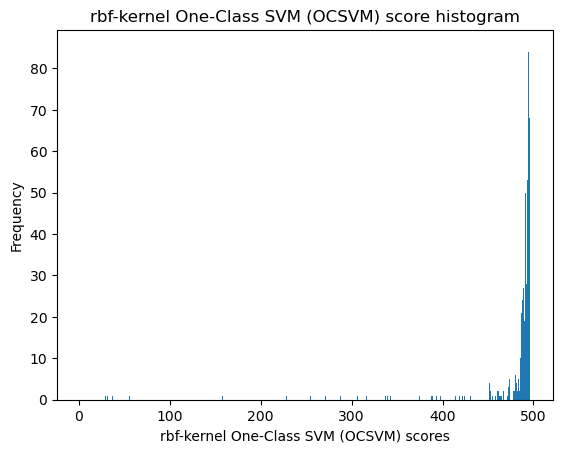

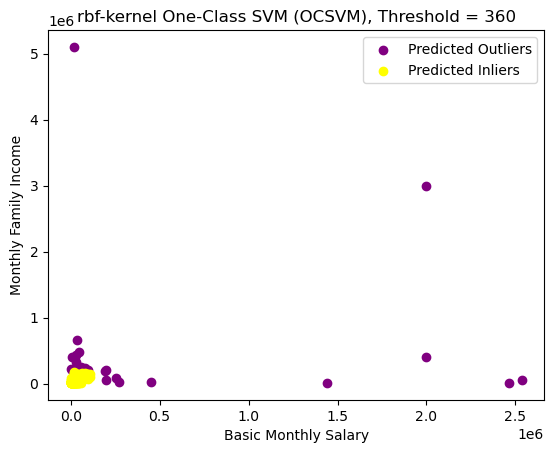

Number of predicted outliers: 38


userId             lastFirstName  age  basicMonthlySalary  \
14      5415           LAMOSTE, JO-ANN   36             2534900   
24      8342             VALDEZ, MOSES   28               50000   
32      9274          ALMUETE, CRISTEL   35              200000   
50      9989            BITAS, SHARRAH   23               37266   
70     10503            CASTRO, GLENDA   46              200000   
114    10596              ALERE, DINOS   40               19000   
162    10679              GONEZ, JAMES   25               80000   
200    10764        SANTOS, JOHN CARLO   27               60000   
231    11170           SANTOR, EMELITA   54                7500   
253    11201             ABALOS, GLYNN   36               80000   
299    11265          FERRER, JUDY ANN   29               18499   
323    11301         NEVAREZ, SYRA MAW   27               37000   
325    11304            NOROMOR, ABNER   47              257250   
380    11395           SAGURAN, JESSIE   46               47777   
391    11411           ORTEGA, MERRIAM   44             2000000   
405    11430           CLAROS, BELEJUN   28               60000   
417    11443           NERVIDA, REYNER   37             2464625   
435    11471           TESALONA, CYRUS   25               26000   
515    11593         SAMPAGA, MA. EDEN   39               14820   
556    11666             TOMAS, SARATE   49               22000   
558    11669            TOLEDO, LAARNI   28               21000   
563    11676             JAVIER, ALVIN   39              193520   
568    11684         DE FIESTA, ALBERT   46                9490   
584    11705        VALENZUELA, RACHEL   30             2000000   
608    11744           MARTINEZ, NOREL   28              270000   
677    11863           DANGANI, SHARON   36               37000   
692    11891            MACAWILI, ALEX   30               75000   
702    11903           SARAMAN, MANJAN   32                5000   
706    11909          GELAGA, BERDENIA   50               32000   
762    11995             REMON, JAYTEE   29               28000   
773    12020           TONOG, CRISTINA   33               23000   
830    12114  PANAGUITON, JHON ANTHONY   35              450000   
868    12353           PACARRO, ANGELY   34                 570   
912    12616            MATIONG, RAFFY   41              100000   
929    12642    CANTOR, MARIA CRISTINA   39               75400   
940    12660     REGALADO, MARTIN JOHN   30               22050   
1009   12760           SANGREO, JULIUS   36             1440452   
1046   12817            MINGUITO, LANI   32               20000   

      preferredNetDisposableIncomeId  workingFamilyCount  residentsCount  \
14                                 3                   2               5   
24                                 3                   4               8   
32                                 3                   2               3   
50                                 3                   2               4   
70                                 3                   1               5   
114                                1                   0               0   
162                                3                   2               3   
200                                3                   1               5   
231                                1                   6               3   
253                                3                   2               2   
299                                2                   6               8   
323                                3                   2               4   
325                                3                   0               0   
380                                3                   1               2   
391                                3                   2               4   
405                                3                   5               8   
417                                2                   2              10   
435                     

[14, 24, 32, 50, 70, 114, 162, 200, 231, 253, 299, 323, 325, 380, 391, 405, 417, 435, 515, 556, 558, 563, 568, 584, 608, 677, 692, 702, 706, 762, 773, 830, 868, 912, 929, 940, 1009, 1046]


In [6]:
# k = 'rbf'

# scores = plot_hist_ocsvm(ho_t01_num, kernel=k,
#                          bins=1_000)

# ho_t01_outliers = plot_ocsvm(ho_t01_num, k, scores, 360)
# print(ho_t01_outliers)

## EDA on Dataset

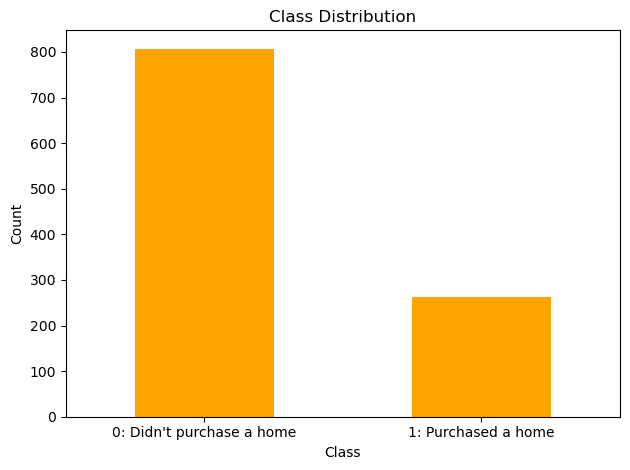

0    0.754206
1    0.245794
Name: home_ownership_class, dtype: float64

In [38]:
df = t01
class_counts = df['home_ownership_class'].value_counts()
class_counts = class_counts.rename({0: "0: Didn't purchase a home",
                                    1: "1: Purchased a home"})

# Plot
class_counts.plot(kind='bar', color='orange')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
df['home_ownership_class'].value_counts(normalize=True)

## Runs: RobustScaler

In [13]:
t01_adaboost_gs, t01_adaboost_be, t01_adaboost_model_info, t01_adaboost_metrics_df = adaboost_class2(t01, 'precision',
                                                            'home_ownership_class', RobustScaler(), random_state=0)

Fitting 10 folds for each of 40 candidates, totalling 400 fits
Best Hyperparameters: {'classifier__algorithm': 'SAMME', 'classifier__estimator': RandomForestClassifier(random_state=0), 'classifier__n_estimators': 200, 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.44305555555555554
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 AdaBoostClassifier(algorithm='SAMME',
                                    estimator=RandomForestClassifier(random_state=0),
                                    n_estimators=200, random_state=0))])
Mean Train Score (Precision) 0.8231436589746053
Std Train Score (Precision) 0.008166922068210177
GridSearchCV Runtime: 27.159427881240845 secs
Run 1 - Random State: 0
Test Precision: 0.5555555555555556
Run 2 - Random State: 1
Test Precision: 0.4444444444444444
Run 3 - Random State: 2
Test Precision: 0.4642857142857143
Run 4 - Ra

Permutation explainer: 269it [03:32,  1.23it/s]                         
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


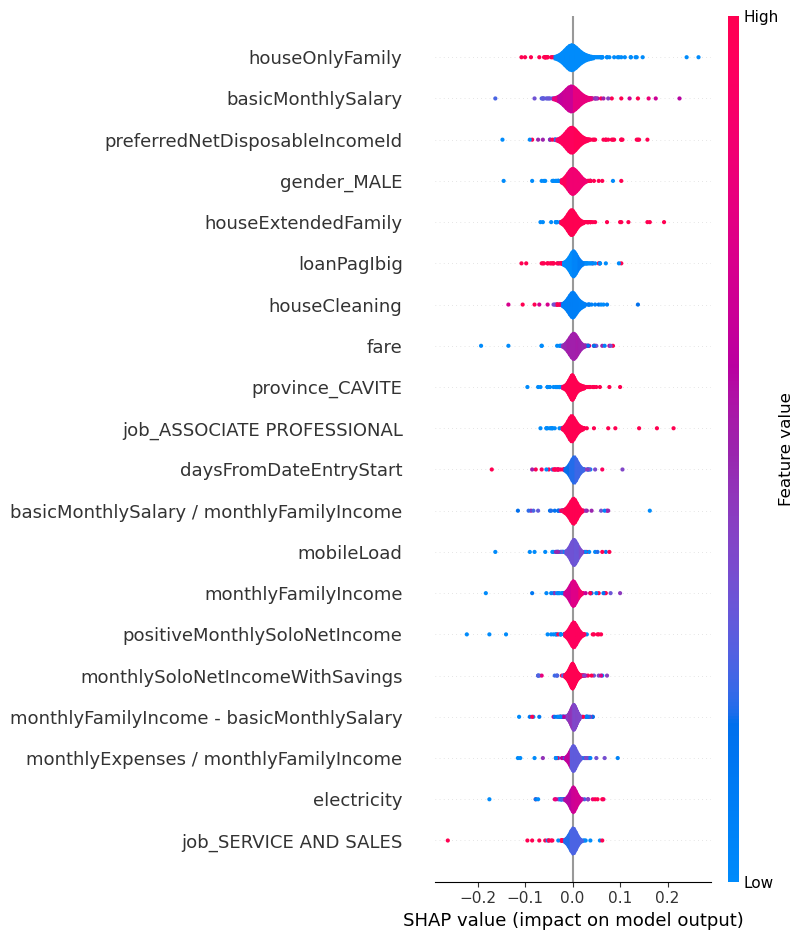

In [14]:
df = t01.copy()
# model = ho_t02_xgb_be.named_steps['classifier']
model = t01_adaboost_be
label_col = 'home_ownership_class'
X = df.drop(['userId', 'lastFirstName', label_col], axis=1)
y = df.loc[:, label_col]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    stratify=y,
                                                    random_state=0)

# input = ho_t12_adaboost_c0.drop(['user_id', 'lastFirstName', 'home_ownership_class'], axis=1)
# Fits the explainer
explainer = shap.Explainer(model.predict, X_test)
# explainer = shap.TreeExplainer(model=model,
#                                data=X_test,
#                                model_output='raw',
# #                                feature_perturbation='tree_path_dependent'
#                               )

# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)
# shap_values = explainer.shap_values(X_test)

feature_names = X.columns

# shap.summary_plot(shap_values, feature_names=feature_names, plot_type='dot')
shap.summary_plot(shap_values, feature_names=feature_names, plot_type='violin')

In [57]:
t01_dt_gs, t01_dt_be, t01_dt_model_info, t01_dt_metrics_df = dt_class2(t01, 'precision',
                                                            'home_ownership_class', RobustScaler(), random_state=0)

Fitting 10 folds for each of 1728 candidates, totalling 17280 fits



4320 fits failed out of a total of 17280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2540 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 638, in _

Best Hyperparameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 3, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'resampling': TomekLinks()}
Best Validation Score (Precision): 0.54
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()), ('resampling', TomekLinks()),
                ('classifier',
                 DecisionTreeClassifier(max_depth=3, max_features='sqrt',
                                        random_state=0))])
Mean Train Score (Precision) nan
Std Train Score (Precision) nan
GridSearchCV Runtime: 68.06337761878967 secs
Run 1 - Random State: 0
Test Precision: 0.42857142857142855
Run 2 - Random State: 1
Test Precision: 0.5
Run 3 - Random State: 2
Test Precision: 0.2857142857142857
Run 4 - Random State: 3
Test Precision: 0.3076923076923077
Run 5 - Random State: 4
Test Precision: 0.4
Ave Test Precision: 0.38439560439560444
Stdev Test Precision: 0.08829039481830309
Ave Test Accuracy: 0.73880597

In [58]:
t01_logreg_gs, t01_logreg_be, t01_logreg_model_info, t01_logreg_metrics_df = logreg_class2(t01, 'precision',
                                                            'home_ownership_class', RobustScaler(), random_state=0)

Fitting 10 folds for each of 390 candidates, totalling 3900 fits



650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.001, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cholesky', 'resampling': RandomOverSampler(random_state=0)}
Best Validation Score (Precision): 0.36572774961314863
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomOverSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=0.001, max_iter=1000, random_state=0,
                                    solver='newton-cholesky'))])
Mean Train Score (Precision) nan
Std Train Score (Precision) nan
GridSearchCV Runtime: 67.10965752601624 secs
Run 1 - Random State: 0
Test Precision: 0.358974358974359
Run 2 - Random State: 1
Test Precision: 0.3111111111111111
Run 3 - Random State: 2
Test Precision: 0.34146341463414637
Run 4 - Random State: 3
Test Precision: 0.27906976744186046
Run 5 - Random State: 4
Test Precision: 0.3023255813953488
Ave Test Precision: 0.3185888467113652
Stdev Test Precision: 0.03176634781

In [59]:
t01_knn_gs, t01_knn_be, t01_knn_model_info, t01_knn_metrics_df = knn_class2(t01, 'precision',
                                                            'home_ownership_class', RobustScaler(), random_state=0)

Fitting 10 folds for each of 600 candidates, totalling 6000 fits
Best Hyperparameters: {'classifier__metric': 'canberra', 'classifier__n_neighbors': 14, 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.40547619047619043
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 KNeighborsClassifier(metric='canberra', n_neighbors=14))])
Mean Train Score (Precision) 0.4975805654249833
Std Train Score (Precision) 0.01743018395454533
GridSearchCV Runtime: 74.92488527297974 secs
Run 1 - Random State: 0
Test Precision: 0.3333333333333333
Run 2 - Random State: 1
Test Precision: 0.3333333333333333
Run 3 - Random State: 2
Test Precision: 0.34615384615384615
Run 4 - Random State: 3
Test Precision: 0.18181818181818182
Run 5 - Random State: 4
Test Precision: 0.3157894736842105
Ave Test Precision: 0.302085633664581
Stdev Test Precision: 0.06809350194050394
Ave Test Accu

In [60]:
t01_svm_gs, t01_svm_be, t01_svm_model_info, t01_svm_metrics_df = svm_class2(t01, 'precision',
                                                            'home_ownership_class', RobustScaler(), random_state=0)

Fitting 10 folds for each of 520 candidates, totalling 5200 fits
[LibSVM]

Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__kernel': 'linear', 'classifier__probability': True, 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.43410714285714286
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 SVC(C=1e-06, kernel='linear', max_iter=1000, probability=True,
                     random_state=0, verbose=True))])
Mean Train Score (Precision) 0.39149316520748995
Std Train Score (Precision) 0.07969388459435693
GridSearchCV Runtime: 124.3963270187378 secs
[LibSVM]

Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


Run 1 - Random State: 0
Test Precision: 0.38461538461538464
[LibSVM]

Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


Run 2 - Random State: 1
Test Precision: 0.24180327868852458
[LibSVM]

Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


Run 3 - Random State: 2
Test Precision: 0.234375
[LibSVM]

Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


Run 4 - Random State: 3
Test Precision: 0.17647058823529413
[LibSVM]Run 5 - Random State: 4
Test Precision: 0.23043478260869565
Ave Test Precision: 0.25353980682957983
Stdev Test Precision: 0.07771639081378666
Ave Test Accuracy: 0.4552238805970149
Stdev Test Accuracy: 0.2494564150454971
Ave Test Specificity: 0.4257425742574258
Ave Test Recall: 0.5454545454545455
Ave Test NPV: 0.6752032735929347
Ave Test F1-Score: 0.26205910239187313
Ave Test G-mean: 0.24585594366648195
Ave Runtime: 0.26648383140563964


Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


In [66]:
t01_catboost_gs, t01_catboost_be, t01_catboost_model_info, t01_catboost_metrics_df = catboost_class2(t01, 'precision',
                                                            'home_ownership_class', RobustScaler(), random_state=0)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


Learning rate set to 0.011148
0:	learn: 0.6885821	total: 150ms	remaining: 2m 30s
1:	learn: 0.6828888	total: 154ms	remaining: 1m 16s
2:	learn: 0.6786242	total: 159ms	remaining: 52.9s
3:	learn: 0.6753646	total: 166ms	remaining: 41.3s
4:	learn: 0.6714577	total: 171ms	remaining: 34.1s
5:	learn: 0.6677667	total: 176ms	remaining: 29.1s
6:	learn: 0.6637892	total: 179ms	remaining: 25.4s
7:	learn: 0.6599952	total: 182ms	remaining: 22.6s
8:	learn: 0.6543472	total: 185ms	remaining: 20.4s
9:	learn: 0.6497911	total: 189ms	remaining: 18.7s
10:	learn: 0.6460371	total: 192ms	remaining: 17.2s
11:	learn: 0.6427181	total: 195ms	remaining: 16.1s
12:	learn: 0.6389833	total: 202ms	remaining: 15.3s
13:	learn: 0.6363486	total: 205ms	remaining: 14.4s
14:	learn: 0.6313790	total: 208ms	remaining: 13.7s
15:	learn: 0.6279137	total: 212ms	remaining: 13s
16:	learn: 0.6253118	total: 216ms	remaining: 12.5s
17:	learn: 0.6216672	total: 220ms	remaining: 12s
18:	learn: 0.6183065	total: 224ms	remaining: 11.6s
19:	learn: 0.

In [65]:
t01_lgbm_gs, t01_lgbm_be, t01_lgbm_model_info, t01_lgbm_metrics_df = lgbm_class2(t01, 'precision',
                                                            'home_ownership_class', RobustScaler(), random_state=0)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits
[LightGBM] [Info] Number of positive: 598, number of negative: 605
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10638
[LightGBM] [Info] Number of data points in the train set: 1203, number of used features: 92
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497091 -> initscore=-0.011638
[LightGBM] [Info] Start training from score -0.011638
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [62]:
t01_gbm_gs, t01_gbm_be, t01_gbm_model_info, t01_gbm_metrics_df = gbm_class2(t01, 'precision',
                                                            'home_ownership_class', RobustScaler(), random_state=0)

Fitting 10 folds for each of 80 candidates, totalling 800 fits
Best Hyperparameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 250, 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.3917071817071817
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 GradientBoostingClassifier(min_samples_leaf=2,
                                            n_estimators=250,
                                            random_state=0))])
Mean Train Score (Precision) 0.7949891435880618
Std Train Score (Precision) 0.013737503092123038
GridSearchCV Runtime: 222.53612971305847 secs
Run 1 - Random State: 0
Test Precision: 0.3793103448275862
Run 2 - Random State: 1
Test Precision: 0.45161290322580644
Run 3 - Random State: 2
Test Precision: 0.3793103448275862
R

In [61]:
t01_rf_gs, t01_rf_be, t01_rf_model_info, t01_rf_metrics_df = rf_class2(t01, 'precision',
                                                            'home_ownership_class', RobustScaler(), random_state=0)

Fitting 10 folds for each of 480 candidates, totalling 4800 fits
Best Hyperparameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 2, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300, 'classifier__oob_score': True, 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.39369047619047615
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 RandomForestClassifier(criterion='entropy', max_depth=2,
                                        min_samples_leaf=2, n_estimators=300,
                                        oob_score=True, random_state=0))])
Mean Train Score (Precision) 0.46966445904939025
Std Train Score (Precision) 0.02837871675257637
GridSearchCV Runtime: 292.4465732574463 secs
Run 1 - Random State: 0
Test Precision: 0.5384615384615384
Run 2 - Random State: 1
Test Precision:

In [63]:
t01_xgb_gs, t01_xgb_be, t01_xgb_model_info, t01_xgb_metrics_df = xgb_class2(t01, 'precision',
                                                            'home_ownership_class', RobustScaler(), random_state=0)

Fitting 10 folds for each of 540 candidates, totalling 5400 fits
Best Hyperparameters: {'classifier__grow_policy': 'depthwise', 'classifier__learning_rate': 0.01, 'classifier__max_depth': None, 'classifier__max_leaves': 10, 'classifier__n_estimators': 250, 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.42254884004884
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy='depthwise', importance_type=None,
          

In [67]:
model_vars = ['knn', 'svm', 'logreg', 'dt', 'rf', 'gbm', 'lgbm', 'xgb', 'adaboost', 'catboost']

var_df = {
    'Classifier model': [
        'k-Nearest Neighbors', 'SVM Classifier',
        'Logistic Regression', 'Decision Tree', 'Random Forest',
        'Gradient Boosting Machine (GBM)',
        'LightGBM', 'Extreme Gradient Boosting (XGBoost)',
        'AdaBoost', 'CatBoost'
    ],
    'Best Hyperparameters': [],
    'Average Val Precision': [],
    'Average Train Precision': [],
    'Stdev Train Precision': [],
    'Average Test Precision': [],
    'Stdev Test Precision': [],
    'Average Test Accuracy': [],
    'Stdev Test Accuracy': [],
    'Average Runtime': [],
    'Average Test Specificity': [],
    'Average Test Recall': [],
    'Average Test NPV': [],
    'Average Test F1-score': [],
    'Average Test G-mean': []
}

prefix = 't01_'
for name in model_vars:
    var_df['Best Hyperparameters'].append(globals()[prefix+name+'_model_info']['best_params'])
    var_df['Average Val Precision'].append(globals()[prefix+name+'_model_info']['best_cv_score'])
    var_df['Average Train Precision'].append(globals()[prefix+name+'_model_info']['mean_train_score'])
    var_df['Stdev Train Precision'].append(globals()[prefix+name+'_model_info']['std_train_score'])
    var_df['Average Test Precision'].append(globals()[prefix+name+'_model_info']['average_test_precision'])
    var_df['Stdev Test Precision'].append(globals()[prefix+name+'_model_info']['stdev_test_precision'])
    var_df['Average Test Accuracy'].append(globals()[prefix+name+'_model_info']['average_test_accuracy'])
    var_df['Stdev Test Accuracy'].append(globals()[prefix+name+'_model_info']['stdev_test_accuracy'])
    var_df['Average Runtime'].append(globals()[prefix+name+'_model_info']['average_runtime'])
    var_df['Average Test Specificity'].append(globals()[prefix+name+'_model_info']['average_test_specificity'])
    var_df['Average Test Recall'].append(globals()[prefix+name+'_model_info']['average_test_recall'])
    var_df['Average Test NPV'].append(globals()[prefix+name+'_model_info']['average_test_npv'])
    var_df['Average Test F1-score'].append(globals()[prefix+name+'_model_info']['average_test_f1_score'])
    var_df['Average Test G-mean'].append(globals()[prefix+name+'_model_info']['average_test_g_mean'])

# display(t01_model_summ)
t01_summ = pd.DataFrame(var_df)

# columns_to_exclude = ['Best Hyperparameters', 'Average Runtime']
# selected_columns = [col for col in ho_t1__summ.columns if col not in columns_to_exclude]
# ho_t1__summ[selected_columns]

t01_summ[[
    'Classifier model', 'Average Test Precision', 'Stdev Test Precision',
    'Average Val Precision', 'Average Train Precision', 'Stdev Train Precision',
    'Average Test Accuracy', 'Stdev Test Accuracy', 'Average Test Specificity',
    'Average Test Recall', 'Average Test NPV', 'Average Test F1-score', 'Average Test G-mean'
]].sort_values(by='Average Test Precision', ascending=False)

Classifier model  Average Test Precision  \
8                             AdaBoost                0.475880   
6                             LightGBM                0.437047   
4                        Random Forest                0.406486   
9                             CatBoost                0.405452   
3                        Decision Tree                0.384396   
5      Gradient Boosting Machine (GBM)                0.372523   
7  Extreme Gradient Boosting (XGBoost)                0.366936   
2                  Logistic Regression                0.318589   
0                  k-Nearest Neighbors                0.302086   
1                       SVM Classifier                0.253540   

   Stdev Test Precision  Average Val Precision  Average Train Precision  \
8              0.065041               0.443056                 0.823144   
6              0.063884               0.433384                 0.651429   
4              0.084835               0.393690                 0.469664   
9              0.061050               0.416270                 0.829829   
3              0.088290               0.540000                      NaN   
5              0.058986               0.391707                 0.794989   
7              0.026405               0.422549                 0.755685   
2              0.031766               0.365728                      NaN   
0              0.068094               0.405476                 0.497581   
1              0.077716               0.434107                 0.391493   

   Stdev Train Precision  Average Test Accuracy  Stdev Test Accuracy  \
8               0.008167               0.748507             0.748507   
6               0.025268               0.739552             0.739552   
4               0.028379               0.716418             0.716418   
9               0.007559               0.740299             0.740299   
3                    NaN               0.738806             0.738806   
5               0.013738               0.721642             0.721642   
7               0.015443               0.728358             0.728358   
2                    NaN               0.638806             0.638806   
0               0.017430               0.720896             0.720896   
1               0.079694               0.455224             0.455224   

   Average Test Specificity  Average Test Recall  Average Test NPV  \
8                  0.947525             0.139394          0.771264   
6                  0.925743             0.169697          0.773339   
4                  0.874257             0.233333          0.777783   
9                  0.944554             0.115152          0.765647   
3                  0.958416             0.066667          0.758641   
5                  0.899010             0.178788          0.770062   
7                  0.918812             0.145455          0.767026   
2                  0.714851             0.406061          0.786333   
0                  0.922772             0.103030          0.758990   
1                  0.425743             0.545455          0.675203   

   Average Test F1-score  Average Test G-mean  
8               0.211105             0.358642  
6               0.242638             0.395604  
4               0.276723             0.437517  
9               0.179245             0.329086  
3               0.106992             0.242516  
5               0.240641             0.400414  
7               0.206565             0.362448  
2               0.356827             0.538607  
0               0.152829             0.304971  
1               0.262059             0.245856

In [68]:
best_scores_models = {
    'Best Score': [],
    'Best Model': []
}

indices = [
    'Highest Test Accuracy',
    'Highest Test G-mean',
    'Highest Test Recall',
    'Highest Test Precision',
    'Highest Test Specificity',
    'Highest Test F1-score'
]

# Corresponding column names in your original dataframe
columns = [
    'Average Test Accuracy',
    'Average Test G-mean',
    'Average Test Recall',
    'Average Test Precision',
    'Average Test Specificity',
    'Average Test F1-score'
]

df = t01_summ
# Finding the best model for each metric
for col in columns:
    best_score = df[col].max()
    best_model = df.loc[df[col] == best_score, 'Classifier model'].values[0]
    
    best_scores_models['Best Score'].append(best_score)
    best_scores_models['Best Model'].append(best_model)

# Creating the new dataframe
best_df = pd.DataFrame(best_scores_models, index=indices)

# Displaying the new dataframe
best_df

Best Score           Best Model
Highest Test Accuracy       0.748507             AdaBoost
Highest Test G-mean         0.538607  Logistic Regression
Highest Test Recall         0.545455       SVM Classifier
Highest Test Precision      0.475880             AdaBoost
Highest Test Specificity    0.958416        Decision Tree
Highest Test F1-score       0.356827  Logistic Regression

## Runs: StandardScaler

In [15]:
scaler = StandardScaler()

In [16]:
t01_adaboost_gs, t01_adaboost_be, t01_adaboost_model_info, t01_adaboost_metrics_df = adaboost_class2(t01, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


Best Hyperparameters: {'classifier__algorithm': 'SAMME', 'classifier__estimator': RandomForestClassifier(random_state=0), 'classifier__n_estimators': 200, 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.36547619047619045
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 AdaBoostClassifier(algorithm='SAMME',
                                    estimator=RandomForestClassifier(random_state=0),
                                    n_estimators=200, random_state=0))])
Mean Train Score (Precision) 0.8264166738421256
Std Train Score (Precision) 0.007436635690014595
GridSearchCV Runtime: 43.816099405288696 secs
Run 1 - Random State: 0
Test Precision: 0.6666666666666666
Run 2 - Random State: 1
Test Precision: 0.32142857142857145
Run 3 - Random State: 2
Test Precision: 0.4583333333333333
Run 4 - Random State: 3
Test Precision: 0.4411764705882353
Run 5 - Ran

Permutation explainer: 269it [03:10,  1.35it/s]                         
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


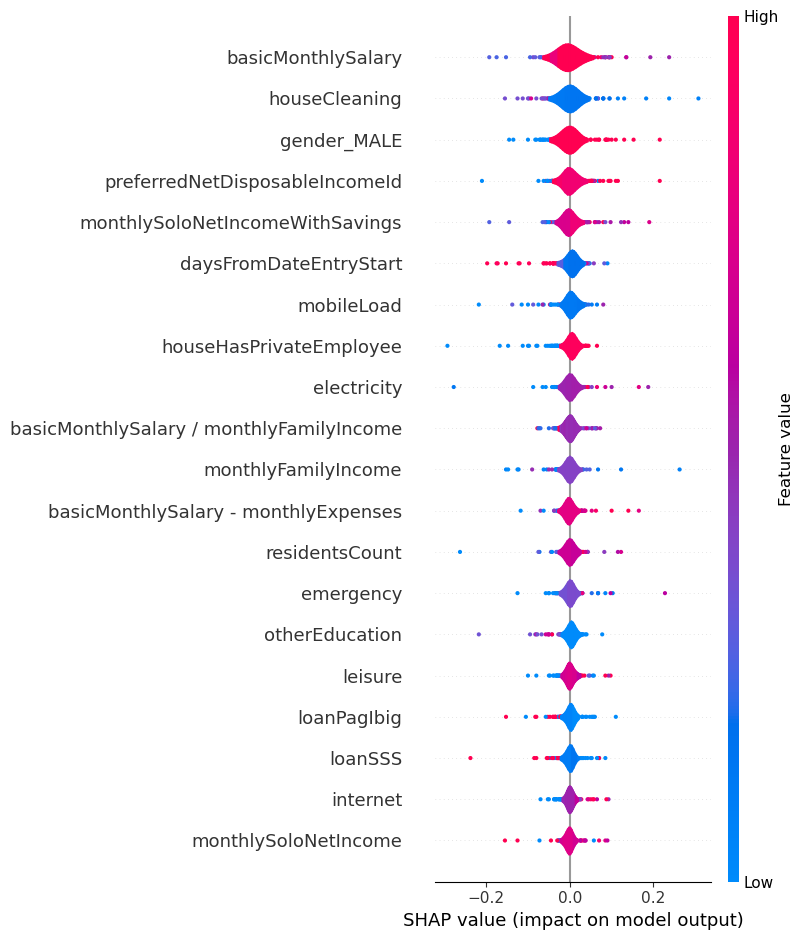

In [17]:
df = t01.copy()
# model = ho_t02_xgb_be.named_steps['classifier']
model = t01_adaboost_be
label_col = 'home_ownership_class'
X = df.drop(['userId', 'lastFirstName', label_col], axis=1)
y = df.loc[:, label_col]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    stratify=y,
                                                    random_state=0)

# input = ho_t12_adaboost_c0.drop(['user_id', 'lastFirstName', 'home_ownership_class'], axis=1)
# Fits the explainer
explainer = shap.Explainer(model.predict, X_test)
# explainer = shap.TreeExplainer(model=model,
#                                data=X_test,
#                                model_output='raw',
# #                                feature_perturbation='tree_path_dependent'
#                               )

# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)
# shap_values = explainer.shap_values(X_test)

feature_names = X.columns

# shap.summary_plot(shap_values, feature_names=feature_names, plot_type='dot')
shap.summary_plot(shap_values, feature_names=feature_names, plot_type='violin')

In [78]:
t01_dt_gs, t01_dt_be, t01_dt_model_info, t01_dt_metrics_df = dt_class2(t01, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 1728 candidates, totalling 17280 fits



4320 fits failed out of a total of 17280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2306 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 638, in _

Best Hyperparameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'resampling': TomekLinks()}
Best Validation Score (Precision): 0.5521212121212121
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()), ('resampling', TomekLinks()),
                ('classifier',
                 DecisionTreeClassifier(max_depth=5, max_features='log2',
                                        random_state=0))])
Mean Train Score (Precision) nan
Std Train Score (Precision) nan
GridSearchCV Runtime: 39.0693244934082 secs
Run 1 - Random State: 0
Test Precision: 0.5238095238095238
Run 2 - Random State: 1
Test Precision: 0.36363636363636365
Run 3 - Random State: 2
Test Precision: 0.28205128205128205
Run 4 - Random State: 3
Test Precision: 0.39285714285714285
Run 5 - Random State: 4
Test Precision: 0.35
Ave Test Precision: 0.3824708624708625
Stdev Test Precision: 0.088850547827320

In [79]:
t01_logreg_gs, t01_logreg_be, t01_logreg_model_info, t01_logreg_metrics_df = logreg_class2(t01, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 390 candidates, totalling 3900 fits


Best Hyperparameters: {'classifier__C': 0.001, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': RandomUnderSampler(random_state=0)}
Best Validation Score (Precision): 0.3253726754829696
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', RandomUnderSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=0.001, max_iter=1000, random_state=0))])
Mean Train Score (Precision) nan
Std Train Score (Precision) nan
GridSearchCV Runtime: 21.254807710647583 secs
Run 1 - Random State: 0
Test Precision: 0.36283185840707965
Run 2 - Random State: 1
Test Precision: 0.3269230769230769
Run 3 - Random State: 2
Test Precision: 0.30357142857142855
Run 4 - Random State: 3
Test Precision: 0.3275862068965517
Run 5 - Random State: 4
Test Precision: 0.3106796116504854
Ave Test Precision: 0.3263184364897245
Stdev Test Precision: 0.022897609174105295
Ave Test Accuracy: 0.6119402985074627
Stdev Test Accuracy: 


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

In [80]:
t01_knn_gs, t01_knn_be, t01_knn_model_info, t01_knn_metrics_df = knn_class2(t01, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 600 candidates, totalling 6000 fits


Best Hyperparameters: {'classifier__metric': 'hamming', 'classifier__n_neighbors': 2, 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.37857142857142856
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 KNeighborsClassifier(metric='hamming', n_neighbors=2))])
Mean Train Score (Precision) 0.4995708655866818
Std Train Score (Precision) 0.01721208466344703
GridSearchCV Runtime: 52.652310371398926 secs
Run 1 - Random State: 0
Test Precision: 0.3076923076923077
Run 2 - Random State: 1
Test Precision: 0.15384615384615385
Run 3 - Random State: 2
Test Precision: 0.3333333333333333
Run 4 - Random State: 3
Test Precision: 0.5
Run 5 - Random State: 4
Test Precision: 0.4375
Ave Test Precision: 0.34647435897435896
Stdev Test Precision: 0.1328891918516311
Ave Test Accuracy: 0.7388059701492538
Stdev Test Accuracy: 0.012653600714785936
Ave Test Specificity: 0.9594

In [81]:
t01_svm_gs, t01_svm_be, t01_svm_model_info, t01_svm_metrics_df = svm_class2(t01, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 520 candidates, totalling 5200 fits
[LibSVM]Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__kernel': 'sigmoid', 'classifier__probability': True, 'resampling': RandomOverSampler(random_state=0)}
Best Validation Score (Precision): 0.37537878787878787
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', RandomOverSampler(random_state=0)),
                ('classifier',
                 SVC(C=1e-06, kernel='sigmoid', max_iter=1000, probability=True,
                     random_state=0, verbose=True))])
Mean Train Score (Precision) 0.48919273629595417
Std Train Score (Precision) 0.027501346789657138
GridSearchCV Runtime: 108.1265025138855 secs
[LibSVM]Run 1 - Random State: 0
Test Precision: 0.34285714285714286
[LibSVM]Run 2 - Random State: 1
Test Precision: 0.3229166666666667
[LibSVM]Run 3 - Random State: 2
Test Precision: 0.0
[LibSVM]Run 4 - Random State: 3
Test Precision: 0.3333333333333333
[LibSVM]Run 5 - Ra

In [83]:
t01_catboost_gs, t01_catboost_be, t01_catboost_model_info, t01_catboost_metrics_df = catboost_class2(t01, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Learning rate set to 0.011282
0:	learn: 0.6904638	total: 5.56ms	remaining: 5.56s
1:	learn: 0.6869440	total: 10.6ms	remaining: 5.28s
2:	learn: 0.6843552	total: 16ms	remaining: 5.31s
3:	learn: 0.6802248	total: 20.8ms	remaining: 5.19s
4:	learn: 0.6749626	total: 25.4ms	remaining: 5.06s
5:	learn: 0.6720534	total: 30.4ms	remaining: 5.04s
6:	learn: 0.6693428	total: 35.3ms	remaining: 5.01s
7:	learn: 0.6668972	total: 40.7ms	remaining: 5.04s
8:	learn: 0.6648925	total: 45.1ms	remaining: 4.97s
9:	learn: 0.6612404	total: 49.7ms	remaining: 4.92s
10:	learn: 0.6584408	total: 54ms	remaining: 4.86s
11:	learn: 0.6548622	total: 58.2ms	remaining: 4.79s
12:	learn: 0.6520760	total: 62.5ms	remaining: 4.74s
13:	learn: 0.6498387	total: 67.4ms	remaining: 4.75s
14:	learn: 0.6449951	total: 71.4ms	remaining: 4.69s
15:	learn: 0.6424862	total: 75.5ms	remaining: 4.64s
16:	learn: 0.6381307	total: 79.4ms	remaining: 4.59s
17:	learn: 0.6357834	total: 83.8ms	rema

In [85]:
t01_lgbm_gs, t01_lgbm_be, t01_lgbm_model_info, t01_lgbm_metrics_df = lgbm_class2(t01, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits
[LightGBM] [Info] Number of positive: 605, number of negative: 605
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9866
[LightGBM] [Info] Number of data points in the train set: 1210, number of used features: 91
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

In [86]:
t01_gbm_gs, t01_gbm_be, t01_gbm_model_info, t01_gbm_metrics_df = gbm_class2(t01, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


Best Hyperparameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 250, 'resampling': RandomOverSampler(random_state=0)}
Best Validation Score (Precision): 0.3612367031832976
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', RandomOverSampler(random_state=0)),
                ('classifier',
                 GradientBoostingClassifier(min_samples_leaf=2,
                                            n_estimators=250,
                                            random_state=0))])
Mean Train Score (Precision) 0.7893188130340366
Std Train Score (Precision) 0.013797244667461583
GridSearchCV Runtime: 251.76132488250732 secs
Run 1 - Random State: 0
Test Precision: 0.3448275862068966
Run 2 - Random State: 1
Test Precision: 0.3181818181818182
Run 3 - Random State: 2
Test Precision: 0.38461538461538464
Run 4 - Random State: 3
Test Precision

In [87]:
t01_rf_gs, t01_rf_be, t01_rf_model_info, t01_rf_metrics_df = rf_class2(t01, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 480 candidates, totalling 4800 fits
Best Hyperparameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200, 'classifier__oob_score': True, 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.34056631019479316
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 RandomForestClassifier(max_depth=3, min_samples_leaf=3,
                                        n_estimators=200, oob_score=True,
                                        random_state=0))])
Mean Train Score (Precision) 0.4514879858240946
Std Train Score (Precision) 0.025808457206570996
GridSearchCV Runtime: 370.96174335479736 secs
Run 1 - Random State: 0
Test Precision: 0.5333333333333333
Run 2 - Random State: 1
Test Precision: 0.3582089552238806
R

In [88]:
t01_xgb_gs, t01_xgb_be, t01_xgb_model_info, t01_xgb_metrics_df = xgb_class2(t01, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 540 candidates, totalling 5400 fits
Best Hyperparameters: {'classifier__grow_policy': 'depthwise', 'classifier__learning_rate': 0.1, 'classifier__max_depth': None, 'classifier__max_leaves': 10, 'classifier__n_estimators': 200, 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.4305555555555555
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy='depthwise', importance_type=None,
     

In [89]:
model_vars = ['knn', 'svm', 'logreg', 'dt', 'rf', 'gbm', 'lgbm', 'xgb', 'adaboost', 'catboost']

var_df = {
    'Classifier model': [
        'k-Nearest Neighbors', 'SVM Classifier',
        'Logistic Regression', 'Decision Tree', 'Random Forest',
        'Gradient Boosting Machine (GBM)',
        'LightGBM', 'Extreme Gradient Boosting (XGBoost)',
        'AdaBoost', 'CatBoost'
    ],
    'Best Hyperparameters': [],
    'Average Val Precision': [],
    'Average Train Precision': [],
    'Stdev Train Precision': [],
    'Average Test Precision': [],
    'Stdev Test Precision': [],
    'Average Test Accuracy': [],
    'Stdev Test Accuracy': [],
    'Average Runtime': [],
    'Average Test Specificity': [],
    'Average Test Recall': [],
    'Average Test NPV': [],
    'Average Test F1-score': [],
    'Average Test G-mean': []
}

prefix = 't01_'
for name in model_vars:
    var_df['Best Hyperparameters'].append(globals()[prefix+name+'_model_info']['best_params'])
    var_df['Average Val Precision'].append(globals()[prefix+name+'_model_info']['best_cv_score'])
    var_df['Average Train Precision'].append(globals()[prefix+name+'_model_info']['mean_train_score'])
    var_df['Stdev Train Precision'].append(globals()[prefix+name+'_model_info']['std_train_score'])
    var_df['Average Test Precision'].append(globals()[prefix+name+'_model_info']['average_test_precision'])
    var_df['Stdev Test Precision'].append(globals()[prefix+name+'_model_info']['stdev_test_precision'])
    var_df['Average Test Accuracy'].append(globals()[prefix+name+'_model_info']['average_test_accuracy'])
    var_df['Stdev Test Accuracy'].append(globals()[prefix+name+'_model_info']['stdev_test_accuracy'])
    var_df['Average Runtime'].append(globals()[prefix+name+'_model_info']['average_runtime'])
    var_df['Average Test Specificity'].append(globals()[prefix+name+'_model_info']['average_test_specificity'])
    var_df['Average Test Recall'].append(globals()[prefix+name+'_model_info']['average_test_recall'])
    var_df['Average Test NPV'].append(globals()[prefix+name+'_model_info']['average_test_npv'])
    var_df['Average Test F1-score'].append(globals()[prefix+name+'_model_info']['average_test_f1_score'])
    var_df['Average Test G-mean'].append(globals()[prefix+name+'_model_info']['average_test_g_mean'])

# display(t01_model_summ)
t01_summ = pd.DataFrame(var_df)

# columns_to_exclude = ['Best Hyperparameters', 'Average Runtime']
# selected_columns = [col for col in ho_t1__summ.columns if col not in columns_to_exclude]
# ho_t1__summ[selected_columns]

t01_summ[[
    'Classifier model', 'Average Test Precision', 'Stdev Test Precision',
    'Average Val Precision', 'Average Train Precision', 'Stdev Train Precision',
    'Average Test Accuracy', 'Stdev Test Accuracy', 'Average Test Specificity',
    'Average Test Recall', 'Average Test NPV', 'Average Test F1-score', 'Average Test G-mean'
]].sort_values(by='Average Test Precision', ascending=False)

Classifier model  Average Test Precision  \
8                             AdaBoost                0.465021   
9                             CatBoost                0.437123   
7  Extreme Gradient Boosting (XGBoost)                0.426831   
4                        Random Forest                0.403596   
6                             LightGBM                0.400155   
3                        Decision Tree                0.382471   
0                  k-Nearest Neighbors                0.346474   
5      Gradient Boosting Machine (GBM)                0.341242   
2                  Logistic Regression                0.326318   
1                       SVM Classifier                0.268571   

   Stdev Test Precision  Average Val Precision  Average Train Precision  \
8              0.125150               0.365476                 0.826417   
9              0.055523               0.396667                 0.835777   
7              0.067163               0.430556                 0.744636   
4              0.075462               0.340566                 0.451488   
6              0.031775               0.413479                 0.629024   
3              0.088851               0.552121                      NaN   
0              0.132889               0.378571                 0.499571   
5              0.031980               0.361237                 0.789319   
2              0.022898               0.325373                      NaN   
1              0.150373               0.375379                 0.489193   

   Stdev Train Precision  Average Test Accuracy  Stdev Test Accuracy  \
8               0.007437               0.743284             0.743284   
9               0.007151               0.741045             0.741045   
7               0.013497               0.736567             0.736567   
4               0.025808               0.714925             0.714925   
6               0.020450               0.727612             0.727612   
3                    NaN               0.728358             0.728358   
0               0.017212               0.738806             0.738806   
5               0.013797               0.690299             0.690299   
2                    NaN               0.611940             0.611940   
1               0.027501               0.694776             0.694776   

   Average Test Specificity  Average Test Recall  Average Test NPV  \
8                  0.936634             0.151515          0.771690   
9                  0.928713             0.166667          0.773270   
7                  0.905941             0.218182          0.780211   
4                  0.853465             0.290909          0.786924   
6                  0.898020             0.206061          0.775884   
3                  0.918812             0.145455          0.766862   
0                  0.959406             0.063636          0.758221   
5                  0.826733             0.272727          0.776782   
2                  0.634653             0.542424          0.809638   
1                  0.848515             0.224242          0.772320   

   Average Test F1-score  Average Test G-mean  
8               0.222359             0.372630  
9               0.240825             0.393266  
7               0.287847             0.441626  
4               0.329476             0.491623  
6               0.271085             0.429621  
3               0.208210             0.363699  
0               0.106661             0.242646  
5               0.301486             0.473083  
2               0.407281             0.586016  
1               0.230470             0.366415

In [90]:
best_scores_models = {
    'Best Score': [],
    'Best Model': []
}

indices = [
    'Highest Test Accuracy',
    'Highest Test G-mean',
    'Highest Test Recall',
    'Highest Test Precision',
    'Highest Test Specificity',
    'Highest Test F1-score'
]

# Corresponding column names in your original dataframe
columns = [
    'Average Test Accuracy',
    'Average Test G-mean',
    'Average Test Recall',
    'Average Test Precision',
    'Average Test Specificity',
    'Average Test F1-score'
]

df = t01_summ
# Finding the best model for each metric
for col in columns:
    best_score = df[col].max()
    best_model = df.loc[df[col] == best_score, 'Classifier model'].values[0]
    
    best_scores_models['Best Score'].append(best_score)
    best_scores_models['Best Model'].append(best_model)

# Creating the new dataframe
best_df = pd.DataFrame(best_scores_models, index=indices)

# Displaying the new dataframe
best_df

Best Score           Best Model
Highest Test Accuracy       0.743284             AdaBoost
Highest Test G-mean         0.586016  Logistic Regression
Highest Test Recall         0.542424  Logistic Regression
Highest Test Precision      0.465021             AdaBoost
Highest Test Specificity    0.959406  k-Nearest Neighbors
Highest Test F1-score       0.407281  Logistic Regression

## Runs: MinMaxScaler

In [18]:
scaler = MinMaxScaler()

In [94]:
t01_adaboost_gs, t01_adaboost_be, t01_adaboost_model_info, t01_adaboost_metrics_df = adaboost_class2(t01, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 40 candidates, totalling 400 fits
Best Hyperparameters: {'classifier__algorithm': 'SAMME', 'classifier__estimator': RandomForestClassifier(random_state=0), 'classifier__n_estimators': 200, 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.36698135198135196
Best Estimator: Pipeline(steps=[('scaler', MinMaxScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 AdaBoostClassifier(algorithm='SAMME',
                                    estimator=RandomForestClassifier(random_state=0),
                                    n_estimators=200, random_state=0))])
Mean Train Score (Precision) 0.8203665733377411
Std Train Score (Precision) 0.006787868455785764
GridSearchCV Runtime: 12.050014972686768 secs
Run 1 - Random State: 0
Test Precision: 0.3333333333333333
Run 2 - Random State: 1
Test Precision: 0.2571428571428571
Run 3 - Random State: 2
Test Precision: 0.25
Run 4 - Random State: 

In [95]:
t01_dt_gs, t01_dt_be, t01_dt_model_info, t01_dt_metrics_df = dt_class2(t01, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 1728 candidates, totalling 17280 fits



4320 fits failed out of a total of 17280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2423 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 638, in _

Best Hyperparameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 3, 'resampling': TomekLinks()}
Best Validation Score (Precision): 0.5874819624819624
Best Estimator: Pipeline(steps=[('scaler', MinMaxScaler()), ('resampling', TomekLinks()),
                ('classifier',
                 DecisionTreeClassifier(max_depth=5, max_features='log2',
                                        min_samples_split=3, random_state=0))])
Mean Train Score (Precision) nan
Std Train Score (Precision) nan
GridSearchCV Runtime: 45.51039505004883 secs
Run 1 - Random State: 0
Test Precision: 0.45454545454545453
Run 2 - Random State: 1
Test Precision: 0.3333333333333333
Run 3 - Random State: 2
Test Precision: 0.26666666666666666
Run 4 - Random State: 3
Test Precision: 0.2
Run 5 - Random State: 4
Test Precision: 0.5
Ave Test Precision: 0.3509090909090909
Stdev Test Precision: 0.125646171904

In [96]:
t01_logreg_gs, t01_logreg_be, t01_logreg_model_info, t01_logreg_metrics_df = logreg_class2(t01, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 390 candidates, totalling 3900 fits



650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.45
Best Estimator: Pipeline(steps=[('scaler', MinMaxScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=0.01, max_iter=1000, random_state=0))])
Mean Train Score (Precision) nan
Std Train Score (Precision) nan
GridSearchCV Runtime: 42.30820631980896 secs
Run 1 - Random State: 0
Test Precision: 0.35714285714285715
Run 2 - Random State: 1
Test Precision: 0.37142857142857144
Run 3 - Random State: 2
Test Precision: 0.4
Run 4 - Random State: 3
Test Precision: 0.375
Run 5 - Random State: 4
Test Precision: 0.3953488372093023
Ave Test Precision: 0.37978405315614616
Stdev Test Precision: 0.017721963814908818
Ave Test Accuracy: 0.7350746268656716
Stdev Test Accuracy: 0.0142085319139252
Ave Test Specificity: 0.9356435643564357
Ave 

In [97]:
t01_knn_gs, t01_knn_be, t01_knn_model_info, t01_knn_metrics_df = knn_class2(t01, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 600 candidates, totalling 6000 fits
Best Hyperparameters: {'classifier__metric': 'chebyshev', 'classifier__n_neighbors': 13, 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.3963888888888889
Best Estimator: Pipeline(steps=[('scaler', MinMaxScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 KNeighborsClassifier(metric='chebyshev', n_neighbors=13))])
Mean Train Score (Precision) 0.5030823205250171
Std Train Score (Precision) 0.015390835611851911
GridSearchCV Runtime: 70.98736572265625 secs
Run 1 - Random State: 0
Test Precision: 0.2608695652173913
Run 2 - Random State: 1
Test Precision: 0.2
Run 3 - Random State: 2
Test Precision: 0.23529411764705882
Run 4 - Random State: 3
Test Precision: 0.1875
Run 5 - Random State: 4
Test Precision: 0.15
Ave Test Precision: 0.20673273657289
Stdev Test Precision: 0.042954569027750196
Ave Test Accuracy: 0.7119402985074627
Stdev Test Accura

In [98]:
t01_svm_gs, t01_svm_be, t01_svm_model_info, t01_svm_metrics_df = svm_class2(t01, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 520 candidates, totalling 5200 fits
[LibSVM]Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__kernel': 'poly', 'classifier__probability': True, 'resampling': RandomUnderSampler(random_state=0)}
Best Validation Score (Precision): 0.36460312835312836
Best Estimator: Pipeline(steps=[('scaler', MinMaxScaler()),
                ('resampling', RandomUnderSampler(random_state=0)),
                ('classifier',
                 SVC(C=1e-06, kernel='poly', max_iter=1000, probability=True,
                     random_state=0, verbose=True))])
Mean Train Score (Precision) 0.3972907993648116
Std Train Score (Precision) 0.01428982707183499
GridSearchCV Runtime: 112.69371676445007 secs
[LibSVM]Run 1 - Random State: 0
Test Precision: 0.2972972972972973
[LibSVM]Run 2 - Random State: 1
Test Precision: 0.27692307692307694
[LibSVM]Run 3 - Random State: 2
Test Precision: 0.3333333333333333
[LibSVM]Run 4 - Random State: 3
Test Precision: 0.30434782608695654
[LibSVM]R

In [99]:
t01_catboost_gs, t01_catboost_be, t01_catboost_model_info, t01_catboost_metrics_df = catboost_class2(t01, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Learning rate set to 0.011235
0:	learn: 0.6899036	total: 22.4ms	remaining: 22.3s
1:	learn: 0.6879018	total: 27.7ms	remaining: 13.8s
2:	learn: 0.6855107	total: 33.2ms	remaining: 11s
3:	learn: 0.6818007	total: 38.2ms	remaining: 9.5s
4:	learn: 0.6779000	total: 42.9ms	remaining: 8.54s
5:	learn: 0.6739376	total: 48.4ms	remaining: 8.01s
6:	learn: 0.6718846	total: 53.9ms	remaining: 7.64s
7:	learn: 0.6696322	total: 58.6ms	remaining: 7.27s
8:	learn: 0.6671108	total: 64.1ms	remaining: 7.05s
9:	learn: 0.6639419	total: 69.3ms	remaining: 6.86s
10:	learn: 0.6603524	total: 74.2ms	remaining: 6.67s
11:	learn: 0.6570631	total: 79.4ms	remaining: 6.54s
12:	learn: 0.6546488	total: 84.7ms	remaining: 6.43s
13:	learn: 0.6521371	total: 89.6ms	remaining: 6.31s
14:	learn: 0.6499302	total: 94.9ms	remaining: 6.23s
15:	learn: 0.6467228	total: 100ms	remaining: 6.16s
16:	learn: 0.6441519	total: 105ms	remaining: 6.09s
17:	learn: 0.6427153	total: 111ms	remain

In [102]:
t01_lgbm_gs, t01_lgbm_be, t01_lgbm_model_info, t01_lgbm_metrics_df = lgbm_class2(t01, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 605, number of negative: 605
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10391
[LightGBM] [Info] Number of data points in the train set: 1210, number of used features: 93
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits wit

In [103]:
t01_gbm_gs, t01_gbm_be, t01_gbm_model_info, t01_gbm_metrics_df = gbm_class2(t01, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 80 candidates, totalling 800 fits
Best Hyperparameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 250, 'resampling': RandomOverSampler(random_state=0)}
Best Validation Score (Precision): 0.36415336984996427
Best Estimator: Pipeline(steps=[('scaler', MinMaxScaler()),
                ('resampling', RandomOverSampler(random_state=0)),
                ('classifier',
                 GradientBoostingClassifier(min_samples_leaf=2,
                                            n_estimators=250,
                                            random_state=0))])
Mean Train Score (Precision) 0.7804951226850534
Std Train Score (Precision) 0.01404909561382805
GridSearchCV Runtime: 213.00230240821838 secs
Run 1 - Random State: 0
Test Precision: 0.3448275862068966
Run 2 - Random State: 1
Test Precision: 0.3181818181818182
Run 3 - Random State: 2
Test Precisio

In [104]:
t01_rf_gs, t01_rf_be, t01_rf_model_info, t01_rf_metrics_df = rf_class2(t01, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 480 candidates, totalling 4800 fits
Best Hyperparameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200, 'classifier__oob_score': True, 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.34876662243844914
Best Estimator: Pipeline(steps=[('scaler', MinMaxScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 RandomForestClassifier(max_depth=3, min_samples_leaf=3,
                                        n_estimators=200, oob_score=True,
                                        random_state=0))])
Mean Train Score (Precision) 0.43030479827739093
Std Train Score (Precision) 0.020067863602251435
GridSearchCV Runtime: 343.91191601753235 secs
Run 1 - Random State: 0
Test Precision: 0.49206349206349204
Run 2 - Random State: 1
Test Precision: 0.32978723404255317


In [20]:
t01_xgb_gs, t01_xgb_be, t01_xgb_model_info, t01_xgb_metrics_df = xgb_class2(t01, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 540 candidates, totalling 5400 fits


KeyboardInterrupt: 

In [ ]:
df = t01.copy()
# model = ho_t02_xgb_be.named_steps['classifier']
model = t01_xgb_be
label_col = 'home_ownership_class'
X = df.drop(['userId', 'lastFirstName', label_col], axis=1)
y = df.loc[:, label_col]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    stratify=y,
                                                    random_state=0)

# input = ho_t12_adaboost_c0.drop(['user_id', 'lastFirstName', 'home_ownership_class'], axis=1)
# Fits the explainer
explainer = shap.Explainer(model.predict, X_test)
# explainer = shap.TreeExplainer(model=model,
#                                data=X_test,
#                                model_output='raw',
# #                                feature_perturbation='tree_path_dependent'
#                               )

# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)
# shap_values = explainer.shap_values(X_test)

feature_names = X.columns

# shap.summary_plot(shap_values, feature_names=feature_names, plot_type='dot')
shap.summary_plot(shap_values, feature_names=feature_names, plot_type='violin')

In [107]:
model_vars = ['knn', 'svm', 'logreg', 'dt', 'rf', 'gbm', 'lgbm', 'xgb', 'adaboost', 'catboost']

var_df = {
    'Classifier model': [
        'k-Nearest Neighbors', 'SVM Classifier',
        'Logistic Regression', 'Decision Tree', 'Random Forest',
        'Gradient Boosting Machine (GBM)',
        'LightGBM', 'Extreme Gradient Boosting (XGBoost)',
        'AdaBoost', 'CatBoost'
    ],
    'Best Hyperparameters': [],
    'Average Val Precision': [],
    'Average Train Precision': [],
    'Stdev Train Precision': [],
    'Average Test Precision': [],
    'Stdev Test Precision': [],
    'Average Test Accuracy': [],
    'Stdev Test Accuracy': [],
    'Average Runtime': [],
    'Average Test Specificity': [],
    'Average Test Recall': [],
    'Average Test NPV': [],
    'Average Test F1-score': [],
    'Average Test G-mean': []
}

prefix = 't01_'
for name in model_vars:
    var_df['Best Hyperparameters'].append(globals()[prefix+name+'_model_info']['best_params'])
    var_df['Average Val Precision'].append(globals()[prefix+name+'_model_info']['best_cv_score'])
    var_df['Average Train Precision'].append(globals()[prefix+name+'_model_info']['mean_train_score'])
    var_df['Stdev Train Precision'].append(globals()[prefix+name+'_model_info']['std_train_score'])
    var_df['Average Test Precision'].append(globals()[prefix+name+'_model_info']['average_test_precision'])
    var_df['Stdev Test Precision'].append(globals()[prefix+name+'_model_info']['stdev_test_precision'])
    var_df['Average Test Accuracy'].append(globals()[prefix+name+'_model_info']['average_test_accuracy'])
    var_df['Stdev Test Accuracy'].append(globals()[prefix+name+'_model_info']['stdev_test_accuracy'])
    var_df['Average Runtime'].append(globals()[prefix+name+'_model_info']['average_runtime'])
    var_df['Average Test Specificity'].append(globals()[prefix+name+'_model_info']['average_test_specificity'])
    var_df['Average Test Recall'].append(globals()[prefix+name+'_model_info']['average_test_recall'])
    var_df['Average Test NPV'].append(globals()[prefix+name+'_model_info']['average_test_npv'])
    var_df['Average Test F1-score'].append(globals()[prefix+name+'_model_info']['average_test_f1_score'])
    var_df['Average Test G-mean'].append(globals()[prefix+name+'_model_info']['average_test_g_mean'])

# display(t01_model_summ)
t01_summ = pd.DataFrame(var_df)

# columns_to_exclude = ['Best Hyperparameters', 'Average Runtime']
# selected_columns = [col for col in ho_t1__summ.columns if col not in columns_to_exclude]
# ho_t1__summ[selected_columns]

t01_summ[[
    'Classifier model', 'Average Test Precision', 'Stdev Test Precision',
    'Average Val Precision', 'Average Train Precision', 'Stdev Train Precision',
    'Average Test Accuracy', 'Stdev Test Accuracy', 'Average Test Specificity',
    'Average Test Recall', 'Average Test NPV', 'Average Test F1-score', 'Average Test G-mean'
]].sort_values(by='Average Test Precision', ascending=False)

Classifier model  Average Test Precision  \
7  Extreme Gradient Boosting (XGBoost)                0.405552   
9                             CatBoost                0.398939   
4                        Random Forest                0.386338   
6                             LightGBM                0.385316   
2                  Logistic Regression                0.379784   
3                        Decision Tree                0.350909   
5      Gradient Boosting Machine (GBM)                0.344044   
8                             AdaBoost                0.329689   
1                       SVM Classifier                0.299852   
0                  k-Nearest Neighbors                0.206733   

   Stdev Test Precision  Average Val Precision  Average Train Precision  \
7              0.046765               0.431313                 0.732847   
9              0.061458               0.379297                 0.824066   
4              0.065611               0.348767                 0.430305   
6              0.037428               0.389121                 0.612427   
2              0.017722               0.450000                      NaN   
3              0.125646               0.587482                      NaN   
5              0.034092               0.364153                 0.780495   
8              0.075809               0.366981                 0.820367   
1              0.021387               0.364603                 0.397291   
0              0.042955               0.396389                 0.503082   

   Stdev Train Precision  Average Test Accuracy  Stdev Test Accuracy  \
7               0.012492               0.728358             0.013297   
9               0.007152               0.730597             0.730597   
4               0.020068               0.689552             0.042166   
6               0.017244               0.700000             0.023392   
2                    NaN               0.735075             0.735075   
3                    NaN               0.741791             0.741791   
5               0.014049               0.691045             0.021500   
8               0.006788               0.714925             0.714925   
1               0.014290               0.614179             0.614179   
0               0.015391               0.711940             0.711940   

   Average Test Specificity  Average Test Recall  Average Test NPV  \
7                  0.894059             0.221212          0.778486   
9                  0.909901             0.181818          0.772937   
4                  0.778218             0.418182          0.803521   
6                  0.812871             0.354545          0.793967   
2                  0.935644             0.121212          0.765789   
3                  0.968317             0.048485          0.756994   
5                  0.826733             0.275758          0.777481   
8                  0.900000             0.148485          0.763883   
1                  0.676238             0.424242          0.785070   
0                  0.924752             0.060606          0.750812   

   Average Test F1-score  Average Test G-mean  
7               0.285707             0.443606  
9               0.249016             0.405408  
4               0.399484             0.568680  
6               0.367932             0.536020  
2               0.166354             0.309009  
3               0.081935             0.204701  
5               0.304542             0.475888  
8               0.203125             0.362622  
1               0.344372             0.522157  
0               0.093436             0.234633

In [108]:
best_scores_models = {
    'Best Score': [],
    'Best Model': []
}

indices = [
    'Highest Test Accuracy',
    'Highest Test G-mean',
    'Highest Test Recall',
    'Highest Test Precision',
    'Highest Test Specificity',
    'Highest Test F1-score'
]

# Corresponding column names in your original dataframe
columns = [
    'Average Test Accuracy',
    'Average Test G-mean',
    'Average Test Recall',
    'Average Test Precision',
    'Average Test Specificity',
    'Average Test F1-score'
]

df = t01_summ
# Finding the best model for each metric
for col in columns:
    best_score = df[col].max()
    best_model = df.loc[df[col] == best_score, 'Classifier model'].values[0]
    
    best_scores_models['Best Score'].append(best_score)
    best_scores_models['Best Model'].append(best_model)

# Creating the new dataframe
best_df = pd.DataFrame(best_scores_models, index=indices)

# Displaying the new dataframe
best_df

Best Score                           Best Model
Highest Test Accuracy       0.741791                        Decision Tree
Highest Test G-mean         0.568680                        Random Forest
Highest Test Recall         0.424242                       SVM Classifier
Highest Test Precision      0.405552  Extreme Gradient Boosting (XGBoost)
Highest Test Specificity    0.968317                        Decision Tree
Highest Test F1-score       0.399484                        Random Forest

# HO_T02: Yes - 1, 30

In [ ]:
t02 = dataset.copy().drop(columns=cols_with_nulls)
# t02_num = t02.drop(columns=['gender', 'province', 'job'])
t02 = pd.get_dummies(t02, columns=['gender'], prefix='gender', drop_first='True')
t02 = pd.get_dummies(t02, columns=['province'], prefix='province', drop_first='True')
t02 = pd.get_dummies(t02, columns=['job'], prefix='job', drop_first='True')

t02.loc[t02['basicMonthlySalary'] < 100, 'basicMonthlySalary'] *= 1000

# t02.isna().sum()[t02.isna().sum() > 0]
df = t02

## EDA on Dataset

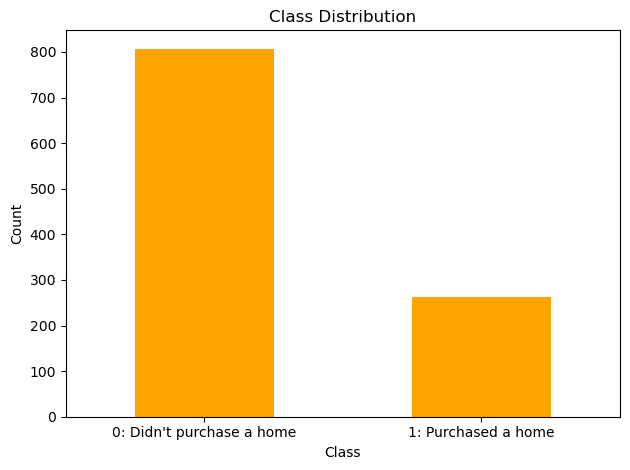

0    0.754206
1    0.245794
Name: home_ownership_class, dtype: float64

In [ ]:
class_counts = df['home_ownership_class'].value_counts()
class_counts = class_counts.rename({0: "0: Didn't purchase a home",
                                    1: "1: Purchased a home"})

# Plot
class_counts.plot(kind='bar', color='orange')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
df['home_ownership_class'].value_counts(normalize=True)

## Runs: RobustScaler()

In [ ]:
scaler = RobustScaler()

In [112]:
t02_adaboost_gs, t02_adaboost_be, t02_adaboost_model_info, t02_adaboost_metrics_df = adaboost_class2(t02, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


Best Hyperparameters: {'classifier__algorithm': 'SAMME', 'classifier__estimator': RandomForestClassifier(random_state=0), 'classifier__n_estimators': 200, 'resampling': RandomOverSampler(random_state=0)}
Best Validation Score (Precision): 0.45357142857142857
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomOverSampler(random_state=0)),
                ('classifier',
                 AdaBoostClassifier(algorithm='SAMME',
                                    estimator=RandomForestClassifier(random_state=0),
                                    n_estimators=200, random_state=0))])
Mean Train Score (Precision) 0.8217452336840785
Std Train Score (Precision) 0.009675048561331062
GridSearchCV Runtime: 13.107861995697021 secs
Run 1 - Random State: 0
Test Precision: 0.4666666666666667
Run 2 - Random State: 1
Test Precision: 0.4090909090909091
Run 3 - Random State: 2
Test Precision: 0.23076923076923078
Run 4 - Random State: 3
Test Precision: 0.333333

In [113]:
t02_dt_gs, t02_dt_be, t02_dt_model_info, t02_dt_metrics_df = dt_class2(t02, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 1728 candidates, totalling 17280 fits



4320 fits failed out of a total of 17280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1620 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 638, in _

Best Hyperparameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 3, 'classifier__max_features': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'resampling': TomekLinks()}
Best Validation Score (Precision): 0.4750793650793651
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()), ('resampling', TomekLinks()),
                ('classifier',
                 DecisionTreeClassifier(max_depth=3, random_state=0))])
Mean Train Score (Precision) nan
Std Train Score (Precision) nan
GridSearchCV Runtime: 78.49798226356506 secs
Run 1 - Random State: 0
Test Precision: 0.2727272727272727
Run 2 - Random State: 1
Test Precision: 0.21428571428571427
Run 3 - Random State: 2
Test Precision: 0.34375
Run 4 - Random State: 3
Test Precision: 0.38095238095238093
Run 5 - Random State: 4
Test Precision: 0.42424242424242425
Ave Test Precision: 0.32719155844155845
Stdev Test Precision: 0.08410910568941579
Ave Test Accuracy: 0.7291044776119403
Stdev Test Accuracy

In [114]:
t02_logreg_gs, t02_logreg_be, t02_logreg_model_info, t02_logreg_metrics_df = logreg_class2(t02, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 390 candidates, totalling 3900 fits



650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.3654545454545455
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0))])
Mean Train Score (Precision) nan
Std Train Score (Precision) nan
GridSearchCV Runtime: 68.87681984901428 secs
Run 1 - Random State: 0
Test Precision: 0.3333333333333333
Run 2 - Random State: 1
Test Precision: 0.21428571428571427
Run 3 - Random State: 2
Test Precision: 0.29411764705882354
Run 4 - Random State: 3
Test Precision: 0.2608695652173913
Run 5 - Random State: 4
Test Precision: 0.3793103448275862
Ave Test Precision: 0.29638332094456976
Stdev Test Precision: 0.06373494302331839
Ave Test Accuracy: 0.7179104477611941
Stdev Test Accuracy: 0.010749895739468602


In [115]:
t02_knn_gs, t02_knn_be, t02_knn_model_info, t02_knn_metrics_df = knn_class2(t02, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 600 candidates, totalling 6000 fits
Best Hyperparameters: {'classifier__metric': 'hamming', 'classifier__n_neighbors': 2, 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.37857142857142856
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 KNeighborsClassifier(metric='hamming', n_neighbors=2))])
Mean Train Score (Precision) 0.4976901164040487
Std Train Score (Precision) 0.0176741274428663
GridSearchCV Runtime: 77.99703764915466 secs
Run 1 - Random State: 0
Test Precision: 0.3076923076923077
Run 2 - Random State: 1
Test Precision: 0.15384615384615385
Run 3 - Random State: 2
Test Precision: 0.3333333333333333
Run 4 - Random State: 3
Test Precision: 0.5
Run 5 - Random State: 4
Test Precision: 0.4375
Ave Test Precision: 0.34647435897435896
Stdev Test Precision: 0.1328891918516311
Ave Test Accuracy: 0.7388059701492538
Stdev Tes

In [116]:
t02_svm_gs, t02_svm_be, t02_svm_model_info, t02_svm_metrics_df = svm_class2(t02, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 520 candidates, totalling 5200 fits


[LibSVM]

Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__kernel': 'linear', 'classifier__probability': True, 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.443230277185501
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 SVC(C=1e-06, kernel='linear', max_iter=1000, probability=True,
                     random_state=0, verbose=True))])
Mean Train Score (Precision) 0.3889726833759898
Std Train Score (Precision) 0.07656514305896203
GridSearchCV Runtime: 123.21518921852112 secs
[LibSVM]

Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


Run 1 - Random State: 0
Test Precision: 0.5
[LibSVM]

Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


Run 2 - Random State: 1
Test Precision: 0.3191489361702128
[LibSVM]

Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


Run 3 - Random State: 2
Test Precision: 0.234375
[LibSVM]

Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


Run 4 - Random State: 3
Test Precision: 0.2288135593220339
[LibSVM]Run 5 - Random State: 4
Test Precision: 0.24537037037037038
Ave Test Precision: 0.3055415731725234
Stdev Test Precision: 0.1146425782434114
Ave Test Accuracy: 0.46194029850746265
Stdev Test Accuracy: 0.2410459313312737
Ave Test Specificity: 0.42772277227722777
Ave Test Recall: 0.5666666666666667
Ave Test NPV: 0.6815593321407275
Ave Test F1-Score: 0.30064777986959684
Ave Test G-mean: 0.31037048885859336
Ave Runtime: 0.24867649078369142


Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


In [ ]:
t02_catboost_gs, t02_catboost_be, t02_catboost_model_info, t02_catboost_metrics_df = catboost_class2(t02, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Learning rate set to 0.011148
0:	learn: 0.6887589	total: 6.33ms	remaining: 6.33s
1:	learn: 0.6857852	total: 10.6ms	remaining: 5.3s
2:	learn: 0.6805984	total: 15.1ms	remaining: 5.02s
3:	learn: 0.6740250	total: 19.7ms	remaining: 4.9s
4:	learn: 0.6694110	total: 24ms	remaining: 4.77s
5:	learn: 0.6646944	total: 28.7ms	remaining: 4.76s
6:	learn: 0.6604891	total: 34ms	remaining: 4.83s
7:	learn: 0.6565227	total: 38.6ms	remaining: 4.78s
8:	learn: 0.6523432	total: 43.4ms	remaining: 4.77s
9:	learn: 0.6482802	total: 49ms	remaining: 4.85s
10:	learn: 0.6449167	total: 53.9ms	remaining: 4.85s
11:	learn: 0.6428313	total: 58.4ms	remaining: 4.81s
12:	learn: 0.6382911	total: 63.4ms	remaining: 4.81s
13:	learn: 0.6348865	total: 68.2ms	remaining: 4.8s
14:	learn: 0.6303818	total: 73.5ms	remaining: 4.83s
15:	learn: 0.6263562	total: 81.7ms	remaining: 5.02s
16:	learn: 0.6235309	total: 86.9ms	remaining: 5.03s
17:	learn: 0.6192154	total: 91.9ms	remaining

In [ ]:
df = t02.copy()
# model = ho_t02_xgb_be.named_steps['classifier']
model = t02_catboost_be
label_col = 'home_ownership_class'
X = df.drop(['userId', 'lastFirstName', label_col], axis=1)
y = df.loc[:, label_col]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    stratify=y,
                                                    random_state=0)

# input = ho_t12_adaboost_c0.drop(['user_id', 'lastFirstName', 'home_ownership_class'], axis=1)
# Fits the explainer
explainer = shap.Explainer(model.predict, X_test)
# explainer = shap.TreeExplainer(model=model,
#                                data=X_test,
#                                model_output='raw',
# #                                feature_perturbation='tree_path_dependent'
#                               )

# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)
# shap_values = explainer.shap_values(X_test)

feature_names = X.columns

# shap.summary_plot(shap_values, feature_names=feature_names, plot_type='dot')
shap.summary_plot(shap_values, feature_names=feature_names, plot_type='violin')

In [118]:
t02_lgbm_gs, t02_lgbm_be, t02_lgbm_model_info, t02_lgbm_metrics_df = lgbm_class2(t02, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


[LightGBM] [Info] Number of positive: 598, number of negative: 605
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10538
[LightGBM] [Info] Number of data points in the train set: 1203, number of used features: 92
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497091 -> initscore=-0.011638
[LightGBM] [Info] Start training from score -0.011638
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [119]:
t02_gbm_gs, t02_gbm_be, t02_gbm_model_info, t02_gbm_metrics_df = gbm_class2(t02, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


Best Hyperparameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200, 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.382032967032967
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 GradientBoostingClassifier(min_samples_leaf=3,
                                            n_estimators=200,
                                            random_state=0))])
Mean Train Score (Precision) 0.7945291202441551
Std Train Score (Precision) 0.01345216214805683
GridSearchCV Runtime: 217.24684643745422 secs
Run 1 - Random State: 0
Test Precision: 0.36666666666666664
Run 2 - Random State: 1
Test Precision: 0.3103448275862069
Run 3 - Random State: 2
Test Precision: 0.35714285714285715
Run 4 - Random State: 3
Test Precision: 0.325
Run 5 - Random St

In [120]:
t02_rf_gs, t02_rf_be, t02_rf_model_info, t02_rf_metrics_df = rf_class2(t02, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 480 candidates, totalling 4800 fits
Best Hyperparameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300, 'classifier__oob_score': True, 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.3595646824973183
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 RandomForestClassifier(criterion='entropy', max_depth=3,
                                        min_samples_leaf=2, n_estimators=300,
                                        oob_score=True, random_state=0))])
Mean Train Score (Precision) 0.46516012999090517
Std Train Score (Precision) 0.02963707719577156
GridSearchCV Runtime: 325.4319770336151 secs
Run 1 - Random State: 0
Test Precision: 0.46
Run 2 - Random State: 1
Test Precision: 0.3125
Run 3 - Random 

In [121]:
t02_xgb_gs, t02_xgb_be, t02_xgb_model_info, t02_xgb_metrics_df = xgb_class2(t02, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 540 candidates, totalling 5400 fits
Best Hyperparameters: {'classifier__grow_policy': 'depthwise', 'classifier__learning_rate': 0.1, 'classifier__max_depth': None, 'classifier__max_leaves': 10, 'classifier__n_estimators': 250, 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.4528496503496503
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy='depthwise', importance_type=None,
       

In [122]:
model_vars = ['knn', 'svm', 'logreg', 'dt', 'rf', 'gbm', 'lgbm', 'xgb', 'adaboost', 'catboost']

var_df = {
    'Classifier model': [
        'k-Nearest Neighbors', 'SVM Classifier',
        'Logistic Regression', 'Decision Tree', 'Random Forest',
        'Gradient Boosting Machine (GBM)',
        'LightGBM', 'Extreme Gradient Boosting (XGBoost)',
        'AdaBoost', 'CatBoost'
    ],
    'Best Hyperparameters': [],
    'Average Val Precision': [],
    'Average Train Precision': [],
    'Stdev Train Precision': [],
    'Average Test Precision': [],
    'Stdev Test Precision': [],
    'Average Test Accuracy': [],
    'Stdev Test Accuracy': [],
    'Average Runtime': [],
    'Average Test Specificity': [],
    'Average Test Recall': [],
    'Average Test NPV': [],
    'Average Test F1-score': [],
    'Average Test G-mean': []
}

prefix = 't02_'
for name in model_vars:
    var_df['Best Hyperparameters'].append(globals()[prefix+name+'_model_info']['best_params'])
    var_df['Average Val Precision'].append(globals()[prefix+name+'_model_info']['best_cv_score'])
    var_df['Average Train Precision'].append(globals()[prefix+name+'_model_info']['mean_train_score'])
    var_df['Stdev Train Precision'].append(globals()[prefix+name+'_model_info']['std_train_score'])
    var_df['Average Test Precision'].append(globals()[prefix+name+'_model_info']['average_test_precision'])
    var_df['Stdev Test Precision'].append(globals()[prefix+name+'_model_info']['stdev_test_precision'])
    var_df['Average Test Accuracy'].append(globals()[prefix+name+'_model_info']['average_test_accuracy'])
    var_df['Stdev Test Accuracy'].append(globals()[prefix+name+'_model_info']['stdev_test_accuracy'])
    var_df['Average Runtime'].append(globals()[prefix+name+'_model_info']['average_runtime'])
    var_df['Average Test Specificity'].append(globals()[prefix+name+'_model_info']['average_test_specificity'])
    var_df['Average Test Recall'].append(globals()[prefix+name+'_model_info']['average_test_recall'])
    var_df['Average Test NPV'].append(globals()[prefix+name+'_model_info']['average_test_npv'])
    var_df['Average Test F1-score'].append(globals()[prefix+name+'_model_info']['average_test_f1_score'])
    var_df['Average Test G-mean'].append(globals()[prefix+name+'_model_info']['average_test_g_mean'])

# display(t02_model_summ)
t02_summ = pd.DataFrame(var_df)

# columns_to_exclude = ['Best Hyperparameters', 'Average Runtime']
# selected_columns = [col for col in ho_t1__summ.columns if col not in columns_to_exclude]
# ho_t1__summ[selected_columns]

t02_summ[[
    'Classifier model', 'Average Test Precision', 'Stdev Test Precision',
    'Average Val Precision', 'Average Train Precision', 'Stdev Train Precision',
    'Average Test Accuracy', 'Stdev Test Accuracy', 'Average Test Specificity',
    'Average Test Recall', 'Average Test NPV', 'Average Test F1-score', 'Average Test G-mean'
]].sort_values(by='Average Test Precision', ascending=False)

Classifier model  Average Test Precision  \
9                             CatBoost                0.445689   
8                             AdaBoost                0.402258   
6                             LightGBM                0.381111   
4                        Random Forest                0.376535   
7  Extreme Gradient Boosting (XGBoost)                0.374443   
0                  k-Nearest Neighbors                0.346474   
5      Gradient Boosting Machine (GBM)                0.335831   
3                        Decision Tree                0.327192   
1                       SVM Classifier                0.305542   
2                  Logistic Regression                0.296383   

   Stdev Test Precision  Average Val Precision  Average Train Precision  \
9              0.101642               0.385693                 0.829606   
8              0.129396               0.453571                 0.821745   
6              0.087806               0.464722                 0.647426   
4              0.065098               0.359565                 0.465160   
7              0.073225               0.452850                 0.752005   
0              0.132889               0.378571                 0.497690   
5              0.024609               0.382033                 0.794529   
3              0.084109               0.475079                      NaN   
1              0.114643               0.443230                 0.388973   
2              0.063735               0.365455                      NaN   

   Stdev Train Precision  Average Test Accuracy  Stdev Test Accuracy  \
9               0.007272               0.745522             0.015698   
8               0.009675               0.741045             0.012543   
6               0.020762               0.732090             0.014547   
4               0.029637               0.683582             0.044652   
7               0.014875               0.728358             0.011621   
0               0.017674               0.738806             0.012654   
5               0.013452               0.716418             0.009513   
3                    NaN               0.729104             0.008590   
1               0.076565               0.461940             0.241046   
2                    NaN               0.717910             0.010750   

   Average Test Specificity  Average Test Recall  Average Test NPV  \
9                  0.946535             0.130303          0.769107   
8                  0.954455             0.087879          0.762097   
6                  0.921782             0.151515          0.768938   
4                  0.778218             0.393939          0.796680   
7                  0.911881             0.166667          0.770253   
0                  0.959406             0.063636          0.758221   
5                  0.900000             0.154545          0.765188   
3                  0.928713             0.118182          0.763537   
1                  0.427723             0.566667          0.681559   
2                  0.914851             0.115152          0.759985   

   Average Test F1-score  Average Test G-mean  
9               0.201292             0.349440  
8               0.141156             0.284195  
6               0.214099             0.366537  
4               0.381878             0.552753  
7               0.228899             0.384244  
0               0.106661             0.242646  
5               0.210503             0.371373  
3               0.168830             0.315567  
1               0.300648             0.310370  
2               0.163838             0.316994

In [123]:
best_scores_models = {
    'Best Score': [],
    'Best Model': []
}

indices = [
    'Highest Test Accuracy',
    'Highest Test G-mean',
    'Highest Test Recall',
    'Highest Test Precision',
    'Highest Test Specificity',
    'Highest Test F1-score'
]

# Corresponding column names in your original dataframe
columns = [
    'Average Test Accuracy',
    'Average Test G-mean',
    'Average Test Recall',
    'Average Test Precision',
    'Average Test Specificity',
    'Average Test F1-score'
]

df = t02_summ
# Finding the best model for each metric
for col in columns:
    best_score = df[col].max()
    best_model = df.loc[df[col] == best_score, 'Classifier model'].values[0]
    
    best_scores_models['Best Score'].append(best_score)
    best_scores_models['Best Model'].append(best_model)

# Creating the new dataframe
best_df = pd.DataFrame(best_scores_models, index=indices)

# Displaying the new dataframe
best_df

Best Score           Best Model
Highest Test Accuracy       0.745522             CatBoost
Highest Test G-mean         0.552753        Random Forest
Highest Test Recall         0.566667       SVM Classifier
Highest Test Precision      0.445689             CatBoost
Highest Test Specificity    0.959406  k-Nearest Neighbors
Highest Test F1-score       0.381878        Random Forest

# HO_T03: Yes - 1, 3, 30

In [21]:
t03 = dataset.copy().drop(columns=cols_with_nulls)
t03 = t03[t03['positiveMonthlySoloNetIncome'] != 0]
# t03_num = t03.drop(columns=['gender', 'province', 'job'])
t03 = pd.get_dummies(t03, columns=['gender'], prefix='gender', drop_first='True')
t03 = pd.get_dummies(t03, columns=['province'], prefix='province', drop_first='True')
t03 = pd.get_dummies(t03, columns=['job'], prefix='job', drop_first='True')

t03.loc[t03['basicMonthlySalary'] < 100, 'basicMonthlySalary'] *= 1000

# t03.isna().sum()[t03.isna().sum() > 0]
df = t03

## EDA on Dataset

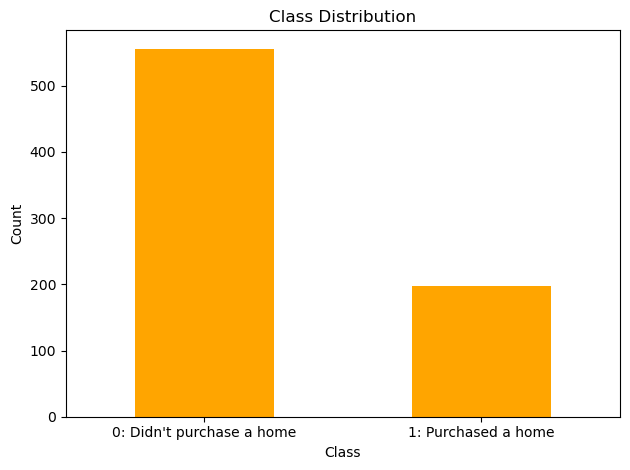

0    0.737401
1    0.262599
Name: home_ownership_class, dtype: float64

In [22]:
class_counts = df['home_ownership_class'].value_counts()
class_counts = class_counts.rename({0: "0: Didn't purchase a home",
                                    1: "1: Purchased a home"})

# Plot
class_counts.plot(kind='bar', color='orange')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
df['home_ownership_class'].value_counts(normalize=True)

## Runs: RobustScaler()

In [23]:
scaler = RobustScaler()

In [24]:
t03_adaboost_gs, t03_adaboost_be, t03_adaboost_model_info, t03_adaboost_metrics_df = adaboost_class2(t03, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


KeyboardInterrupt: 

In [128]:
t03_dt_gs, t03_dt_be, t03_dt_model_info, t03_dt_metrics_df = dt_class2(t03, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 1728 candidates, totalling 17280 fits



4320 fits failed out of a total of 17280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2718 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 638, in _

Best Hyperparameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 5, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 2, 'resampling': TomekLinks()}
Best Validation Score (Precision): 0.48678571428571427
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()), ('resampling', TomekLinks()),
                ('classifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=5,
                                        max_features='log2', min_samples_leaf=3,
                                        random_state=0))])
Mean Train Score (Precision) nan
Std Train Score (Precision) nan
GridSearchCV Runtime: 177.88160181045532 secs
Run 1 - Random State: 0
Test Precision: 0.42857142857142855
Run 2 - Random State: 1
Test Precision: 0.2608695652173913
Run 3 - Random State: 2
Test Precision: 0.16666666666666666
Run 4 - Random State: 3
Test Precision: 0.3103448275862069
Run 5 - Random State: 4
Test Precision:

In [129]:
t03_logreg_gs, t03_logreg_be, t03_logreg_model_info, t03_logreg_metrics_df = logreg_class2(t03, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 390 candidates, totalling 3900 fits



650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 10.0, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.35032517395148577
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=10.0, max_iter=1000, random_state=0))])
Mean Train Score (Precision) nan
Std Train Score (Precision) nan
GridSearchCV Runtime: 86.78028535842896 secs


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Run 1 - Random State: 0
Test Precision: 0.32857142857142857


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Run 2 - Random State: 1
Test Precision: 0.3373493975903614


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Run 3 - Random State: 2
Test Precision: 0.3783783783783784


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Run 4 - Random State: 3
Test Precision: 0.34285714285714286
Run 5 - Random State: 4
Test Precision: 0.2916666666666667
Ave Test Precision: 0.33576460281279563
Stdev Test Precision: 0.031085041799619073
Ave Test Accuracy: 0.6074074074074074
Stdev Test Accuracy: 0.024361617848087495
Ave Test Specificity: 0.6474820143884892
Ave Test Recall: 0.496
Ave Test NPV: 0.7815814166477681
Ave Test F1-Score: 0.4000522326440109
Ave Test G-mean: 0.5655959916291802
Ave Runtime: 0.34412398338317873


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [130]:
t03_knn_gs, t03_knn_be, t03_knn_model_info, t03_knn_metrics_df = knn_class2(t03, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 600 candidates, totalling 6000 fits
Best Hyperparameters: {'classifier__metric': 'hamming', 'classifier__n_neighbors': 4, 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.41666666666666663
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 KNeighborsClassifier(metric='hamming', n_neighbors=4))])
Mean Train Score (Precision) 0.5085176384984579
Std Train Score (Precision) 0.020434462774193272
GridSearchCV Runtime: 116.01406669616699 secs
Run 1 - Random State: 0
Test Precision: 0.5
Run 2 - Random State: 1
Test Precision: 0.1
Run 3 - Random State: 2
Test Precision: 0.2727272727272727
Run 4 - Random State: 3
Test Precision: 0.5
Run 5 - Random State: 4
Test Precision: 0.5714285714285714
Ave Test Precision: 0.3888311688311688
Stdev Test Precision: 0.19682631192315825
Ave Test Accuracy: 0.7227513227513228
Stdev Test Accuracy: 0.

In [25]:
t03_svm_gs, t03_svm_be, t03_svm_model_info, t03_svm_metrics_df = svm_class2(t03, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 520 candidates, totalling 5200 fits


[LibSVM]Best Hyperparameters: {'classifier__C': 0.01, 'classifier__kernel': 'poly', 'classifier__probability': True, 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.43499999999999994
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 SVC(C=0.01, kernel='poly', max_iter=1000, probability=True,
                     random_state=0, verbose=True))])
Mean Train Score (Precision) 0.31840025414788303
Std Train Score (Precision) 0.058317034551787515
GridSearchCV Runtime: 174.7231101989746 secs
[LibSVM]Run 1 - Random State: 0
Test Precision: 0.5
[LibSVM]Run 2 - Random State: 1
Test Precision: 0.4444444444444444
[LibSVM]Run 3 - Random State: 2
Test Precision: 0.8
[LibSVM]Run 4 - Random State: 3
Test Precision: 0.5294117647058824
[LibSVM]Run 5 - Random State: 4
Test Precision: 0.6
Ave Test Precision: 0.5747712418300653
Stdev Test Precision: 0.1378384730

Permutation explainer: 190it [03:30,  1.18s/it]                         
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


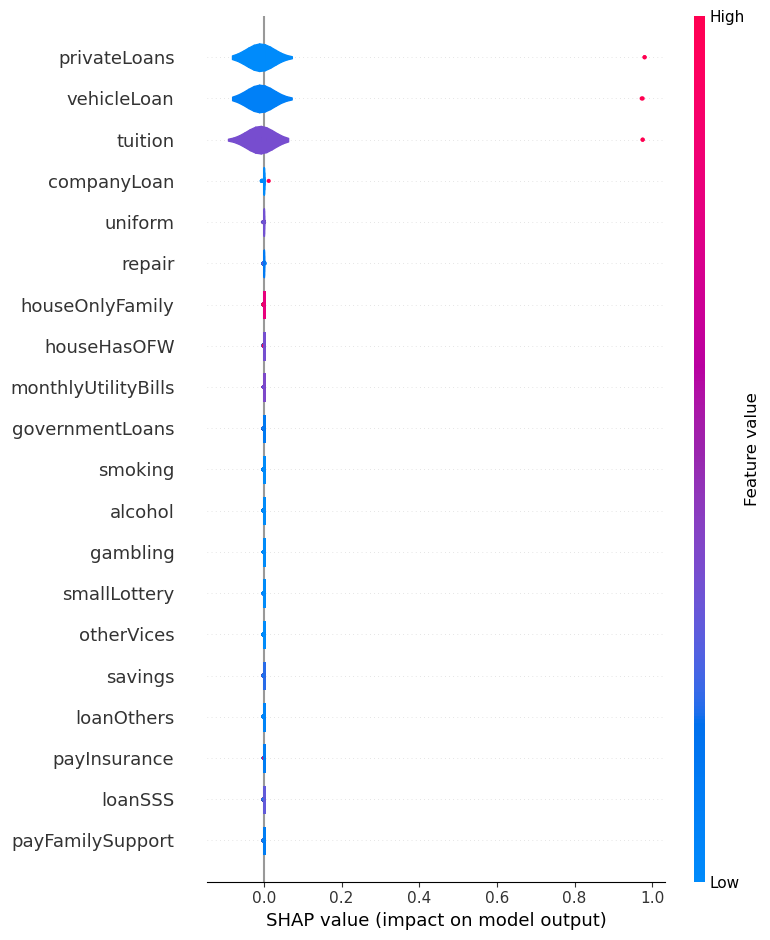

In [26]:
df = t03.copy()
# model = ho_t02_xgb_be.named_steps['classifier']
model = t03_svm_be
label_col = 'home_ownership_class'
X = df.drop(['userId', 'lastFirstName', label_col], axis=1)
y = df.loc[:, label_col]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    stratify=y,
                                                    random_state=0)

# input = ho_t12_adaboost_c0.drop(['user_id', 'lastFirstName', 'home_ownership_class'], axis=1)
# Fits the explainer
explainer = shap.Explainer(model.predict, X_test)
# explainer = shap.TreeExplainer(model=model,
#                                data=X_test,
#                                model_output='raw',
# #                                feature_perturbation='tree_path_dependent'
#                               )

# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)
# shap_values = explainer.shap_values(X_test)

feature_names = X.columns

# shap.summary_plot(shap_values, feature_names=feature_names, plot_type='dot')
shap.summary_plot(shap_values, feature_names=feature_names, plot_type='violin')

In [132]:
t03_catboost_gs, t03_catboost_be, t03_catboost_model_info, t03_catboost_metrics_df = catboost_class2(t03, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


Learning rate set to 0.009534
0:	learn: 0.6907215	total: 9.17ms	remaining: 9.16s
1:	learn: 0.6894419	total: 13.4ms	remaining: 6.68s
2:	learn: 0.6869944	total: 17.2ms	remaining: 5.72s
3:	learn: 0.6847512	total: 21.4ms	remaining: 5.32s
4:	learn: 0.6832846	total: 25.9ms	remaining: 5.15s
5:	learn: 0.6812034	total: 30.2ms	remaining: 5s
6:	learn: 0.6790220	total: 34.2ms	remaining: 4.85s
7:	learn: 0.6767542	total: 37.7ms	remaining: 4.67s
8:	learn: 0.6750134	total: 42.2ms	remaining: 4.65s
9:	learn: 0.6736859	total: 46.6ms	remaining: 4.62s
10:	learn: 0.6708656	total: 51.8ms	remaining: 4.65s
11:	learn: 0.6686952	total: 56.2ms	remaining: 4.62s
12:	learn: 0.6666132	total: 59.7ms	remaining: 4.53s
13:	learn: 0.6643226	total: 62.9ms	remaining: 4.43s
14:	learn: 0.6619944	total: 66.4ms	remaining: 4.36s
15:	learn: 0.6600451	total: 70.2ms	remaining: 4.32s
16:	learn: 0.6581778	total: 74ms	remaining: 4.28s
17:	learn: 0.6559160	total: 78ms	remaining: 4.26s
18:	learn: 0.6531309	total: 81.7ms	remaining: 4.22s

In [133]:
t03_lgbm_gs, t03_lgbm_be, t03_lgbm_model_info, t03_lgbm_metrics_df = lgbm_class2(t03, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits
[LightGBM] [Info] Number of positive: 388, number of negative: 417
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6506
[LightGBM] [Info] Number of data points in the train set: 805, number of used features: 87
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.481988 -> initscore=-0.072081
[LightGBM] [Info] Start training from score -0.072081
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [134]:
t03_gbm_gs, t03_gbm_be, t03_gbm_model_info, t03_gbm_metrics_df = gbm_class2(t03, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


Best Hyperparameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 250, 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.4527777777777778
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 GradientBoostingClassifier(min_samples_leaf=3,
                                            n_estimators=250,
                                            random_state=0))])
Mean Train Score (Precision) 0.8012069726542166
Std Train Score (Precision) 0.011930844740485589
GridSearchCV Runtime: 146.83793020248413 secs
Run 1 - Random State: 0
Test Precision: 0.34375
Run 2 - Random State: 1
Test Precision: 0.3902439024390244
Run 3 - Random State: 2
Test Precision: 0.41379310344827586
Run 4 - Random State: 3
Test Precision: 0.4782608695652174
Run 5 - Random S

In [135]:
t03_rf_gs, t03_rf_be, t03_rf_model_info, t03_rf_metrics_df = rf_class2(t03, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 480 candidates, totalling 4800 fits
Best Hyperparameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300, 'classifier__oob_score': True, 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.389325334795923
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 RandomForestClassifier(criterion='entropy', max_depth=3,
                                        min_samples_leaf=3, n_estimators=300,
                                        oob_score=True, random_state=0))])
Mean Train Score (Precision) 0.470288788729708
Std Train Score (Precision) 0.017613484423120666
GridSearchCV Runtime: 271.8552141189575 secs
Run 1 - Random State: 0
Test Precision: 0.36363636363636365
Run 2 - Random State: 1
Test Precision: 0.38095

In [136]:
t03_xgb_gs, t03_xgb_be, t03_xgb_model_info, t03_xgb_metrics_df = xgb_class2(t03, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 540 candidates, totalling 5400 fits
Best Hyperparameters: {'classifier__grow_policy': 'depthwise', 'classifier__learning_rate': 0.01, 'classifier__max_depth': None, 'classifier__max_leaves': 10, 'classifier__n_estimators': 250, 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.47000000000000003
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy='depthwise', importance_type=None,
       

In [137]:
model_vars = ['knn', 'svm', 'logreg', 'dt', 'rf', 'gbm', 'lgbm', 'xgb', 'adaboost', 'catboost']

var_df = {
    'Classifier model': [
        'k-Nearest Neighbors', 'SVM Classifier',
        'Logistic Regression', 'Decision Tree', 'Random Forest',
        'Gradient Boosting Machine (GBM)',
        'LightGBM', 'Extreme Gradient Boosting (XGBoost)',
        'AdaBoost', 'CatBoost'
    ],
    'Best Hyperparameters': [],
    'Average Val Precision': [],
    'Average Train Precision': [],
    'Stdev Train Precision': [],
    'Average Test Precision': [],
    'Stdev Test Precision': [],
    'Average Test Accuracy': [],
    'Stdev Test Accuracy': [],
    'Average Runtime': [],
    'Average Test Specificity': [],
    'Average Test Recall': [],
    'Average Test NPV': [],
    'Average Test F1-score': [],
    'Average Test G-mean': []
}

prefix = 't03_'
for name in model_vars:
    var_df['Best Hyperparameters'].append(globals()[prefix+name+'_model_info']['best_params'])
    var_df['Average Val Precision'].append(globals()[prefix+name+'_model_info']['best_cv_score'])
    var_df['Average Train Precision'].append(globals()[prefix+name+'_model_info']['mean_train_score'])
    var_df['Stdev Train Precision'].append(globals()[prefix+name+'_model_info']['std_train_score'])
    var_df['Average Test Precision'].append(globals()[prefix+name+'_model_info']['average_test_precision'])
    var_df['Stdev Test Precision'].append(globals()[prefix+name+'_model_info']['stdev_test_precision'])
    var_df['Average Test Accuracy'].append(globals()[prefix+name+'_model_info']['average_test_accuracy'])
    var_df['Stdev Test Accuracy'].append(globals()[prefix+name+'_model_info']['stdev_test_accuracy'])
    var_df['Average Runtime'].append(globals()[prefix+name+'_model_info']['average_runtime'])
    var_df['Average Test Specificity'].append(globals()[prefix+name+'_model_info']['average_test_specificity'])
    var_df['Average Test Recall'].append(globals()[prefix+name+'_model_info']['average_test_recall'])
    var_df['Average Test NPV'].append(globals()[prefix+name+'_model_info']['average_test_npv'])
    var_df['Average Test F1-score'].append(globals()[prefix+name+'_model_info']['average_test_f1_score'])
    var_df['Average Test G-mean'].append(globals()[prefix+name+'_model_info']['average_test_g_mean'])

# display(t03_model_summ)
t03_summ = pd.DataFrame(var_df)

# columns_to_exclude = ['Best Hyperparameters', 'Average Runtime']
# selected_columns = [col for col in ho_t1__summ.columns if col not in columns_to_exclude]
# ho_t1__summ[selected_columns]

t03_summ[[
    'Classifier model', 'Average Test Precision', 'Stdev Test Precision',
    'Average Val Precision', 'Average Train Precision', 'Stdev Train Precision',
    'Average Test Accuracy', 'Stdev Test Accuracy', 'Average Test Specificity',
    'Average Test Recall', 'Average Test NPV', 'Average Test F1-score', 'Average Test G-mean'
]].sort_values(by='Average Test Precision', ascending=False)

Classifier model  Average Test Precision  \
1                       SVM Classifier                0.574771   
9                             CatBoost                0.444673   
5      Gradient Boosting Machine (GBM)                0.428067   
7  Extreme Gradient Boosting (XGBoost)                0.391017   
0                  k-Nearest Neighbors                0.388831   
6                             LightGBM                0.385524   
4                        Random Forest                0.376160   
8                             AdaBoost                0.351165   
2                  Logistic Regression                0.335765   
3                        Decision Tree                0.309761   

   Stdev Test Precision  Average Val Precision  Average Train Precision  \
1              0.137838               0.435000                 0.318400   
9              0.109832               0.435794                 0.824468   
5              0.068368               0.452778                 0.801207   
7              0.074459               0.470000                 0.750464   
0              0.196826               0.416667                 0.508518   
6              0.072035               0.451524                 0.647531   
4              0.020256               0.389325                 0.470289   
8              0.040736               0.361221                 0.824265   
2              0.031085               0.350325                      NaN   
3              0.102777               0.486786                      NaN   

   Stdev Train Precision  Average Test Accuracy  Stdev Test Accuracy  \
1               0.058317               0.740741             0.008366   
9               0.008721               0.713228             0.030024   
5               0.011931               0.710053             0.025485   
7               0.015602               0.703704             0.026189   
0               0.020434               0.722751             0.020696   
6               0.020284               0.692063             0.030715   
4               0.017613               0.674074             0.008024   
8               0.009736               0.615873             0.037711   
2                    NaN               0.607407             0.024362   
3                    NaN               0.693122             0.019440   

   Average Test Specificity  Average Test Recall  Average Test NPV  \
1                  0.969784                0.104          0.750686   
9                  0.892086                0.216          0.759699   
5                  0.867626                0.272          0.768326   
7                  0.874820                0.228          0.759604   
0                  0.964029                0.052          0.738658   
6                  0.847482                0.260          0.760823   
4                  0.788489                0.356          0.773167   
8                  0.646043                0.532          0.793837   
2                  0.647482                0.496          0.781581   
3                  0.890647                0.144          0.743473   

   Average Test F1-score  Average Test G-mean  
1               0.171369             0.311017  
9               0.283832             0.436597  
5               0.329728             0.482774  
7               0.283032             0.438433  
0               0.089687             0.214798  
6               0.309385             0.468555  
4               0.365078             0.528515  
8               0.422020             0.584143  
2               0.400052             0.565596  
3               0.190754             0.343173

In [138]:
best_scores_models = {
    'Best Score': [],
    'Best Model': []
}

indices = [
    'Highest Test Accuracy',
    'Highest Test G-mean',
    'Highest Test Recall',
    'Highest Test Precision',
    'Highest Test Specificity',
    'Highest Test F1-score'
]

# Corresponding column names in your original dataframe
columns = [
    'Average Test Accuracy',
    'Average Test G-mean',
    'Average Test Recall',
    'Average Test Precision',
    'Average Test Specificity',
    'Average Test F1-score'
]

df = t03_summ
# Finding the best model for each metric
for col in columns:
    best_score = df[col].max()
    best_model = df.loc[df[col] == best_score, 'Classifier model'].values[0]
    
    best_scores_models['Best Score'].append(best_score)
    best_scores_models['Best Model'].append(best_model)

# Creating the new dataframe
best_df = pd.DataFrame(best_scores_models, index=indices)

# Displaying the new dataframe
best_df

Best Score      Best Model
Highest Test Accuracy       0.740741  SVM Classifier
Highest Test G-mean         0.584143        AdaBoost
Highest Test Recall         0.532000        AdaBoost
Highest Test Precision      0.574771  SVM Classifier
Highest Test Specificity    0.969784  SVM Classifier
Highest Test F1-score       0.422020        AdaBoost

# HO_T04: Yes - 1, 4, 30

In [139]:
t04 = dataset.copy().drop(columns=cols_with_nulls)
t04 = t04[t04['positiveMonthlyFamilyNetIncome'] != 0]
# t04_num = t04.drop(columns=['gender', 'province', 'job'])
t04 = pd.get_dummies(t04, columns=['gender'], prefix='gender', drop_first='True')
t04 = pd.get_dummies(t04, columns=['province'], prefix='province', drop_first='True')
t04 = pd.get_dummies(t04, columns=['job'], prefix='job', drop_first='True')

t04.loc[t04['basicMonthlySalary'] < 100, 'basicMonthlySalary'] *= 1000

# t04.isna().sum()[t04.isna().sum() > 0]
df = t04

## EDA on Dataset

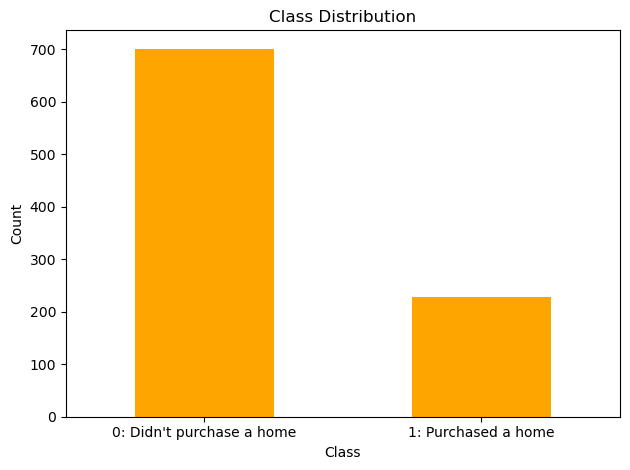

0    0.753763
1    0.246237
Name: home_ownership_class, dtype: float64

In [140]:
class_counts = df['home_ownership_class'].value_counts()
class_counts = class_counts.rename({0: "0: Didn't purchase a home",
                                    1: "1: Purchased a home"})

# Plot
class_counts.plot(kind='bar', color='orange')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
df['home_ownership_class'].value_counts(normalize=True)

## Runs: RobustScaler()

In [141]:
scaler = RobustScaler()

In [142]:
t04_adaboost_gs, t04_adaboost_be, t04_adaboost_model_info, t04_adaboost_metrics_df = adaboost_class2(t04, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


Best Hyperparameters: {'classifier__algorithm': 'SAMME', 'classifier__estimator': RandomForestClassifier(random_state=0), 'classifier__n_estimators': 200, 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.4621428571428571
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 AdaBoostClassifier(algorithm='SAMME',
                                    estimator=RandomForestClassifier(random_state=0),
                                    n_estimators=200, random_state=0))])
Mean Train Score (Precision) 0.8294920448492086
Std Train Score (Precision) 0.00967400501522148
GridSearchCV Runtime: 12.987238883972168 secs
Run 1 - Random State: 0
Test Precision: 0.4375
Run 2 - Random State: 1
Test Precision: 0.2631578947368421
Run 3 - Random State: 2
Test Precision: 0.6
Run 4 - Random State: 3
Test Precision: 0.5
Run 5 - Random State: 4
Test Precision: 0.26666666666666

In [143]:
t04_dt_gs, t04_dt_be, t04_dt_model_info, t04_dt_metrics_df = dt_class2(t04, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 1728 candidates, totalling 17280 fits



4320 fits failed out of a total of 17280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1638 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 638, in _

Best Hyperparameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 3, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'resampling': TomekLinks()}
Best Validation Score (Precision): 0.475
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()), ('resampling', TomekLinks()),
                ('classifier',
                 DecisionTreeClassifier(max_depth=3, max_features='log2',
                                        random_state=0))])
Mean Train Score (Precision) nan
Std Train Score (Precision) nan
GridSearchCV Runtime: 175.41748595237732 secs
Run 1 - Random State: 0
Test Precision: 0.5
Run 2 - Random State: 1
Test Precision: 0.2
Run 3 - Random State: 2
Test Precision: 0.0
Run 4 - Random State: 3
Test Precision: 0.2727272727272727
Run 5 - Random State: 4
Test Precision: 0.5
Ave Test Precision: 0.29454545454545455
Stdev Test Precision: 0.21248237651762678
Ave Test Accuracy: 0.7476394849785408
Stdev Test Accuracy:

In [144]:
t04_logreg_gs, t04_logreg_be, t04_logreg_model_info, t04_logreg_metrics_df = logreg_class2(t04, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 390 candidates, totalling 3900 fits



650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cholesky', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.3606836945304438
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=0.01, max_iter=1000, random_state=0,
                                    solver='newton-cholesky'))])
Mean Train Score (Precision) nan
Std Train Score (Precision) nan
GridSearchCV Runtime: 78.32454752922058 secs
Run 1 - Random State: 0
Test Precision: 0.26785714285714285
Run 2 - Random State: 1
Test Precision: 0.38095238095238093
Run 3 - Random State: 2
Test Precision: 0.3108108108108108
Run 4 - Random State: 3
Test Precision: 0.25
Run 5 - Random State: 4
Test Precision: 0.3384615384615385
Ave Test Precision: 0.3096163746163746
Stdev Test Precision: 0.05296282072022035
Ave Test Accuracy: 0.6575

In [145]:
t04_knn_gs, t04_knn_be, t04_knn_model_info, t04_knn_metrics_df = knn_class2(t04, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 600 candidates, totalling 6000 fits
Best Hyperparameters: {'classifier__metric': 'chebyshev', 'classifier__n_neighbors': 14, 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.4095634920634921
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 KNeighborsClassifier(metric='chebyshev', n_neighbors=14))])
Mean Train Score (Precision) 0.5184009666285647
Std Train Score (Precision) 0.020353909250003407
GridSearchCV Runtime: 117.01344847679138 secs
Run 1 - Random State: 0
Test Precision: 0.30434782608695654
Run 2 - Random State: 1
Test Precision: 0.36363636363636365
Run 3 - Random State: 2
Test Precision: 0.3235294117647059
Run 4 - Random State: 3
Test Precision: 0.4074074074074074
Run 5 - Random State: 4
Test Precision: 0.38461538461538464
Ave Test Precision: 0.3567072787021636
Stdev Test Precision: 0.04254309808036131
Av

In [146]:
t04_svm_gs, t04_svm_be, t04_svm_model_info, t04_svm_metrics_df = svm_class2(t04, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 520 candidates, totalling 5200 fits


[LibSVM]Best Hyperparameters: {'classifier__C': 0.01, 'classifier__kernel': 'poly', 'classifier__probability': True, 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.5178571428571429
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 SVC(C=0.01, kernel='poly', max_iter=1000, probability=True,
                     random_state=0, verbose=True))])
Mean Train Score (Precision) 0.2928532241988599
Std Train Score (Precision) 0.045312409729928255
GridSearchCV Runtime: 118.67763948440552 secs
[LibSVM]Run 1 - Random State: 0
Test Precision: 0.2
[LibSVM]Run 2 - Random State: 1
Test Precision: 0.6
[LibSVM]Run 3 - Random State: 2
Test Precision: 0.375
[LibSVM]Run 4 - Random State: 3
Test Precision: 0.46153846153846156
[LibSVM]Run 5 - Random State: 4
Test Precision: 0.25
Ave Test Precision: 0.3773076923076923
Stdev Test Precision: 0.16150640707608852
Ave 

In [147]:
t04_catboost_gs, t04_catboost_be, t04_catboost_model_info, t04_catboost_metrics_df = catboost_class2(t04, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


Learning rate set to 0.010519
0:	learn: 0.6903989	total: 3.94ms	remaining: 3.94s
1:	learn: 0.6889158	total: 7.21ms	remaining: 3.6s
2:	learn: 0.6870569	total: 10ms	remaining: 3.33s
3:	learn: 0.6838928	total: 13.4ms	remaining: 3.32s
4:	learn: 0.6812249	total: 16.2ms	remaining: 3.23s
5:	learn: 0.6782290	total: 29ms	remaining: 4.8s
6:	learn: 0.6747665	total: 31.2ms	remaining: 4.43s
7:	learn: 0.6721902	total: 33.7ms	remaining: 4.17s
8:	learn: 0.6689030	total: 36.3ms	remaining: 3.99s
9:	learn: 0.6665661	total: 39.1ms	remaining: 3.87s
10:	learn: 0.6645767	total: 41.9ms	remaining: 3.77s
11:	learn: 0.6628340	total: 44.8ms	remaining: 3.69s
12:	learn: 0.6602754	total: 47.2ms	remaining: 3.58s
13:	learn: 0.6583808	total: 49.8ms	remaining: 3.5s
14:	learn: 0.6561540	total: 52.2ms	remaining: 3.43s
15:	learn: 0.6538263	total: 54.9ms	remaining: 3.37s
16:	learn: 0.6518122	total: 57.5ms	remaining: 3.32s
17:	learn: 0.6488552	total: 60.3ms	remaining: 3.29s
18:	learn: 0.6468323	total: 63ms	remaining: 3.25s
1

In [148]:
t04_lgbm_gs, t04_lgbm_be, t04_lgbm_model_info, t04_lgbm_metrics_df = lgbm_class2(t04, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits
[LightGBM] [Info] Number of positive: 525, number of negative: 525
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9442
[LightGBM] [Info] Number of data points in the train set: 1050, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

In [149]:
t04_gbm_gs, t04_gbm_be, t04_gbm_model_info, t04_gbm_metrics_df = gbm_class2(t04, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


Best Hyperparameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 250, 'resampling': RandomOverSampler(random_state=0)}
Best Validation Score (Precision): 0.41590590695853846
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomOverSampler(random_state=0)),
                ('classifier',
                 GradientBoostingClassifier(min_samples_leaf=2,
                                            n_estimators=250,
                                            random_state=0))])
Mean Train Score (Precision) 0.8024276828090414
Std Train Score (Precision) 0.013614838079871124
GridSearchCV Runtime: 163.10757398605347 secs
Run 1 - Random State: 0
Test Precision: 0.2619047619047619
Run 2 - Random State: 1
Test Precision: 0.4791666666666667
Run 3 - Random State: 2
Test Precision: 0.4153846153846154
Run 4 - Random State: 3
Test Precision: 

In [150]:
t04_rf_gs, t04_rf_be, t04_rf_model_info, t04_rf_metrics_df = rf_class2(t04, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 480 candidates, totalling 4800 fits


Best Hyperparameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200, 'classifier__oob_score': True, 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.38683423301844355
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 RandomForestClassifier(criterion='entropy', max_depth=3,
                                        min_samples_leaf=3, n_estimators=200,
                                        oob_score=True, random_state=0))])
Mean Train Score (Precision) 0.45539795368599745
Std Train Score (Precision) 0.021006027316379558
GridSearchCV Runtime: 279.6875946521759 secs
Run 1 - Random State: 0
Test Precision: 0.3
Run 2 - Random State: 1
Test Precision: 0.39622641509433965
Run 3 - Random State: 2
Test Precision: 0.3285714285714285

In [151]:
t04_xgb_gs, t04_xgb_be, t04_xgb_model_info, t04_xgb_metrics_df = xgb_class2(t04, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 540 candidates, totalling 5400 fits
Best Hyperparameters: {'classifier__grow_policy': 'depthwise', 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__max_leaves': 10, 'classifier__n_estimators': 250, 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.4373393857604384
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy='depthwise', importance_type=None,
            

In [152]:
model_vars = ['knn', 'svm', 'logreg', 'dt', 'rf', 'gbm', 'lgbm', 'xgb', 'adaboost', 'catboost']

var_df = {
    'Classifier model': [
        'k-Nearest Neighbors', 'SVM Classifier',
        'Logistic Regression', 'Decision Tree', 'Random Forest',
        'Gradient Boosting Machine (GBM)',
        'LightGBM', 'Extreme Gradient Boosting (XGBoost)',
        'AdaBoost', 'CatBoost'
    ],
    'Best Hyperparameters': [],
    'Average Val Precision': [],
    'Average Train Precision': [],
    'Stdev Train Precision': [],
    'Average Test Precision': [],
    'Stdev Test Precision': [],
    'Average Test Accuracy': [],
    'Stdev Test Accuracy': [],
    'Average Runtime': [],
    'Average Test Specificity': [],
    'Average Test Recall': [],
    'Average Test NPV': [],
    'Average Test F1-score': [],
    'Average Test G-mean': []
}

prefix = 't04_'
for name in model_vars:
    var_df['Best Hyperparameters'].append(globals()[prefix+name+'_model_info']['best_params'])
    var_df['Average Val Precision'].append(globals()[prefix+name+'_model_info']['best_cv_score'])
    var_df['Average Train Precision'].append(globals()[prefix+name+'_model_info']['mean_train_score'])
    var_df['Stdev Train Precision'].append(globals()[prefix+name+'_model_info']['std_train_score'])
    var_df['Average Test Precision'].append(globals()[prefix+name+'_model_info']['average_test_precision'])
    var_df['Stdev Test Precision'].append(globals()[prefix+name+'_model_info']['stdev_test_precision'])
    var_df['Average Test Accuracy'].append(globals()[prefix+name+'_model_info']['average_test_accuracy'])
    var_df['Stdev Test Accuracy'].append(globals()[prefix+name+'_model_info']['stdev_test_accuracy'])
    var_df['Average Runtime'].append(globals()[prefix+name+'_model_info']['average_runtime'])
    var_df['Average Test Specificity'].append(globals()[prefix+name+'_model_info']['average_test_specificity'])
    var_df['Average Test Recall'].append(globals()[prefix+name+'_model_info']['average_test_recall'])
    var_df['Average Test NPV'].append(globals()[prefix+name+'_model_info']['average_test_npv'])
    var_df['Average Test F1-score'].append(globals()[prefix+name+'_model_info']['average_test_f1_score'])
    var_df['Average Test G-mean'].append(globals()[prefix+name+'_model_info']['average_test_g_mean'])

# display(t04_model_summ)
t04_summ = pd.DataFrame(var_df)

# columns_to_exclude = ['Best Hyperparameters', 'Average Runtime']
# selected_columns = [col for col in ho_t1__summ.columns if col not in columns_to_exclude]
# ho_t1__summ[selected_columns]

t04_summ[[
    'Classifier model', 'Average Test Precision', 'Stdev Test Precision',
    'Average Val Precision', 'Average Train Precision', 'Stdev Train Precision',
    'Average Test Accuracy', 'Stdev Test Accuracy', 'Average Test Specificity',
    'Average Test Recall', 'Average Test NPV', 'Average Test F1-score', 'Average Test G-mean'
]].sort_values(by='Average Test Precision', ascending=False)

Classifier model  Average Test Precision  \
9                             CatBoost                0.473768   
6                             LightGBM                0.469260   
7  Extreme Gradient Boosting (XGBoost)                0.436429   
8                             AdaBoost                0.413465   
5      Gradient Boosting Machine (GBM)                0.385615   
1                       SVM Classifier                0.377308   
4                        Random Forest                0.366956   
0                  k-Nearest Neighbors                0.356707   
2                  Logistic Regression                0.309616   
3                        Decision Tree                0.294545   

   Stdev Test Precision  Average Val Precision  Average Train Precision  \
9              0.130353               0.427500                 0.841889   
6              0.091791               0.465945                 0.653533   
7              0.071966               0.437339                 0.758173   
8              0.147482               0.462143                 0.829492   
5              0.092725               0.415906                 0.802428   
1              0.161506               0.517857                 0.292853   
4              0.049731               0.386834                 0.455398   
0              0.042543               0.409563                 0.518401   
2              0.052963               0.360684                      NaN   
3              0.212482               0.475000                      NaN   

   Stdev Train Precision  Average Test Accuracy  Stdev Test Accuracy  \
9               0.009184               0.744206             0.033465   
6               0.021323               0.745064             0.022832   
7               0.015230               0.735622             0.022218   
8               0.009674               0.744206             0.024011   
5               0.013615               0.710730             0.032203   
1               0.045312               0.744206             0.014743   
4               0.021006               0.694421             0.031742   
0               0.020354               0.722747             0.012365   
2                    NaN               0.657511             0.021758   
3                    NaN               0.747639             0.009304   

   Average Test Specificity  Average Test Recall  Average Test NPV  \
9                  0.904545             0.249123          0.787916   
6                  0.917045             0.214035          0.782681   
7                  0.893182             0.249123          0.785924   
8                  0.937500             0.147368          0.772709   
5                  0.834091             0.329825          0.794375   
1                  0.962500             0.070175          0.761700   
4                  0.813636             0.326316          0.788609   
0                  0.903409             0.164912          0.769633   
2                  0.761364             0.336842          0.780636   
3                  0.982955             0.021053          0.756121   

   Average Test F1-score  Average Test G-mean  
9               0.324657             0.474042  
6               0.291082             0.441940  
7               0.316080             0.471218  
8               0.215761             0.361111  
5               0.352857             0.516994  
1               0.117900             0.254255  
4               0.342267             0.512742  
0               0.224432             0.384272  
2               0.321172             0.501279  
3               0.037658             0.123847

In [153]:
best_scores_models = {
    'Best Score': [],
    'Best Model': []
}

indices = [
    'Highest Test Accuracy',
    'Highest Test G-mean',
    'Highest Test Recall',
    'Highest Test Precision',
    'Highest Test Specificity',
    'Highest Test F1-score'
]

# Corresponding column names in your original dataframe
columns = [
    'Average Test Accuracy',
    'Average Test G-mean',
    'Average Test Recall',
    'Average Test Precision',
    'Average Test Specificity',
    'Average Test F1-score'
]

df = t04_summ
# Finding the best model for each metric
for col in columns:
    best_score = df[col].max()
    best_model = df.loc[df[col] == best_score, 'Classifier model'].values[0]
    
    best_scores_models['Best Score'].append(best_score)
    best_scores_models['Best Model'].append(best_model)

# Creating the new dataframe
best_df = pd.DataFrame(best_scores_models, index=indices)

# Displaying the new dataframe
best_df

Best Score                       Best Model
Highest Test Accuracy       0.747639                    Decision Tree
Highest Test G-mean         0.516994  Gradient Boosting Machine (GBM)
Highest Test Recall         0.336842              Logistic Regression
Highest Test Precision      0.473768                         CatBoost
Highest Test Specificity    0.982955                    Decision Tree
Highest Test F1-score       0.352857  Gradient Boosting Machine (GBM)

# HO_T05: Yes - 1, 6, 30

In [173]:
t05 = dataset.copy().drop(columns=cols_with_nulls)
t05 = t05[t05['positiveMonthlyFamilyNetIncomeWithSavings'] != 0]
# t05_num = t05.drop(columns=['gender', 'province', 'job'])
t05 = pd.get_dummies(t05, columns=['gender'], prefix='gender', drop_first='True')
t05 = pd.get_dummies(t05, columns=['province'], prefix='province', drop_first='True')
t05 = pd.get_dummies(t05, columns=['job'], prefix='job', drop_first='True')

t05.loc[t05['basicMonthlySalary'] < 100, 'basicMonthlySalary'] *= 1000

# t05.isna().sum()[t05.isna().sum() > 0]
df = t05

## EDA on Dataset

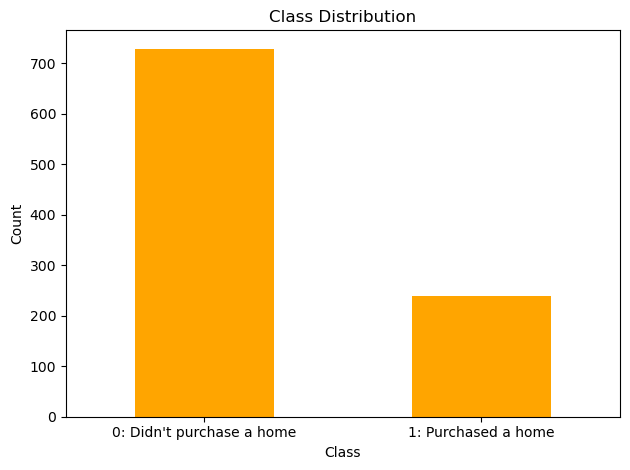

0    729
1    240
Name: home_ownership_class, dtype: int64

0    0.752322
1    0.247678
Name: home_ownership_class, dtype: float64

In [174]:
class_counts = df['home_ownership_class'].value_counts()
class_counts = class_counts.rename({0: "0: Didn't purchase a home",
                                    1: "1: Purchased a home"})

# Plot
class_counts.plot(kind='bar', color='orange')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

display(df['home_ownership_class'].value_counts())
display(df['home_ownership_class'].value_counts(normalize=True))

## Runs: RobustScaler()

In [175]:
scaler = RobustScaler()

In [176]:
t05_adaboost_gs, t05_adaboost_be, t05_adaboost_model_info, t05_adaboost_metrics_df = adaboost_class2(t05, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 40 candidates, totalling 400 fits
Best Hyperparameters: {'classifier__algorithm': 'SAMME', 'classifier__estimator': RandomForestClassifier(random_state=0), 'classifier__n_estimators': 200, 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.4373809523809524
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 AdaBoostClassifier(algorithm='SAMME',
                                    estimator=RandomForestClassifier(random_state=0),
                                    n_estimators=200, random_state=0))])
Mean Train Score (Precision) 0.8357385523909417
Std Train Score (Precision) 0.007038361744379639
GridSearchCV Runtime: 11.565620422363281 secs
Run 1 - Random State: 0
Test Precision: 0.2727272727272727
Run 2 - Random State: 1
Test Precision: 0.5
Run 3 - Random State: 2
Test Precision: 0.35294117647058826
Run 4 - Random State: 3

In [177]:
t05_dt_gs, t05_dt_be, t05_dt_model_info, t05_dt_metrics_df = dt_class2(t05, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 1728 candidates, totalling 17280 fits



4320 fits failed out of a total of 17280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1646 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 638, in _

Best Hyperparameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 3, 'resampling': TomekLinks()}
Best Validation Score (Precision): 0.5816666666666667
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()), ('resampling', TomekLinks()),
                ('classifier',
                 DecisionTreeClassifier(max_depth=5, max_features='log2',
                                        min_samples_split=3, random_state=0))])
Mean Train Score (Precision) nan
Std Train Score (Precision) nan
GridSearchCV Runtime: 175.6611979007721 secs
Run 1 - Random State: 0
Test Precision: 0.25925925925925924
Run 2 - Random State: 1
Test Precision: 0.32
Run 3 - Random State: 2
Test Precision: 0.45161290322580644
Run 4 - Random State: 3
Test Precision: 0.2727272727272727
Run 5 - Random State: 4
Test Precision: 0.36363636363636365
Ave Test Precision: 0.33344715976974043
Stdev Test Precisi

In [178]:
t05_logreg_gs, t05_logreg_be, t05_logreg_model_info, t05_logreg_metrics_df = logreg_class2(t05, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 390 candidates, totalling 3900 fits



650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1000000.0, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.3318673891116347
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1000000.0, max_iter=1000,
                                    random_state=0))])
Mean Train Score (Precision) nan
Std Train Score (Precision) nan
GridSearchCV Runtime: 91.809809923172 secs


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Run 1 - Random State: 0
Test Precision: 0.26744186046511625


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Run 2 - Random State: 1
Test Precision: 0.2631578947368421


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Run 3 - Random State: 2
Test Precision: 0.3157894736842105


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Run 4 - Random State: 3
Test Precision: 0.30337078651685395
Run 5 - Random State: 4
Test Precision: 0.3218390804597701
Ave Test Precision: 0.29431981917255856
Stdev Test Precision: 0.027357202046843603
Ave Test Accuracy: 0.6
Stdev Test Accuracy: 0.022237458577952774
Ave Test Specificity: 0.6513661202185792
Ave Test Recall: 0.44333333333333336
Ave Test NPV: 0.7811456203175948
Ave Test F1-Score: 0.35362288016809096
Ave Test G-mean: 0.5368408785037511
Ave Runtime: 0.4122814655303955


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [179]:
t05_knn_gs, t05_knn_be, t05_knn_model_info, t05_knn_metrics_df = knn_class2(t05, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 600 candidates, totalling 6000 fits
Best Hyperparameters: {'classifier__metric': 'canberra', 'classifier__n_neighbors': 4, 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.4671428571428572
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 KNeighborsClassifier(metric='canberra', n_neighbors=4))])
Mean Train Score (Precision) 0.510831344789161
Std Train Score (Precision) 0.01777374659047525
GridSearchCV Runtime: 131.31046557426453 secs
Run 1 - Random State: 0
Test Precision: 0.2692307692307692
Run 2 - Random State: 1
Test Precision: 0.3333333333333333
Run 3 - Random State: 2
Test Precision: 0.3
Run 4 - Random State: 3
Test Precision: 0.2
Run 5 - Random State: 4
Test Precision: 0.35714285714285715
Ave Test Precision: 0.2919413919413919
Stdev Test Precision: 0.061234093805001624
Ave Test Accuracy: 0.716872427983539
Stdev Te

In [180]:
t05_svm_gs, t05_svm_be, t05_svm_model_info, t05_svm_metrics_df = svm_class2(t05, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 520 candidates, totalling 5200 fits
[LibSVM]Best Hyperparameters: {'classifier__C': 10.0, 'classifier__kernel': 'poly', 'classifier__probability': True, 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.4425155279503105
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 SVC(C=10.0, kernel='poly', max_iter=1000, probability=True,
                     random_state=0, verbose=True))])
Mean Train Score (Precision) 0.3289361635952379
Std Train Score (Precision) 0.05567792577720627
GridSearchCV Runtime: 135.91065764427185 secs
[LibSVM]Run 1 - Random State: 0
Test Precision: 0.23275862068965517
[LibSVM]

Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


Run 2 - Random State: 1
Test Precision: 0.23076923076923078
[LibSVM]Run 3 - Random State: 2
Test Precision: 0.375
[LibSVM]

Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


Run 4 - Random State: 3
Test Precision: 0.5
[LibSVM]Run 5 - Random State: 4
Test Precision: 0.4
Ave Test Precision: 0.3477055702917772
Stdev Test Precision: 0.11571537853233169
Ave Test Accuracy: 0.640329218106996
Stdev Test Accuracy: 0.22248117818476248
Ave Test Specificity: 0.7683060109289618
Ave Test Recall: 0.25
Ave Test NPV: 0.6998831335053081
Ave Test F1-Score: 0.18695231228756826
Ave Test G-mean: 0.25853978862093163
Ave Runtime: 0.09213747978210449


In [181]:
t05_catboost_gs, t05_catboost_be, t05_catboost_model_info, t05_catboost_metrics_df = catboost_class2(t05, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


Learning rate set to 0.010697
0:	learn: 0.6881058	total: 5.65ms	remaining: 5.64s
1:	learn: 0.6837970	total: 10.3ms	remaining: 5.14s
2:	learn: 0.6805376	total: 14.3ms	remaining: 4.75s
3:	learn: 0.6771407	total: 18ms	remaining: 4.47s
4:	learn: 0.6739950	total: 22.2ms	remaining: 4.41s
5:	learn: 0.6696167	total: 26.1ms	remaining: 4.32s
6:	learn: 0.6661457	total: 29.8ms	remaining: 4.23s
7:	learn: 0.6626950	total: 33.9ms	remaining: 4.2s
8:	learn: 0.6581239	total: 37.9ms	remaining: 4.17s
9:	learn: 0.6545212	total: 42.2ms	remaining: 4.18s
10:	learn: 0.6513000	total: 46.4ms	remaining: 4.17s
11:	learn: 0.6479311	total: 50ms	remaining: 4.12s
12:	learn: 0.6447007	total: 54ms	remaining: 4.1s
13:	learn: 0.6420364	total: 58.1ms	remaining: 4.09s
14:	learn: 0.6390906	total: 62.1ms	remaining: 4.08s
15:	learn: 0.6362662	total: 65.8ms	remaining: 4.04s
16:	learn: 0.6319891	total: 69.5ms	remaining: 4.02s
17:	learn: 0.6288525	total: 73.3ms	remaining: 4s
18:	learn: 0.6258186	total: 77.3ms	remaining: 3.99s
19:

In [182]:
t05_lgbm_gs, t05_lgbm_be, t05_lgbm_model_info, t05_lgbm_metrics_df = lgbm_class2(t05, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


[LightGBM] [Info] Number of positive: 552, number of negative: 546
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9702
[LightGBM] [Info] Number of data points in the train set: 1098, number of used features: 91
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502732 -> initscore=0.010929
[LightGBM] [Info] Start training from score 0.010929
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [183]:
t05_gbm_gs, t05_gbm_be, t05_gbm_model_info, t05_gbm_metrics_df = gbm_class2(t05, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


Best Hyperparameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200, 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.5035164835164835
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 GradientBoostingClassifier(min_samples_leaf=2,
                                            n_estimators=200,
                                            random_state=0))])
Mean Train Score (Precision) 0.8037453109344085
Std Train Score (Precision) 0.011359159608939191
GridSearchCV Runtime: 197.48946714401245 secs
Run 1 - Random State: 0
Test Precision: 0.24324324324324326
Run 2 - Random State: 1
Test Precision: 0.28205128205128205
Run 3 - Random State: 2
Test Precision: 0.4
Run 4 - Random State: 3
Test Precision: 0.4
Run 5 - Random State: 4
Test Pre

In [184]:
t05_rf_gs, t05_rf_be, t05_rf_model_info, t05_rf_metrics_df = rf_class2(t05, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 480 candidates, totalling 4800 fits
Best Hyperparameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 2, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300, 'classifier__oob_score': True, 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.42946733821733823
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 RandomForestClassifier(max_depth=2, min_samples_leaf=3,
                                        n_estimators=300, oob_score=True,
                                        random_state=0))])
Mean Train Score (Precision) 0.46398335741835106
Std Train Score (Precision) 0.019183186764795936
GridSearchCV Runtime: 299.90009784698486 secs
Run 1 - Random State: 0
Test Precision: 0.3055555555555556
Run 2 - Random State: 1
Test Precision: 0.41379310344827586
R

In [185]:
t05_xgb_gs, t05_xgb_be, t05_xgb_model_info, t05_xgb_metrics_df = xgb_class2(t05, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 540 candidates, totalling 5400 fits


Best Hyperparameters: {'classifier__grow_policy': 'depthwise', 'classifier__learning_rate': 1, 'classifier__max_depth': 3, 'classifier__max_leaves': 10, 'classifier__n_estimators': 200, 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.5207287157287157
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints=None, learning_rate=1,
 

In [186]:
model_vars = ['knn', 'svm', 'logreg', 'dt', 'rf', 'gbm', 'lgbm', 'xgb', 'adaboost', 'catboost']

var_df = {
    'Classifier model': [
        'k-Nearest Neighbors', 'SVM Classifier',
        'Logistic Regression', 'Decision Tree', 'Random Forest',
        'Gradient Boosting Machine (GBM)',
        'LightGBM', 'Extreme Gradient Boosting (XGBoost)',
        'AdaBoost', 'CatBoost'
    ],
    'Best Hyperparameters': [],
    'Average Val Precision': [],
    'Average Train Precision': [],
    'Stdev Train Precision': [],
    'Average Test Precision': [],
    'Stdev Test Precision': [],
    'Average Test Accuracy': [],
    'Stdev Test Accuracy': [],
    'Average Runtime': [],
    'Average Test Specificity': [],
    'Average Test Recall': [],
    'Average Test NPV': [],
    'Average Test F1-score': [],
    'Average Test G-mean': []
}

prefix = 't05_'
for name in model_vars:
    var_df['Best Hyperparameters'].append(globals()[prefix+name+'_model_info']['best_params'])
    var_df['Average Val Precision'].append(globals()[prefix+name+'_model_info']['best_cv_score'])
    var_df['Average Train Precision'].append(globals()[prefix+name+'_model_info']['mean_train_score'])
    var_df['Stdev Train Precision'].append(globals()[prefix+name+'_model_info']['std_train_score'])
    var_df['Average Test Precision'].append(globals()[prefix+name+'_model_info']['average_test_precision'])
    var_df['Stdev Test Precision'].append(globals()[prefix+name+'_model_info']['stdev_test_precision'])
    var_df['Average Test Accuracy'].append(globals()[prefix+name+'_model_info']['average_test_accuracy'])
    var_df['Stdev Test Accuracy'].append(globals()[prefix+name+'_model_info']['stdev_test_accuracy'])
    var_df['Average Runtime'].append(globals()[prefix+name+'_model_info']['average_runtime'])
    var_df['Average Test Specificity'].append(globals()[prefix+name+'_model_info']['average_test_specificity'])
    var_df['Average Test Recall'].append(globals()[prefix+name+'_model_info']['average_test_recall'])
    var_df['Average Test NPV'].append(globals()[prefix+name+'_model_info']['average_test_npv'])
    var_df['Average Test F1-score'].append(globals()[prefix+name+'_model_info']['average_test_f1_score'])
    var_df['Average Test G-mean'].append(globals()[prefix+name+'_model_info']['average_test_g_mean'])

# display(t05_model_summ)
t05_summ = pd.DataFrame(var_df)

# columns_to_exclude = ['Best Hyperparameters', 'Average Runtime']
# selected_columns = [col for col in ho_t1__summ.columns if col not in columns_to_exclude]
# ho_t1__summ[selected_columns]

t05_summ[[
    'Classifier model', 'Average Test Precision', 'Stdev Test Precision',
    'Average Val Precision', 'Average Train Precision', 'Stdev Train Precision',
    'Average Test Accuracy', 'Stdev Test Accuracy', 'Average Test Specificity',
    'Average Test Recall', 'Average Test NPV', 'Average Test F1-score', 'Average Test G-mean'
]].sort_values(by='Average Test Precision', ascending=False)

Classifier model  Average Test Precision  \
6                             LightGBM                0.477165   
9                             CatBoost                0.390870   
8                             AdaBoost                0.382057   
7  Extreme Gradient Boosting (XGBoost)                0.375050   
4                        Random Forest                0.368655   
1                       SVM Classifier                0.347706   
5      Gradient Boosting Machine (GBM)                0.346540   
3                        Decision Tree                0.333447   
2                  Logistic Regression                0.294320   
0                  k-Nearest Neighbors                0.291941   

   Stdev Test Precision  Average Val Precision  Average Train Precision  \
6              0.161409               0.536319                 0.659509   
9              0.143599               0.488333                 0.842542   
8              0.082219               0.437381                 0.835739   
7              0.050990               0.520729                 0.760115   
4              0.062939               0.429467                 0.463983   
1              0.115715               0.442516                 0.328936   
5              0.077862               0.503516                 0.803745   
3              0.077856               0.581667                      NaN   
2              0.027357               0.331867                      NaN   
0              0.061234               0.467143                 0.510831   

   Stdev Train Precision  Average Test Accuracy  Stdev Test Accuracy  \
6               0.018183               0.744033             0.035805   
9               0.009258               0.729218             0.027359   
8               0.007038               0.733333             0.015232   
7               0.013648               0.705350             0.021892   
4               0.019183               0.699588             0.029959   
1               0.055678               0.640329             0.222481   
5               0.011359               0.709465             0.028152   
3                    NaN               0.725926             0.017843   
2                    NaN               0.600000             0.022237   
0               0.017774               0.716872             0.013772   

   Average Test Specificity  Average Test Recall  Average Test NPV  \
6                  0.926776             0.186667          0.776333   
9                  0.923497             0.136667          0.765251   
8                  0.934426             0.120000          0.764077   
7                  0.843716             0.283333          0.782133   
4                  0.829508             0.303333          0.784382   
1                  0.768306             0.250000          0.699883   
5                  0.881967             0.183333          0.766974   
3                  0.924590             0.120000          0.762409   
2                  0.651366             0.443333          0.781146   
0                  0.919126             0.100000          0.756974   

   Average Test F1-score  Average Test G-mean  
6               0.267105             0.414813  
9               0.201042             0.354644  
8               0.181054             0.332818  
7               0.322070             0.488189  
4               0.329693             0.496901  
1               0.186952             0.258540  
5               0.238139             0.401034  
3               0.170806             0.320415  
2               0.353623             0.536841  
0               0.147680             0.300840

In [187]:
best_scores_models = {
    'Best Score': [],
    'Best Model': []
}

indices = [
    'Highest Test Accuracy',
    'Highest Test G-mean',
    'Highest Test Recall',
    'Highest Test Precision',
    'Highest Test Specificity',
    'Highest Test F1-score'
]

# Corresponding column names in your original dataframe
columns = [
    'Average Test Accuracy',
    'Average Test G-mean',
    'Average Test Recall',
    'Average Test Precision',
    'Average Test Specificity',
    'Average Test F1-score'
]

df = t05_summ
# Finding the best model for each metric
for col in columns:
    best_score = df[col].max()
    best_model = df.loc[df[col] == best_score, 'Classifier model'].values[0]
    
    best_scores_models['Best Score'].append(best_score)
    best_scores_models['Best Model'].append(best_model)

# Creating the new dataframe
best_df = pd.DataFrame(best_scores_models, index=indices)

# Displaying the new dataframe
best_df

Best Score           Best Model
Highest Test Accuracy       0.744033             LightGBM
Highest Test G-mean         0.536841  Logistic Regression
Highest Test Recall         0.443333  Logistic Regression
Highest Test Precision      0.477165             LightGBM
Highest Test Specificity    0.934426             AdaBoost
Highest Test F1-score       0.353623  Logistic Regression

# HO_T06: Yes - 1, 5, 30

In [157]:
t06 = dataset.copy().drop(columns=cols_with_nulls)
t06 = t06[t06['positiveMonthlySoloNetIncomeWithSavings'] != 0]
# t06_num = t06.drop(columns=['gender', 'province', 'job'])
t06 = pd.get_dummies(t06, columns=['gender'], prefix='gender', drop_first='True')
t06 = pd.get_dummies(t06, columns=['province'], prefix='province', drop_first='True')
t06 = pd.get_dummies(t06, columns=['job'], prefix='job', drop_first='True')

t06.loc[t06['basicMonthlySalary'] < 100, 'basicMonthlySalary'] *= 1000

# t06.isna().sum()[t06.isna().sum() > 0]
df = t06

## EDA on Dataset

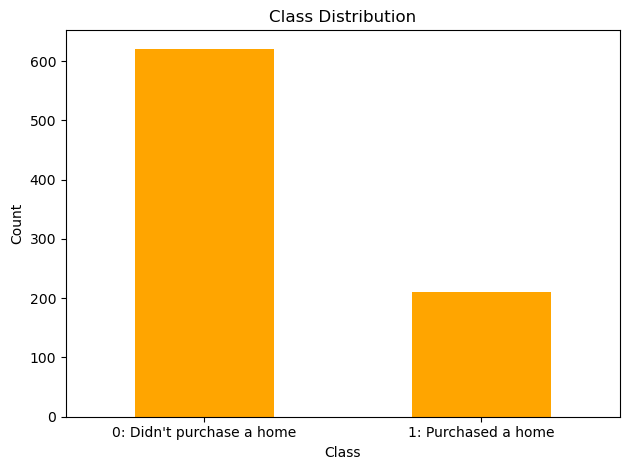

0    621
1    211
Name: home_ownership_class, dtype: int64

0    0.746394
1    0.253606
Name: home_ownership_class, dtype: float64

In [158]:
class_counts = df['home_ownership_class'].value_counts()
class_counts = class_counts.rename({0: "0: Didn't purchase a home",
                                    1: "1: Purchased a home"})

# Plot
class_counts.plot(kind='bar', color='orange')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

display(df['home_ownership_class'].value_counts())
display(df['home_ownership_class'].value_counts(normalize=True))

## Runs: RobustScaler()

In [159]:
scaler = RobustScaler()

In [160]:
t06_adaboost_gs, t06_adaboost_be, t06_adaboost_model_info, t06_adaboost_metrics_df = adaboost_class2(t06, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


Best Hyperparameters: {'classifier__algorithm': 'SAMME', 'classifier__estimator': RandomForestClassifier(random_state=0), 'classifier__n_estimators': 200, 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.4990620490620491
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 AdaBoostClassifier(algorithm='SAMME',
                                    estimator=RandomForestClassifier(random_state=0),
                                    n_estimators=200, random_state=0))])
Mean Train Score (Precision) 0.8301455283599143
Std Train Score (Precision) 0.009585290503574175
GridSearchCV Runtime: 13.497385025024414 secs
Run 1 - Random State: 0
Test Precision: 0.47058823529411764
Run 2 - Random State: 1
Test Precision: 0.46153846153846156
Run 3 - Random State: 2
Test Precision: 0.5
Run 4 - Random State: 3
Test Precision: 0.35714285714285715
Run 5 - Random State: 4
Tes

In [161]:
t06_dt_gs, t06_dt_be, t06_dt_model_info, t06_dt_metrics_df = dt_class2(t06, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 1728 candidates, totalling 17280 fits



4320 fits failed out of a total of 17280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2658 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 638, in _

Best Hyperparameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 2, 'classifier__max_features': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'resampling': TomekLinks()}
Best Validation Score (Precision): 0.4625274725274725
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()), ('resampling', TomekLinks()),
                ('classifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=2,
                                        random_state=0))])
Mean Train Score (Precision) nan
Std Train Score (Precision) nan
GridSearchCV Runtime: 149.53036236763 secs
Run 1 - Random State: 0
Test Precision: 0.358974358974359
Run 2 - Random State: 1
Test Precision: 0.3103448275862069
Run 3 - Random State: 2
Test Precision: 0.5
Run 4 - Random State: 3
Test Precision: 0.0
Run 5 - Random State: 4
Test Precision: 0.0
Ave Test Precision: 0.2338638373121132
Stdev Test Precision: 0.2245634823378635
Ave Test Accuracy: 0.72211538461538

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


In [162]:
t06_logreg_gs, t06_logreg_be, t06_logreg_model_info, t06_logreg_metrics_df = logreg_class2(t06, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 390 candidates, totalling 3900 fits



650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cholesky', 'resampling': RandomUnderSampler(random_state=0)}
Best Validation Score (Precision): 0.3196445258348154
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomUnderSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=0.01, max_iter=1000, random_state=0,
                                    solver='newton-cholesky'))])
Mean Train Score (Precision) nan
Std Train Score (Precision) nan
GridSearchCV Runtime: 79.15805983543396 secs
Run 1 - Random State: 0
Test Precision: 0.3125
Run 2 - Random State: 1
Test Precision: 0.32894736842105265
Run 3 - Random State: 2
Test Precision: 0.2916666666666667
Run 4 - Random State: 3
Test Precision: 0.30434782608695654
Run 5 - Random State: 4
Test Precision: 0.2602739726027397
Ave Test Precision: 0.2995471667554831
Stdev Test Precision: 0.025786043403662168
Ave 

In [163]:
t06_knn_gs, t06_knn_be, t06_knn_model_info, t06_knn_metrics_df = knn_class2(t06, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 600 candidates, totalling 6000 fits


Best Hyperparameters: {'classifier__metric': 'hamming', 'classifier__n_neighbors': 9, 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.425
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 KNeighborsClassifier(metric='hamming', n_neighbors=9))])
Mean Train Score (Precision) 0.5130288571493267
Std Train Score (Precision) 0.02027822790520964
GridSearchCV Runtime: 106.09028911590576 secs
Run 1 - Random State: 0
Test Precision: 0.2
Run 2 - Random State: 1
Test Precision: 0.6666666666666666
Run 3 - Random State: 2
Test Precision: 0.16666666666666666
Run 4 - Random State: 3
Test Precision: 0.18181818181818182
Run 5 - Random State: 4
Test Precision: 0.26666666666666666
Ave Test Precision: 0.2963636363636364
Stdev Test Precision: 0.21049593807221928
Ave Test Accuracy: 0.716346153846154
Stdev Test Accuracy: 0.02427765610183191
Ave Test Specificity: 0.941935

In [164]:
t06_svm_gs, t06_svm_be, t06_svm_model_info, t06_svm_metrics_df = svm_class2(t06, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 520 candidates, totalling 5200 fits


[LibSVM]Best Hyperparameters: {'classifier__C': 0.01, 'classifier__kernel': 'poly', 'classifier__probability': True, 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.31666666666666665
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 SVC(C=0.01, kernel='poly', max_iter=1000, probability=True,
                     random_state=0, verbose=True))])
Mean Train Score (Precision) 0.27664273034254405
Std Train Score (Precision) 0.03075755300382216
GridSearchCV Runtime: 106.14805579185486 secs
[LibSVM]Run 1 - Random State: 0
Test Precision: 0.75
[LibSVM]Run 2 - Random State: 1
Test Precision: 0.5555555555555556
[LibSVM]Run 3 - Random State: 2
Test Precision: 0.4166666666666667
[LibSVM]Run 4 - Random State: 3
Test Precision: 0.42857142857142855
[LibSVM]Run 5 - Random State: 4
Test Precision: 0.42857142857142855
Ave Test Precision: 0.5158730158730158
S

In [165]:
t06_catboost_gs, t06_catboost_be, t06_catboost_model_info, t06_catboost_metrics_df = catboost_class2(t06, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Learning rate set to 0.009997
0:	learn: 0.6911339	total: 4.36ms	remaining: 4.35s
1:	learn: 0.6886389	total: 8.35ms	remaining: 4.16s
2:	learn: 0.6857188	total: 11.3ms	remaining: 3.74s
3:	learn: 0.6827010	total: 14.1ms	remaining: 3.51s
4:	learn: 0.6805817	total: 17.5ms	remaining: 3.48s
5:	learn: 0.6781514	total: 20.2ms	remaining: 3.34s
6:	learn: 0.6760469	total: 23ms	remaining: 3.27s
7:	learn: 0.6740876	total: 25.6ms	remaining: 3.18s
8:	learn: 0.6714034	total: 28.3ms	remaining: 3.12s
9:	learn: 0.6691259	total: 30.7ms	remaining: 3.03s
10:	learn: 0.6667876	total: 33.1ms	remaining: 2.97s
11:	learn: 0.6648938	total: 35.9ms	remaining: 2.96s
12:	learn: 0.6633056	total: 38.2ms	remaining: 2.9s
13:	learn: 0.6608190	total: 40.4ms	remaining: 2.85s
14:	learn: 0.6583911	total: 42.7ms	remaining: 2.8s
15:	learn: 0.6560275	total: 45.7ms	remaining: 2.81s
16:	learn: 0.6533625	total: 48.2ms	remaining: 2.79s
17:	learn: 0.6510247	total: 50.6ms	rema

In [166]:
t06_lgbm_gs, t06_lgbm_be, t06_lgbm_model_info, t06_lgbm_metrics_df = lgbm_class2(t06, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 466, number of negative: 466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8158
[LightGBM] [Info] Number of data points in the train set: 932, number of used features: 89
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

In [167]:
t06_gbm_gs, t06_gbm_be, t06_gbm_model_info, t06_gbm_metrics_df = gbm_class2(t06, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


Best Hyperparameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200, 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.4737301587301587
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 GradientBoostingClassifier(min_samples_leaf=2,
                                            n_estimators=200,
                                            random_state=0))])
Mean Train Score (Precision) 0.8038729512995519
Std Train Score (Precision) 0.010643950730643236
GridSearchCV Runtime: 159.30705571174622 secs
Run 1 - Random State: 0
Test Precision: 0.43333333333333335
Run 2 - Random State: 1
Test Precision: 0.5416666666666666
Run 3 - Random State: 2
Test Precision: 0.4230769230769231
Run 4 - Random State: 3
Test Precision: 0.4375
Run 5 - Random St

In [168]:
t06_rf_gs, t06_rf_be, t06_rf_model_info, t06_rf_metrics_df = rf_class2(t06, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 480 candidates, totalling 4800 fits
Best Hyperparameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300, 'classifier__oob_score': True, 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.3861187505305152
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 RandomForestClassifier(criterion='entropy', max_depth=3,
                                        min_samples_leaf=2, n_estimators=300,
                                        oob_score=True, random_state=0))])
Mean Train Score (Precision) 0.4649070143469294
Std Train Score (Precision) 0.01701192813388143
GridSearchCV Runtime: 279.37043595314026 secs
Run 1 - Random State: 0
Test Precision: 0.3333333333333333
Run 2 - Random State: 1
Test Precision: 0.466666

In [169]:
t06_xgb_gs, t06_xgb_be, t06_xgb_model_info, t06_xgb_metrics_df = xgb_class2(t06, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 540 candidates, totalling 5400 fits
Best Hyperparameters: {'classifier__grow_policy': 'depthwise', 'classifier__learning_rate': 0.1, 'classifier__max_depth': None, 'classifier__max_leaves': 10, 'classifier__n_estimators': 200, 'resampling': RandomOverSampler(random_state=0)}
Best Validation Score (Precision): 0.49949494949494955
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomOverSampler(random_state=0)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy='depthwise', import

In [170]:
model_vars = ['knn', 'svm', 'logreg', 'dt', 'rf', 'gbm', 'lgbm', 'xgb', 'adaboost', 'catboost']

var_df = {
    'Classifier model': [
        'k-Nearest Neighbors', 'SVM Classifier',
        'Logistic Regression', 'Decision Tree', 'Random Forest',
        'Gradient Boosting Machine (GBM)',
        'LightGBM', 'Extreme Gradient Boosting (XGBoost)',
        'AdaBoost', 'CatBoost'
    ],
    'Best Hyperparameters': [],
    'Average Val Precision': [],
    'Average Train Precision': [],
    'Stdev Train Precision': [],
    'Average Test Precision': [],
    'Stdev Test Precision': [],
    'Average Test Accuracy': [],
    'Stdev Test Accuracy': [],
    'Average Runtime': [],
    'Average Test Specificity': [],
    'Average Test Recall': [],
    'Average Test NPV': [],
    'Average Test F1-score': [],
    'Average Test G-mean': []
}

prefix = 't06_'
for name in model_vars:
    var_df['Best Hyperparameters'].append(globals()[prefix+name+'_model_info']['best_params'])
    var_df['Average Val Precision'].append(globals()[prefix+name+'_model_info']['best_cv_score'])
    var_df['Average Train Precision'].append(globals()[prefix+name+'_model_info']['mean_train_score'])
    var_df['Stdev Train Precision'].append(globals()[prefix+name+'_model_info']['std_train_score'])
    var_df['Average Test Precision'].append(globals()[prefix+name+'_model_info']['average_test_precision'])
    var_df['Stdev Test Precision'].append(globals()[prefix+name+'_model_info']['stdev_test_precision'])
    var_df['Average Test Accuracy'].append(globals()[prefix+name+'_model_info']['average_test_accuracy'])
    var_df['Stdev Test Accuracy'].append(globals()[prefix+name+'_model_info']['stdev_test_accuracy'])
    var_df['Average Runtime'].append(globals()[prefix+name+'_model_info']['average_runtime'])
    var_df['Average Test Specificity'].append(globals()[prefix+name+'_model_info']['average_test_specificity'])
    var_df['Average Test Recall'].append(globals()[prefix+name+'_model_info']['average_test_recall'])
    var_df['Average Test NPV'].append(globals()[prefix+name+'_model_info']['average_test_npv'])
    var_df['Average Test F1-score'].append(globals()[prefix+name+'_model_info']['average_test_f1_score'])
    var_df['Average Test G-mean'].append(globals()[prefix+name+'_model_info']['average_test_g_mean'])

# display(t06_model_summ)
t06_summ = pd.DataFrame(var_df)

# columns_to_exclude = ['Best Hyperparameters', 'Average Runtime']
# selected_columns = [col for col in ho_t1__summ.columns if col not in columns_to_exclude]
# ho_t1__summ[selected_columns]

t06_summ[[
    'Classifier model', 'Average Test Precision', 'Stdev Test Precision',
    'Average Val Precision', 'Average Train Precision', 'Stdev Train Precision',
    'Average Test Accuracy', 'Stdev Test Accuracy', 'Average Test Specificity',
    'Average Test Recall', 'Average Test NPV', 'Average Test F1-score', 'Average Test G-mean'
]].sort_values(by='Average Test Precision', ascending=False)

Classifier model  Average Test Precision  \
1                       SVM Classifier                0.515873   
5      Gradient Boosting Machine (GBM)                0.454072   
8                             AdaBoost                0.431538   
9                             CatBoost                0.416721   
6                             LightGBM                0.399101   
4                        Random Forest                0.383734   
7  Extreme Gradient Boosting (XGBoost)                0.367930   
2                  Logistic Regression                0.299547   
0                  k-Nearest Neighbors                0.296364   
3                        Decision Tree                0.233864   

   Stdev Test Precision  Average Val Precision  Average Train Precision  \
1              0.142719               0.316667                 0.276643   
5              0.049270               0.473730                 0.803873   
8              0.064479               0.499062                 0.830146   
9              0.036817               0.539509                 0.833727   
6              0.024907               0.467840                 0.645448   
4              0.058258               0.386119                 0.464907   
7              0.060980               0.499495                 0.753411   
2              0.025786               0.319645                      NaN   
0              0.210496               0.425000                 0.513029   
3              0.224563               0.462527                      NaN   

   Stdev Train Precision  Average Test Accuracy  Stdev Test Accuracy  \
1               0.030758               0.746154             0.011478   
5               0.010644               0.732692             0.012537   
8               0.009585               0.734615             0.010423   
9               0.007273               0.722115             0.012900   
6               0.018902               0.705769             0.012444   
4               0.017012               0.673077             0.043269   
7               0.014180               0.699038             0.024182   
2                    NaN               0.593269             0.028157   
0               0.020278               0.716346             0.024278   
3                    NaN               0.722115             0.027492   

   Average Test Specificity  Average Test Recall  Average Test NPV  \
1                  0.972903             0.083019          0.756277   
5                  0.904516             0.230189          0.774619   
8                  0.944516             0.120755          0.758553   
9                  0.892903             0.222642          0.770713   
6                  0.843871             0.301887          0.779733   
4                  0.756129             0.430189          0.794745   
7                  0.855484             0.241509          0.767260   
2                  0.643871             0.445283          0.772769   
0                  0.941935             0.056604          0.744785   
3                  0.935484             0.098113          0.752761   

   Average Test F1-score  Average Test G-mean  
1               0.142372             0.281445  
5               0.304393             0.455319  
8               0.187741             0.336580  
9               0.288140             0.443659  
6               0.341477             0.502575  
4               0.402635             0.569009  
7               0.290732             0.453994  
2               0.357045             0.533018  
0               0.092748             0.228312  
3               0.125111             0.218173

In [171]:
best_scores_models = {
    'Best Score': [],
    'Best Model': []
}

indices = [
    'Highest Test Accuracy',
    'Highest Test G-mean',
    'Highest Test Recall',
    'Highest Test Precision',
    'Highest Test Specificity',
    'Highest Test F1-score'
]

# Corresponding column names in your original dataframe
columns = [
    'Average Test Accuracy',
    'Average Test G-mean',
    'Average Test Recall',
    'Average Test Precision',
    'Average Test Specificity',
    'Average Test F1-score'
]

df = t06_summ
# Finding the best model for each metric
for col in columns:
    best_score = df[col].max()
    best_model = df.loc[df[col] == best_score, 'Classifier model'].values[0]
    
    best_scores_models['Best Score'].append(best_score)
    best_scores_models['Best Model'].append(best_model)

# Creating the new dataframe
best_df = pd.DataFrame(best_scores_models, index=indices)

# Displaying the new dataframe
best_df

Best Score           Best Model
Highest Test Accuracy       0.746154       SVM Classifier
Highest Test G-mean         0.569009        Random Forest
Highest Test Recall         0.445283  Logistic Regression
Highest Test Precision      0.515873       SVM Classifier
Highest Test Specificity    0.972903       SVM Classifier
Highest Test F1-score       0.402635        Random Forest

# HO_T07: Yes - 1, 7, 30

In [188]:
t07 = dataset.copy().drop(columns=cols_with_nulls)
t07 = t07[t07['positive monthlyFamilyIncome - basicMonthlySalary'] != 0]
# t07_num = t07.drop(columns=['gender', 'province', 'job'])
t07 = pd.get_dummies(t07, columns=['gender'], prefix='gender', drop_first='True')
t07 = pd.get_dummies(t07, columns=['province'], prefix='province', drop_first='True')
t07 = pd.get_dummies(t07, columns=['job'], prefix='job', drop_first='True')

t07.loc[t07['basicMonthlySalary'] < 100, 'basicMonthlySalary'] *= 1000

# t07.isna().sum()[t07.isna().sum() > 0]
df = t07

## EDA on Dataset

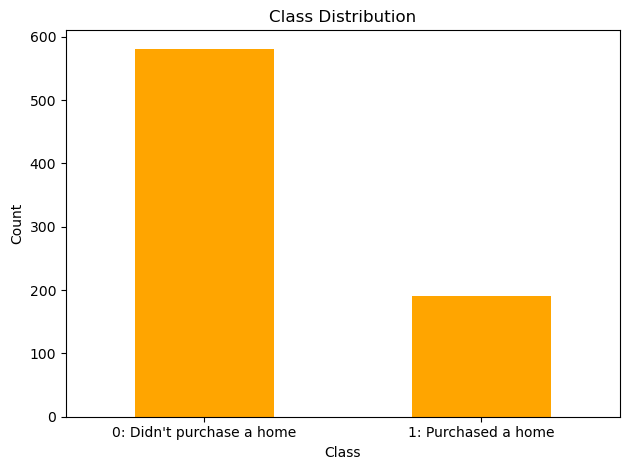

0    581
1    191
Name: home_ownership_class, dtype: int64

0    0.752591
1    0.247409
Name: home_ownership_class, dtype: float64

In [189]:
class_counts = df['home_ownership_class'].value_counts()
class_counts = class_counts.rename({0: "0: Didn't purchase a home",
                                    1: "1: Purchased a home"})

# Plot
class_counts.plot(kind='bar', color='orange')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

display(df['home_ownership_class'].value_counts())
display(df['home_ownership_class'].value_counts(normalize=True))

## Runs: RobustScaler()

In [190]:
scaler = RobustScaler()

In [191]:
t07_adaboost_gs, t07_adaboost_be, t07_adaboost_model_info, t07_adaboost_metrics_df = adaboost_class2(t07, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


Best Hyperparameters: {'classifier__algorithm': 'SAMME', 'classifier__estimator': RandomForestClassifier(random_state=0), 'classifier__n_estimators': 200, 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.33345238095238094
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 AdaBoostClassifier(algorithm='SAMME',
                                    estimator=RandomForestClassifier(random_state=0),
                                    n_estimators=200, random_state=0))])
Mean Train Score (Precision) 0.8229099835462985
Std Train Score (Precision) 0.011203871488926098
GridSearchCV Runtime: 13.39457106590271 secs
Run 1 - Random State: 0
Test Precision: 0.45454545454545453
Run 2 - Random State: 1
Test Precision: 0.3
Run 3 - Random State: 2
Test Precision: 0.5
Run 4 - Random State: 3
Test Precision: 0.3333333333333333
Run 5 - Random State: 4
Test Precision: 0.44

In [192]:
t07_dt_gs, t07_dt_be, t07_dt_model_info, t07_dt_metrics_df = dt_class2(t07, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 1728 candidates, totalling 17280 fits



4320 fits failed out of a total of 17280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2715 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 638, in _

Best Hyperparameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 5, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 2, 'resampling': TomekLinks()}
Best Validation Score (Precision): 0.49869047619047624
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()), ('resampling', TomekLinks()),
                ('classifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=5,
                                        max_features='sqrt', min_samples_leaf=3,
                                        random_state=0))])
Mean Train Score (Precision) nan
Std Train Score (Precision) nan
GridSearchCV Runtime: 168.61437392234802 secs
Run 1 - Random State: 0
Test Precision: 0.36363636363636365
Run 2 - Random State: 1
Test Precision: 0.125
Run 3 - Random State: 2
Test Precision: 0.42857142857142855
Run 4 - Random State: 3
Test Precision: 0.2857142857142857
Run 5 - Random State: 4
Test Precision: 0.1
Ave Test

In [193]:
t07_logreg_gs, t07_logreg_be, t07_logreg_model_info, t07_logreg_metrics_df = logreg_class2(t07, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 390 candidates, totalling 3900 fits



650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.36837301587301585
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0))])
Mean Train Score (Precision) nan
Std Train Score (Precision) nan
GridSearchCV Runtime: 83.77255296707153 secs
Run 1 - Random State: 0
Test Precision: 0.25
Run 2 - Random State: 1
Test Precision: 0.4666666666666667
Run 3 - Random State: 2
Test Precision: 0.23076923076923078
Run 4 - Random State: 3
Test Precision: 0.3333333333333333
Run 5 - Random State: 4
Test Precision: 0.42105263157894735
Ave Test Precision: 0.3403643724696356
Stdev Test Precision: 0.10330672181061583
Ave Test Accuracy: 0.7150259067357513
Stdev Test Accuracy: 0.027171213683164542
Ave Test Speci

In [194]:
t07_knn_gs, t07_knn_be, t07_knn_model_info, t07_knn_metrics_df = knn_class2(t07, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 600 candidates, totalling 6000 fits


Best Hyperparameters: {'classifier__metric': 'canberra', 'classifier__n_neighbors': 12, 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.38727272727272727
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 KNeighborsClassifier(metric='canberra', n_neighbors=12))])
Mean Train Score (Precision) 0.48842836580296495
Std Train Score (Precision) 0.021037624187914494
GridSearchCV Runtime: 107.93637657165527 secs
Run 1 - Random State: 0
Test Precision: 0.2631578947368421
Run 2 - Random State: 1
Test Precision: 0.2727272727272727
Run 3 - Random State: 2
Test Precision: 0.36363636363636365
Run 4 - Random State: 3
Test Precision: 0.2
Run 5 - Random State: 4
Test Precision: 0.21428571428571427
Ave Test Precision: 0.26276144907723853
Stdev Test Precision: 0.064350834398919
Ave Test Accuracy: 0.7222797927461139
Stdev Test Accuracy: 0.01447071507126315
Ave Test Sp

In [196]:
t07_svm_gs, t07_svm_be, t07_svm_model_info, t07_svm_metrics_df = svm_class2(t07, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 520 candidates, totalling 5200 fits
[LibSVM]Best Hyperparameters: {'classifier__C': 10.0, 'classifier__kernel': 'poly', 'classifier__probability': True, 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.5158045977011494
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 SVC(C=10.0, kernel='poly', max_iter=1000, probability=True,
                     random_state=0, verbose=True))])
Mean Train Score (Precision) 0.35603411806659063
Std Train Score (Precision) 0.06850226612654274
GridSearchCV Runtime: 62.12338447570801 secs
[LibSVM]Run 1 - Random State: 0
Test Precision: 0.24870466321243523
[LibSVM]Run 2 - Random State: 1
Test Precision: 0.3333333333333333


Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
invalid value encountered in scalar divide
Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[LibSVM]Run 3 - Random State: 2
Test Precision: 0.125
[LibSVM]Run 4 - Random State: 3
Test Precision: 0.4
[LibSVM]Run 5 - Random State: 4
Test Precision: 0.2777777777777778
Ave Test Precision: 0.27696315486470924
Stdev Test Precision: 0.10272252513302255
Ave Test Accuracy: 0.6321243523316061
Stdev Test Accuracy: 0.21476043291256688
Ave Test Specificity: 0.7586206896551724
Ave Test Recall: 0.25
Ave Test NPV: 0.7534512992372202
Ave Test F1-Score: 0.1595149589497851
Ave Test G-mean: 0.18653594816411329
Ave Runtime: 0.0683469295501709


Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


In [198]:
t07_catboost_gs, t07_catboost_be, t07_catboost_model_info, t07_catboost_metrics_df = catboost_class2(t07, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Learning rate set to 0.009812
0:	learn: 0.6907225	total: 4.54ms	remaining: 4.53s
1:	learn: 0.6873353	total: 8.68ms	remaining: 4.33s
2:	learn: 0.6841342	total: 12.4ms	remaining: 4.14s
3:	learn: 0.6798865	total: 15.9ms	remaining: 3.95s
4:	learn: 0.6764652	total: 19.6ms	remaining: 3.89s
5:	learn: 0.6728389	total: 23.4ms	remaining: 3.87s
6:	learn: 0.6703699	total: 26.5ms	remaining: 3.75s
7:	learn: 0.6662094	total: 29.6ms	remaining: 3.67s
8:	learn: 0.6637746	total: 33ms	remaining: 3.64s
9:	learn: 0.6609379	total: 37.1ms	remaining: 3.67s
10:	learn: 0.6580674	total: 41.6ms	remaining: 3.74s
11:	learn: 0.6560947	total: 45.7ms	remaining: 3.76s
12:	learn: 0.6531763	total: 50.2ms	remaining: 3.81s
13:	learn: 0.6498070	total: 54.4ms	remaining: 3.83s
14:	learn: 0.6478545	total: 58.9ms	remaining: 3.86s
15:	learn: 0.6455842	total: 62.9ms	remaining: 3.87s
16:	learn: 0.6435533	total: 67.2ms	remaining: 3.89s
17:	learn: 0.6407792	total: 71.8ms	re

In [199]:
t07_lgbm_gs, t07_lgbm_be, t07_lgbm_model_info, t07_lgbm_metrics_df = lgbm_class2(t07, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits
[LightGBM] [Info] Number of positive: 436, number of negative: 436
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7923
[LightGBM] [Info] Number of data points in the train set: 872, number of used features: 90
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [200]:
t07_gbm_gs, t07_gbm_be, t07_gbm_model_info, t07_gbm_metrics_df = gbm_class2(t07, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


Best Hyperparameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200, 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.3435714285714285
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 GradientBoostingClassifier(min_samples_leaf=2,
                                            n_estimators=200,
                                            random_state=0))])
Mean Train Score (Precision) 0.8026712926167876
Std Train Score (Precision) 0.013131100924315154
GridSearchCV Runtime: 166.96589398384094 secs
Run 1 - Random State: 0
Test Precision: 0.32142857142857145
Run 2 - Random State: 1
Test Precision: 0.36666666666666664
Run 3 - Random State: 2
Test Precision: 0.4583333333333333
Run 4 - Random State: 3
Test Precision: 0.30434782608695654
R

In [202]:
t07_rf_gs, t07_rf_be, t07_rf_model_info, t07_rf_metrics_df = rf_class2(t07, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 480 candidates, totalling 4800 fits
Best Hyperparameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 2, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200, 'classifier__oob_score': True, 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.3481381886087768
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 RandomForestClassifier(criterion='entropy', max_depth=2,
                                        min_samples_leaf=3, n_estimators=200,
                                        oob_score=True, random_state=0))])
Mean Train Score (Precision) 0.46115733400966163
Std Train Score (Precision) 0.032654139848115236
GridSearchCV Runtime: 279.0531630516052 secs
Run 1 - Random State: 0
Test Precision: 0.2903225806451613
Run 2 - Random State: 1
Test Precision: 0.41071

In [203]:
t07_xgb_gs, t07_xgb_be, t07_xgb_model_info, t07_xgb_metrics_df = xgb_class2(t07, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 540 candidates, totalling 5400 fits
Best Hyperparameters: {'classifier__grow_policy': 'depthwise', 'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__max_leaves': 10, 'classifier__n_estimators': 250, 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.41158730158730156
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy='depthwise', importance_type=None,
          

In [204]:
model_vars = ['knn', 'svm', 'logreg', 'dt', 'rf', 'gbm', 'lgbm', 'xgb', 'adaboost', 'catboost']

var_df = {
    'Classifier model': [
        'k-Nearest Neighbors', 'SVM Classifier',
        'Logistic Regression', 'Decision Tree', 'Random Forest',
        'Gradient Boosting Machine (GBM)',
        'LightGBM', 'Extreme Gradient Boosting (XGBoost)',
        'AdaBoost', 'CatBoost'
    ],
    'Best Hyperparameters': [],
    'Average Val Precision': [],
    'Average Train Precision': [],
    'Stdev Train Precision': [],
    'Average Test Precision': [],
    'Stdev Test Precision': [],
    'Average Test Accuracy': [],
    'Stdev Test Accuracy': [],
    'Average Runtime': [],
    'Average Test Specificity': [],
    'Average Test Recall': [],
    'Average Test NPV': [],
    'Average Test F1-score': [],
    'Average Test G-mean': []
}

prefix = 't07_'
for name in model_vars:
    var_df['Best Hyperparameters'].append(globals()[prefix+name+'_model_info']['best_params'])
    var_df['Average Val Precision'].append(globals()[prefix+name+'_model_info']['best_cv_score'])
    var_df['Average Train Precision'].append(globals()[prefix+name+'_model_info']['mean_train_score'])
    var_df['Stdev Train Precision'].append(globals()[prefix+name+'_model_info']['std_train_score'])
    var_df['Average Test Precision'].append(globals()[prefix+name+'_model_info']['average_test_precision'])
    var_df['Stdev Test Precision'].append(globals()[prefix+name+'_model_info']['stdev_test_precision'])
    var_df['Average Test Accuracy'].append(globals()[prefix+name+'_model_info']['average_test_accuracy'])
    var_df['Stdev Test Accuracy'].append(globals()[prefix+name+'_model_info']['stdev_test_accuracy'])
    var_df['Average Runtime'].append(globals()[prefix+name+'_model_info']['average_runtime'])
    var_df['Average Test Specificity'].append(globals()[prefix+name+'_model_info']['average_test_specificity'])
    var_df['Average Test Recall'].append(globals()[prefix+name+'_model_info']['average_test_recall'])
    var_df['Average Test NPV'].append(globals()[prefix+name+'_model_info']['average_test_npv'])
    var_df['Average Test F1-score'].append(globals()[prefix+name+'_model_info']['average_test_f1_score'])
    var_df['Average Test G-mean'].append(globals()[prefix+name+'_model_info']['average_test_g_mean'])

# display(t07_model_summ)
t07_summ = pd.DataFrame(var_df)

# columns_to_exclude = ['Best Hyperparameters', 'Average Runtime']
# selected_columns = [col for col in ho_t1__summ.columns if col not in columns_to_exclude]
# ho_t1__summ[selected_columns]

t07_summ[[
    'Classifier model', 'Average Test Precision', 'Stdev Test Precision',
    'Average Val Precision', 'Average Train Precision', 'Stdev Train Precision',
    'Average Test Accuracy', 'Stdev Test Accuracy', 'Average Test Specificity',
    'Average Test Recall', 'Average Test NPV', 'Average Test F1-score', 'Average Test G-mean'
]].sort_values(by='Average Test Precision', ascending=False)

Classifier model  Average Test Precision  \
9                             CatBoost                0.431091   
8                             AdaBoost                0.406465   
5      Gradient Boosting Machine (GBM)                0.386155   
7  Extreme Gradient Boosting (XGBoost)                0.383424   
4                        Random Forest                0.344390   
2                  Logistic Regression                0.340364   
6                             LightGBM                0.333513   
1                       SVM Classifier                0.276963   
0                  k-Nearest Neighbors                0.262761   
3                        Decision Tree                0.260584   

   Stdev Test Precision  Average Val Precision  Average Train Precision  \
9              0.159098               0.427619                 0.831355   
8              0.085420               0.333452                 0.822910   
5              0.079496               0.343571                 0.802671   
7              0.067927               0.411587                 0.759609   
4              0.054387               0.348138                 0.461157   
2              0.103307               0.368373                      NaN   
6              0.071815               0.435238                 0.663304   
1              0.102723               0.515805                 0.356034   
0              0.064351               0.387273                 0.488428   
3              0.144604               0.498690                      NaN   

   Stdev Train Precision  Average Test Accuracy  Stdev Test Accuracy  \
9               0.008758               0.738860             0.026318   
8               0.011204               0.743005             0.007858   
5               0.013131               0.720207             0.021675   
7               0.016097               0.725389             0.016385   
4               0.032654               0.658031             0.033378   
2                    NaN               0.715026             0.027171   
6               0.024327               0.712953             0.014927   
1               0.068502               0.632124             0.214760   
0               0.021038               0.722280             0.014471   
3                    NaN               0.729534             0.014378   

   Average Test Specificity  Average Test Recall  Average Test NPV  \
9                  0.944828             0.116667          0.763608   
8                  0.962759             0.079167          0.759548   
5                  0.889655             0.208333          0.772449   
7                  0.908966             0.170833          0.768102   
4                  0.737931             0.416667          0.792888   
2                  0.906207             0.137500          0.760271   
6                  0.895172             0.162500          0.763662   
1                  0.758621             0.250000          0.753451   
0                  0.939310             0.066667          0.752493   
3                  0.955862             0.045833          0.751622   

   Average Test F1-score  Average Test G-mean  
9               0.181283             0.327942  
8               0.131956             0.272394  
5               0.270080             0.428780  
7               0.235409             0.391887  
4               0.376059             0.551872  
2               0.194630             0.352100  
6               0.217664             0.377094  
1               0.159515             0.186536  
0               0.104210             0.242812  
3               0.077522             0.201864

In [205]:
best_scores_models = {
    'Best Score': [],
    'Best Model': []
}

indices = [
    'Highest Test Accuracy',
    'Highest Test G-mean',
    'Highest Test Recall',
    'Highest Test Precision',
    'Highest Test Specificity',
    'Highest Test F1-score'
]

# Corresponding column names in your original dataframe
columns = [
    'Average Test Accuracy',
    'Average Test G-mean',
    'Average Test Recall',
    'Average Test Precision',
    'Average Test Specificity',
    'Average Test F1-score'
]

df = t07_summ
# Finding the best model for each metric
for col in columns:
    best_score = df[col].max()
    best_model = df.loc[df[col] == best_score, 'Classifier model'].values[0]
    
    best_scores_models['Best Score'].append(best_score)
    best_scores_models['Best Model'].append(best_model)

# Creating the new dataframe
best_df = pd.DataFrame(best_scores_models, index=indices)

# Displaying the new dataframe
best_df

Best Score     Best Model
Highest Test Accuracy       0.743005       AdaBoost
Highest Test G-mean         0.551872  Random Forest
Highest Test Recall         0.416667  Random Forest
Highest Test Precision      0.431091       CatBoost
Highest Test Specificity    0.962759       AdaBoost
Highest Test F1-score       0.376059  Random Forest

# HO_T08: Yes - 5, 30

In [261]:
t08 = dataset.copy().drop(columns=cols_with_nulls)
t08 = t08[t08['positiveMonthlySoloNetIncomeWithSavings'] != 0]
# t08_num = t08.drop(columns=['gender', 'province', 'job'])
t08 = pd.get_dummies(t08, columns=['gender'], prefix='gender', drop_first='True')
t08 = pd.get_dummies(t08, columns=['province'], prefix='province', drop_first='True')
t08 = pd.get_dummies(t08, columns=['job'], prefix='job', drop_first='True')

# t08.isna().sum()[t08.isna().sum() > 0]
df = t08

## EDA on Dataset

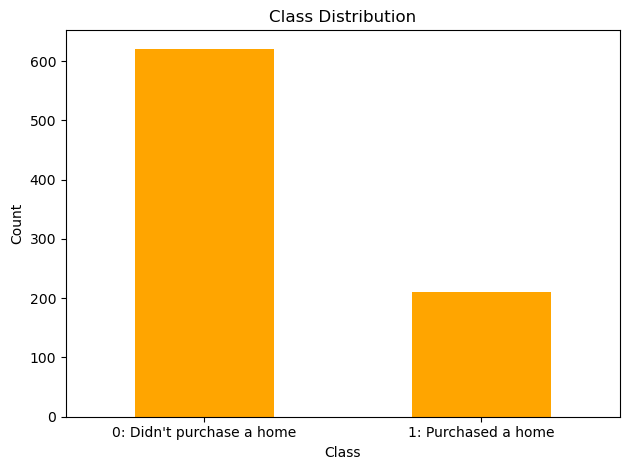

0    621
1    211
Name: home_ownership_class, dtype: int64

0    0.746394
1    0.253606
Name: home_ownership_class, dtype: float64

In [262]:
class_counts = df['home_ownership_class'].value_counts()
class_counts = class_counts.rename({0: "0: Didn't purchase a home",
                                    1: "1: Purchased a home"})

# Plot
class_counts.plot(kind='bar', color='orange')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

display(df['home_ownership_class'].value_counts())
display(df['home_ownership_class'].value_counts(normalize=True))

## Runs: RobustScaler()

In [263]:
scaler = RobustScaler()

In [264]:
t08_adaboost_gs, t08_adaboost_be, t08_adaboost_model_info, t08_adaboost_metrics_df = adaboost_class2(t08, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


Best Hyperparameters: {'classifier__algorithm': 'SAMME', 'classifier__estimator': RandomForestClassifier(random_state=0), 'classifier__n_estimators': 200, 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.5188525363525363
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 AdaBoostClassifier(algorithm='SAMME',
                                    estimator=RandomForestClassifier(random_state=0),
                                    n_estimators=200, random_state=0))])
Mean Train Score (Precision) 0.8298211665447198
Std Train Score (Precision) 0.009021983753184915
GridSearchCV Runtime: 14.45023488998413 secs
Run 1 - Random State: 0
Test Precision: 0.21052631578947367
Run 2 - Random State: 1
Test Precision: 0.3333333333333333
Run 3 - Random State: 2
Test Precision: 0.3333333333333333
Run 4 - Random State: 3
Test Precision: 0.4117647058823529
Run 5 - Rando

In [265]:
t08_dt_gs, t08_dt_be, t08_dt_model_info, t08_dt_metrics_df = dt_class2(t08, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 1728 candidates, totalling 17280 fits



4320 fits failed out of a total of 17280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2013 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 638, in _

Best Hyperparameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 2, 'classifier__max_features': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'resampling': TomekLinks()}
Best Validation Score (Precision): 0.5194871794871795
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()), ('resampling', TomekLinks()),
                ('classifier',
                 DecisionTreeClassifier(max_depth=2, random_state=0))])
Mean Train Score (Precision) nan
Std Train Score (Precision) nan
GridSearchCV Runtime: 219.81581926345825 secs
Run 1 - Random State: 0
Test Precision: 0.358974358974359
Run 2 - Random State: 1
Test Precision: 0.375
Run 3 - Random State: 2
Test Precision: 0.5
Run 4 - Random State: 3
Test Precision: 0.0
Run 5 - Random State: 4
Test Precision: 0.25
Ave Test Precision: 0.2967948717948718
Stdev Test Precision: 0.1881167262515351
Ave Test Accuracy: 0.7250000000000002
Stdev Test Accuracy: 0.02106625221173718
Ave Test Specificity: 0.93806

In [272]:
t08_logreg_gs, t08_logreg_be, t08_logreg_model_info, t08_logreg_metrics_df = logreg_class2(t08, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 390 candidates, totalling 3900 fits



650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': None, 'classifier__solver': 'lbfgs', 'resampling': RandomUnderSampler(random_state=0)}
Best Validation Score (Precision): 0.32167144216232574
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomUnderSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, penalty=None,
                                    random_state=0))])
Mean Train Score (Precision) nan
Std Train Score (Precision) nan
GridSearchCV Runtime: 48.05633544921875 secs


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty=None will ignore the C and l1_ratio parameters


Run 1 - Random State: 0
Test Precision: 0.2903225806451613


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty=None will ignore the C and l1_ratio parameters


Run 2 - Random State: 1
Test Precision: 0.34210526315789475


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty=None will ignore the C and l1_ratio parameters


Run 3 - Random State: 2
Test Precision: 0.34177215189873417


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty=None will ignore the C and l1_ratio parameters


Run 4 - Random State: 3
Test Precision: 0.3333333333333333
Run 5 - Random State: 4
Test Precision: 0.2878787878787879
Ave Test Precision: 0.31908242338278225
Stdev Test Precision: 0.02760778327218451
Ave Test Accuracy: 0.6086538461538462
Stdev Test Accuracy: 0.02936236823962013
Ave Test Specificity: 0.655483870967742
Ave Test Recall: 0.4716981132075472
Ave Test NPV: 0.7841376547850578
Ave Test F1-Score: 0.37966579879225415
Ave Test G-mean: 0.553977737619221
Ave Runtime: 0.2716828346252441


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [273]:
t08_knn_gs, t08_knn_be, t08_knn_model_info, t08_knn_metrics_df = knn_class2(t08, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 600 candidates, totalling 6000 fits


Best Hyperparameters: {'classifier__metric': 'hamming', 'classifier__n_neighbors': 11, 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.45
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 KNeighborsClassifier(metric='hamming', n_neighbors=11))])
Mean Train Score (Precision) 0.5130985147798651
Std Train Score (Precision) 0.020264600648248855
GridSearchCV Runtime: 42.25172185897827 secs
Run 1 - Random State: 0
Test Precision: 0.0
Run 2 - Random State: 1
Test Precision: 0.4
Run 3 - Random State: 2
Test Precision: 0.2857142857142857
Run 4 - Random State: 3
Test Precision: 0.5
Run 5 - Random State: 4
Test Precision: 0.0
Ave Test Precision: 0.23714285714285716
Stdev Test Precision: 0.22937359241630056
Ave Test Accuracy: 0.7278846153846154
Stdev Test Accuracy: 0.017200522903844565
Ave Test Specificity: 0.9690322580645162
Ave Test Recall: 0.02264150943396

In [274]:
t08_svm_gs, t08_svm_be, t08_svm_model_info, t08_svm_metrics_df = svm_class2(t08, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 520 candidates, totalling 5200 fits


[LibSVM]Best Hyperparameters: {'classifier__C': 1000.0, 'classifier__kernel': 'poly', 'classifier__probability': True, 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.32872894221148335
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 SVC(C=1000.0, kernel='poly', max_iter=1000, probability=True,
                     random_state=0, verbose=True))])
Mean Train Score (Precision) 0.277157498061952
Std Train Score (Precision) 0.03188559784515599
GridSearchCV Runtime: 55.65972971916199 secs


Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[LibSVM]Run 1 - Random State: 0
Test Precision: 0.23880597014925373
[LibSVM]

Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


Run 2 - Random State: 1
Test Precision: 0.24630541871921183
[LibSVM]

Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


Run 3 - Random State: 2
Test Precision: 0.23626373626373626
[LibSVM]Run 4 - Random State: 3
Test Precision: 0.25
[LibSVM]Run 5 - Random State: 4
Test Precision: 0.24210526315789474
Ave Test Precision: 0.24269607765801932
Stdev Test Precision: 0.00555048733197397
Ave Test Accuracy: 0.2644230769230769
Stdev Test Accuracy: 0.018307146889095936
Ave Test Specificity: 0.050322580645161284
Ave Test Recall: 0.8905660377358491
Ave Test NPV: 0.5157753357753359
Ave Test F1-Score: 0.381342064589609
Ave Test G-mean: 0.19489060813409914
Ave Runtime: 0.2108053207397461


Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


In [275]:
t08_catboost_gs, t08_catboost_be, t08_catboost_model_info, t08_catboost_metrics_df = catboost_class2(t08, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


Learning rate set to 0.009997
0:	learn: 0.6911486	total: 5.21ms	remaining: 5.2s
1:	learn: 0.6878896	total: 9.95ms	remaining: 4.96s
2:	learn: 0.6854106	total: 14.8ms	remaining: 4.92s
3:	learn: 0.6816535	total: 20.1ms	remaining: 5.01s
4:	learn: 0.6791401	total: 24ms	remaining: 4.78s
5:	learn: 0.6766924	total: 28.1ms	remaining: 4.66s
6:	learn: 0.6747716	total: 32.1ms	remaining: 4.56s
7:	learn: 0.6730956	total: 35.8ms	remaining: 4.43s
8:	learn: 0.6704022	total: 39.9ms	remaining: 4.39s
9:	learn: 0.6681168	total: 43.8ms	remaining: 4.34s
10:	learn: 0.6655355	total: 47.9ms	remaining: 4.31s
11:	learn: 0.6632354	total: 51.8ms	remaining: 4.27s
12:	learn: 0.6609412	total: 55.2ms	remaining: 4.19s
13:	learn: 0.6586102	total: 59.5ms	remaining: 4.19s
14:	learn: 0.6562321	total: 63.3ms	remaining: 4.16s
15:	learn: 0.6543030	total: 66.9ms	remaining: 4.12s
16:	learn: 0.6521140	total: 71.1ms	remaining: 4.11s
17:	learn: 0.6502570	total: 74.3ms	remaining: 4.05s
18:	learn: 0.6479516	total: 78.2ms	remaining: 4

In [276]:
t08_lgbm_gs, t08_lgbm_be, t08_lgbm_model_info, t08_lgbm_metrics_df = lgbm_class2(t08, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


[LightGBM] [Info] Number of positive: 466, number of negative: 466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8158
[LightGBM] [Info] Number of data points in the train set: 932, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best Hyperparameters: {'classifier__boosting_type': 'dart', 'classifier__learning_rate': 0.1, 'classifier__max_depth': 2, 'classifier__n_estimators': 200, 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.44113275613275615
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LGBM

In [277]:
t08_gbm_gs, t08_gbm_be, t08_gbm_model_info, t08_gbm_metrics_df = gbm_class2(t08, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


Best Hyperparameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200, 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.44693084693084695
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 GradientBoostingClassifier(min_samples_leaf=3,
                                            n_estimators=200,
                                            random_state=0))])
Mean Train Score (Precision) 0.8043610703893738
Std Train Score (Precision) 0.01079892152287468
GridSearchCV Runtime: 207.77216124534607 secs
Run 1 - Random State: 0
Test Precision: 0.4594594594594595
Run 2 - Random State: 1
Test Precision: 0.41379310344827586
Run 3 - Random State: 2
Test Precision: 0.5161290322580645
Run 4 - Random State: 3
Test Precision: 0.5
Run 5 - Random Sta

In [278]:
t08_rf_gs, t08_rf_be, t08_rf_model_info, t08_rf_metrics_df = rf_class2(t08, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 480 candidates, totalling 4800 fits


Best Hyperparameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300, 'classifier__oob_score': True, 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.3885846970367094
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 RandomForestClassifier(max_depth=3, min_samples_leaf=2,
                                        n_estimators=300, oob_score=True,
                                        random_state=0))])
Mean Train Score (Precision) 0.4647435803738097
Std Train Score (Precision) 0.017150719630862243
GridSearchCV Runtime: 357.1235692501068 secs
Run 1 - Random State: 0
Test Precision: 0.3472222222222222
Run 2 - Random State: 1
Test Precision: 0.4772727272727273
Run 3 - Random State: 2
Test Precision: 0.375
Run 4 - Random State: 3
Test Pre

In [279]:
t08_xgb_gs, t08_xgb_be, t08_xgb_model_info, t08_xgb_metrics_df = xgb_class2(t08, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 540 candidates, totalling 5400 fits
Best Hyperparameters: {'classifier__grow_policy': 'depthwise', 'classifier__learning_rate': 0.1, 'classifier__max_depth': None, 'classifier__max_leaves': 10, 'classifier__n_estimators': 250, 'resampling': RandomOverSampler(random_state=0)}
Best Validation Score (Precision): 0.5256709956709956
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomOverSampler(random_state=0)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy='depthwise', importa

In [280]:
model_vars = ['knn', 'svm', 'logreg', 'dt', 'rf', 'gbm', 'lgbm', 'xgb', 'adaboost', 'catboost']

var_df = {
    'Classifier model': [
        'k-Nearest Neighbors', 'SVM Classifier',
        'Logistic Regression', 'Decision Tree', 'Random Forest',
        'Gradient Boosting Machine (GBM)',
        'LightGBM', 'Extreme Gradient Boosting (XGBoost)',
        'AdaBoost', 'CatBoost'
    ],
    'Best Hyperparameters': [],
    'Average Val Precision': [],
    'Average Train Precision': [],
    'Stdev Train Precision': [],
    'Average Test Precision': [],
    'Stdev Test Precision': [],
    'Average Test Accuracy': [],
    'Stdev Test Accuracy': [],
    'Average Runtime': [],
    'Average Test Specificity': [],
    'Average Test Recall': [],
    'Average Test NPV': [],
    'Average Test F1-score': [],
    'Average Test G-mean': []
}

prefix = 't08_'
for name in model_vars:
    var_df['Best Hyperparameters'].append(globals()[prefix+name+'_model_info']['best_params'])
    var_df['Average Val Precision'].append(globals()[prefix+name+'_model_info']['best_cv_score'])
    var_df['Average Train Precision'].append(globals()[prefix+name+'_model_info']['mean_train_score'])
    var_df['Stdev Train Precision'].append(globals()[prefix+name+'_model_info']['std_train_score'])
    var_df['Average Test Precision'].append(globals()[prefix+name+'_model_info']['average_test_precision'])
    var_df['Stdev Test Precision'].append(globals()[prefix+name+'_model_info']['stdev_test_precision'])
    var_df['Average Test Accuracy'].append(globals()[prefix+name+'_model_info']['average_test_accuracy'])
    var_df['Stdev Test Accuracy'].append(globals()[prefix+name+'_model_info']['stdev_test_accuracy'])
    var_df['Average Runtime'].append(globals()[prefix+name+'_model_info']['average_runtime'])
    var_df['Average Test Specificity'].append(globals()[prefix+name+'_model_info']['average_test_specificity'])
    var_df['Average Test Recall'].append(globals()[prefix+name+'_model_info']['average_test_recall'])
    var_df['Average Test NPV'].append(globals()[prefix+name+'_model_info']['average_test_npv'])
    var_df['Average Test F1-score'].append(globals()[prefix+name+'_model_info']['average_test_f1_score'])
    var_df['Average Test G-mean'].append(globals()[prefix+name+'_model_info']['average_test_g_mean'])

# display(t08_model_summ)
t08_summ = pd.DataFrame(var_df)

# columns_to_exclude = ['Best Hyperparameters', 'Average Runtime']
# selected_columns = [col for col in ho_t1__summ.columns if col not in columns_to_exclude]
# ho_t1__summ[selected_columns]

t08_summ[[
    'Classifier model', 'Average Test Precision', 'Stdev Test Precision',
    'Average Val Precision', 'Average Train Precision', 'Stdev Train Precision',
    'Average Test Accuracy', 'Stdev Test Accuracy', 'Average Test Specificity',
    'Average Test Recall', 'Average Test NPV', 'Average Test F1-score', 'Average Test G-mean'
]].sort_values(by='Average Test Precision', ascending=False)

Classifier model  Average Test Precision  \
5      Gradient Boosting Machine (GBM)                0.456448   
6                             LightGBM                0.438436   
9                             CatBoost                0.406700   
4                        Random Forest                0.383063   
7  Extreme Gradient Boosting (XGBoost)                0.378551   
8                             AdaBoost                0.324458   
2                  Logistic Regression                0.319082   
3                        Decision Tree                0.296795   
1                       SVM Classifier                0.242696   
0                  k-Nearest Neighbors                0.237143   

   Stdev Test Precision  Average Val Precision  Average Train Precision  \
5              0.053223               0.446931                 0.804361   
6              0.092838               0.441133                 0.645186   
9              0.094789               0.540231                 0.832845   
4              0.055333               0.388585                 0.464744   
7              0.065050               0.525671                 0.753689   
8              0.072179               0.518853                 0.829821   
2              0.027608               0.321671                      NaN   
3              0.188117               0.519487                      NaN   
1              0.005550               0.328729                 0.277157   
0              0.229374               0.450000                 0.513099   

   Stdev Train Precision  Average Test Accuracy  Stdev Test Accuracy  \
5               0.010799               0.732692             0.014661   
6               0.019207               0.723077             0.037488   
9               0.007002               0.721154             0.026112   
4               0.017151               0.674038             0.038671   
7               0.013819               0.702885             0.023405   
8               0.009022               0.718269             0.015050   
2                    NaN               0.608654             0.029362   
3                    NaN               0.725000             0.021066   
1               0.031886               0.264423             0.018307   
0               0.020265               0.727885             0.017201   

   Average Test Specificity  Average Test Recall  Average Test NPV  \
5                  0.891613             0.267925          0.780913   
6                  0.887742             0.241509          0.773625   
9                  0.894194             0.215094          0.769283   
4                  0.760000             0.422642          0.793584   
7                  0.860645             0.241509          0.768353   
8                  0.931613             0.094340          0.750499   
2                  0.655484             0.471698          0.784138   
3                  0.938065             0.101887          0.754078   
1                  0.050323             0.890566          0.515775   
0                  0.969032             0.022642          0.743524   

   Average Test F1-score  Average Test G-mean  
5               0.336893             0.487035  
6               0.308940             0.462016  
9               0.280157             0.434220  
4               0.398697             0.565295  
7               0.293115             0.455189  
8               0.145661             0.294856  
2               0.379666             0.553978  
3               0.134979             0.246790  
1               0.381342             0.194891  
0               0.041162             0.115293

In [281]:
best_scores_models = {
    'Best Score': [],
    'Best Model': []
}

indices = [
    'Highest Test Accuracy',
    'Highest Test G-mean',
    'Highest Test Recall',
    'Highest Test Precision',
    'Highest Test Specificity',
    'Highest Test F1-score'
]

# Corresponding column names in your original dataframe
columns = [
    'Average Test Accuracy',
    'Average Test G-mean',
    'Average Test Recall',
    'Average Test Precision',
    'Average Test Specificity',
    'Average Test F1-score'
]

df = t08_summ
# Finding the best model for each metric
for col in columns:
    best_score = df[col].max()
    best_model = df.loc[df[col] == best_score, 'Classifier model'].values[0]
    
    best_scores_models['Best Score'].append(best_score)
    best_scores_models['Best Model'].append(best_model)

# Creating the new dataframe
best_df = pd.DataFrame(best_scores_models, index=indices)

# Displaying the new dataframe
best_df

Best Score                       Best Model
Highest Test Accuracy       0.732692  Gradient Boosting Machine (GBM)
Highest Test G-mean         0.565295                    Random Forest
Highest Test Recall         0.890566                   SVM Classifier
Highest Test Precision      0.456448  Gradient Boosting Machine (GBM)
Highest Test Specificity    0.969032              k-Nearest Neighbors
Highest Test F1-score       0.398697                    Random Forest

# HO_T09: Yes - 6, 30

In [282]:
t09 = dataset.copy().drop(columns=cols_with_nulls)
t09 = t09[t09['positiveMonthlyFamilyNetIncomeWithSavings'] != 0]
# t09_num = t09.drop(columns=['gender', 'province', 'job'])
t09 = pd.get_dummies(t09, columns=['gender'], prefix='gender', drop_first='True')
t09 = pd.get_dummies(t09, columns=['province'], prefix='province', drop_first='True')
t09 = pd.get_dummies(t09, columns=['job'], prefix='job', drop_first='True')

# t09.isna().sum()[t09.isna().sum() > 0]
df = t09

## EDA on Dataset

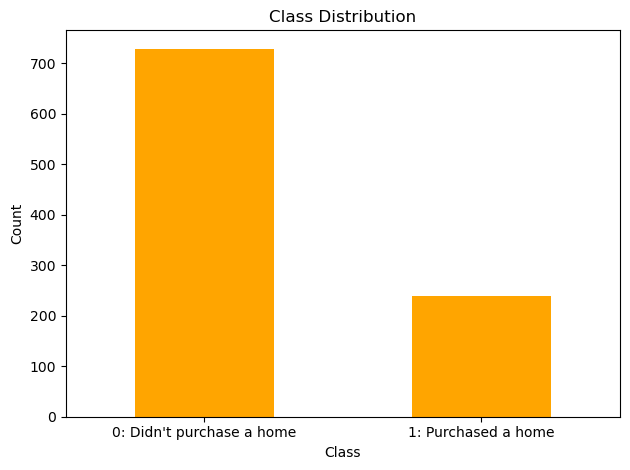

0    729
1    240
Name: home_ownership_class, dtype: int64

0    0.752322
1    0.247678
Name: home_ownership_class, dtype: float64

In [283]:
class_counts = df['home_ownership_class'].value_counts()
class_counts = class_counts.rename({0: "0: Didn't purchase a home",
                                    1: "1: Purchased a home"})

# Plot
class_counts.plot(kind='bar', color='orange')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

display(df['home_ownership_class'].value_counts())
display(df['home_ownership_class'].value_counts(normalize=True))

## Runs: RobustScaler()

In [284]:
scaler = RobustScaler()

In [285]:
t09_adaboost_gs, t09_adaboost_be, t09_adaboost_model_info, t09_adaboost_metrics_df = adaboost_class2(t09, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


Best Hyperparameters: {'classifier__algorithm': 'SAMME', 'classifier__estimator': RandomForestClassifier(random_state=0), 'classifier__n_estimators': 200, 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.4742857142857143
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 AdaBoostClassifier(algorithm='SAMME',
                                    estimator=RandomForestClassifier(random_state=0),
                                    n_estimators=200, random_state=0))])
Mean Train Score (Precision) 0.835506877228411
Std Train Score (Precision) 0.008074249335428283
GridSearchCV Runtime: 20.464603900909424 secs
Run 1 - Random State: 0
Test Precision: 0.19047619047619047
Run 2 - Random State: 1
Test Precision: 0.391304347826087
Run 3 - Random State: 2
Test Precision: 0.42857142857142855
Run 4 - Random State: 3
Test Precision: 0.3333333333333333
Run 5 - Rando

In [286]:
t09_dt_gs, t09_dt_be, t09_dt_model_info, t09_dt_metrics_df = dt_class2(t09, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 1728 candidates, totalling 17280 fits



4320 fits failed out of a total of 17280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2527 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 638, in _

Best Hyperparameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 2, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 2, 'resampling': TomekLinks()}
Best Validation Score (Precision): 0.515
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()), ('resampling', TomekLinks()),
                ('classifier',
                 DecisionTreeClassifier(max_depth=2, max_features='sqrt',
                                        min_samples_leaf=3, random_state=0))])
Mean Train Score (Precision) nan
Std Train Score (Precision) nan
GridSearchCV Runtime: 245.8582911491394 secs
Run 1 - Random State: 0
Test Precision: 0.2727272727272727
Run 2 - Random State: 1
Test Precision: 0.5
Run 3 - Random State: 2
Test Precision: 1.0
Run 4 - Random State: 3
Test Precision: 0.0
Run 5 - Random State: 4
Test Precision: 0.0
Ave Test Precision: 0.35454545454545455
Stdev Test Precision: 0.41709344534379866
Ave Test Accuracy: 0.7481481481481481
S

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


In [287]:
t09_logreg_gs, t09_logreg_be, t09_logreg_model_info, t09_logreg_metrics_df = logreg_class2(t09, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 390 candidates, totalling 3900 fits



650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.3423480129965368
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 LogisticRegression(C=0.1, max_iter=1000, random_state=0))])
Mean Train Score (Precision) nan
Std Train Score (Precision) nan
GridSearchCV Runtime: 106.70618653297424 secs


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Run 1 - Random State: 0
Test Precision: 0.3058823529411765


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Run 2 - Random State: 1
Test Precision: 0.27835051546391754


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Run 3 - Random State: 2
Test Precision: 0.3269230769230769


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Run 4 - Random State: 3
Test Precision: 0.28865979381443296
Run 5 - Random State: 4
Test Precision: 0.27472527472527475
Ave Test Precision: 0.29490820277357577
Stdev Test Precision: 0.021598231101628774
Ave Test Accuracy: 0.5934156378600823
Stdev Test Accuracy: 0.017067029920434316
Ave Test Specificity: 0.6349726775956285
Ave Test Recall: 0.4666666666666666
Ave Test NPV: 0.7844582259046514
Ave Test F1-Score: 0.3610035212972729
Ave Test G-mean: 0.5431688064575408
Ave Runtime: 0.7204901695251464


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [288]:
t09_knn_gs, t09_knn_be, t09_knn_model_info, t09_knn_metrics_df = knn_class2(t09, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 600 candidates, totalling 6000 fits


Best Hyperparameters: {'classifier__metric': 'canberra', 'classifier__n_neighbors': 4, 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.43000000000000005
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 KNeighborsClassifier(metric='canberra', n_neighbors=4))])
Mean Train Score (Precision) 0.5109593362880825
Std Train Score (Precision) 0.017815167138887235
GridSearchCV Runtime: 175.21954536437988 secs
Run 1 - Random State: 0
Test Precision: 0.28
Run 2 - Random State: 1
Test Precision: 0.25
Run 3 - Random State: 2
Test Precision: 0.3333333333333333
Run 4 - Random State: 3
Test Precision: 0.2916666666666667
Run 5 - Random State: 4
Test Precision: 0.3333333333333333
Ave Test Precision: 0.29766666666666663
Stdev Test Precision: 0.03593203460856496
Ave Test Accuracy: 0.7160493827160495
Stdev Test Accuracy: 0.008230452674897137
Ave Test Specificity: 0.91

In [289]:
t09_svm_gs, t09_svm_be, t09_svm_model_info, t09_svm_metrics_df = svm_class2(t09, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 520 candidates, totalling 5200 fits


[LibSVM]Best Hyperparameters: {'classifier__C': 0.1, 'classifier__kernel': 'poly', 'classifier__probability': True, 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.4
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 SVC(C=0.1, kernel='poly', max_iter=1000, probability=True,
                     random_state=0, verbose=True))])
Mean Train Score (Precision) 0.32982967682969744
Std Train Score (Precision) 0.05694738520181735
GridSearchCV Runtime: 159.01360058784485 secs
[LibSVM]Run 1 - Random State: 0
Test Precision: 0.25
[LibSVM]Run 2 - Random State: 1
Test Precision: 0.2222222222222222


Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[LibSVM]Run 3 - Random State: 2
Test Precision: 0.625
[LibSVM]Run 4 - Random State: 3
Test Precision: 0.4666666666666667
[LibSVM]

Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


Run 5 - Random State: 4
Test Precision: 0.42857142857142855
Ave Test Precision: 0.39849206349206356
Stdev Test Precision: 0.1658156656381581
Ave Test Accuracy: 0.7456790123456789
Stdev Test Accuracy: 0.01141928965062684
Ave Test Specificity: 0.9693989071038251
Ave Test Recall: 0.06333333333333332
Ave Test NPV: 0.7594608248454549
Ave Test F1-Score: 0.10801445458131338
Ave Test G-mean: 0.2400137748047964
Ave Runtime: 0.08199877738952636


In [290]:
t09_catboost_gs, t09_catboost_be, t09_catboost_model_info, t09_catboost_metrics_df = catboost_class2(t09, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


Learning rate set to 0.010722
0:	learn: 0.6884391	total: 4.25ms	remaining: 4.25s
1:	learn: 0.6828875	total: 7.6ms	remaining: 3.79s
2:	learn: 0.6775066	total: 11.3ms	remaining: 3.75s
3:	learn: 0.6737244	total: 14.5ms	remaining: 3.61s
4:	learn: 0.6677717	total: 17.7ms	remaining: 3.51s
5:	learn: 0.6624509	total: 21.1ms	remaining: 3.49s
6:	learn: 0.6584332	total: 24.3ms	remaining: 3.45s
7:	learn: 0.6548654	total: 27.5ms	remaining: 3.41s
8:	learn: 0.6510558	total: 30.4ms	remaining: 3.35s
9:	learn: 0.6482592	total: 33.9ms	remaining: 3.36s
10:	learn: 0.6442353	total: 37.4ms	remaining: 3.36s
11:	learn: 0.6400462	total: 40.9ms	remaining: 3.37s
12:	learn: 0.6371212	total: 44.5ms	remaining: 3.38s
13:	learn: 0.6331548	total: 48.3ms	remaining: 3.4s
14:	learn: 0.6288377	total: 51.9ms	remaining: 3.41s
15:	learn: 0.6254441	total: 55.4ms	remaining: 3.41s
16:	learn: 0.6225477	total: 59.3ms	remaining: 3.43s
17:	learn: 0.6187328	total: 63.2ms	remaining: 3.45s
18:	learn: 0.6142127	total: 66.8ms	remaining: 

In [291]:
t09_lgbm_gs, t09_lgbm_be, t09_lgbm_model_info, t09_lgbm_metrics_df = lgbm_class2(t09, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


[LightGBM] [Info] Number of positive: 546, number of negative: 546
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9673
[LightGBM] [Info] Number of data points in the train set: 1092, number of used features: 92
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

In [292]:
t09_gbm_gs, t09_gbm_be, t09_gbm_model_info, t09_gbm_metrics_df = gbm_class2(t09, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


Best Hyperparameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 2, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 250, 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.5221332833832835
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 GradientBoostingClassifier(max_depth=2, min_samples_leaf=2,
                                            n_estimators=250,
                                            random_state=0))])
Mean Train Score (Precision) 0.8027603625011228
Std Train Score (Precision) 0.011868514213066129
GridSearchCV Runtime: 173.37653732299805 secs
Run 1 - Random State: 0
Test Precision: 0.275
Run 2 - Random State: 1
Test Precision: 0.3611111111111111
Run 3 - Random State: 2
Test Precision: 0.52
Run 4 - Random State: 3
Test Precision: 0.4411764705882353
Run 5 - Random Sta

In [293]:
t09_rf_gs, t09_rf_be, t09_rf_model_info, t09_rf_metrics_df = rf_class2(t09, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 480 candidates, totalling 4800 fits


Best Hyperparameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 2, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300, 'classifier__oob_score': True, 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.4113525363525364
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 RandomForestClassifier(max_depth=2, min_samples_leaf=2,
                                        n_estimators=300, oob_score=True,
                                        random_state=0))])
Mean Train Score (Precision) 0.46259647942583254
Std Train Score (Precision) 0.01841587307840533
GridSearchCV Runtime: 266.3380563259125 secs
Run 1 - Random State: 0
Test Precision: 0.3055555555555556
Run 2 - Random State: 1
Test Precision: 0.421875
Run 3 - Random State: 2
Test Precision: 0.4
Run 4 - Random State: 3
Test Precisi

In [294]:
t09_xgb_gs, t09_xgb_be, t09_xgb_model_info, t09_xgb_metrics_df = xgb_class2(t09, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 540 candidates, totalling 5400 fits
Best Hyperparameters: {'classifier__grow_policy': 'depthwise', 'classifier__learning_rate': 0.01, 'classifier__max_depth': None, 'classifier__max_leaves': 10, 'classifier__n_estimators': 250, 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.5079545454545455
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy='depthwise', importance_type=None,
        

In [ ]:
model_vars = ['knn', 'svm', 'logreg', 'dt', 'rf', 'gbm', 'lgbm', 'xgb', 'adaboost', 'catboost']

var_df = {
    'Classifier model': [
        'k-Nearest Neighbors', 'SVM Classifier',
        'Logistic Regression', 'Decision Tree', 'Random Forest',
        'Gradient Boosting Machine (GBM)',
        'LightGBM', 'Extreme Gradient Boosting (XGBoost)',
        'AdaBoost', 'CatBoost'
    ],
    'Best Hyperparameters': [],
    'Average Val Precision': [],
    'Average Train Precision': [],
    'Stdev Train Precision': [],
    'Average Test Precision': [],
    'Stdev Test Precision': [],
    'Average Test Accuracy': [],
    'Stdev Test Accuracy': [],
    'Average Runtime': [],
    'Average Test Specificity': [],
    'Average Test Recall': [],
    'Average Test NPV': [],
    'Average Test F1-score': [],
    'Average Test G-mean': []
}

prefix = 't09_'
for name in model_vars:
    var_df['Best Hyperparameters'].append(globals()[prefix+name+'_model_info']['best_params'])
    var_df['Average Val Precision'].append(globals()[prefix+name+'_model_info']['best_cv_score'])
    var_df['Average Train Precision'].append(globals()[prefix+name+'_model_info']['mean_train_score'])
    var_df['Stdev Train Precision'].append(globals()[prefix+name+'_model_info']['std_train_score'])
    var_df['Average Test Precision'].append(globals()[prefix+name+'_model_info']['average_test_precision'])
    var_df['Stdev Test Precision'].append(globals()[prefix+name+'_model_info']['stdev_test_precision'])
    var_df['Average Test Accuracy'].append(globals()[prefix+name+'_model_info']['average_test_accuracy'])
    var_df['Stdev Test Accuracy'].append(globals()[prefix+name+'_model_info']['stdev_test_accuracy'])
    var_df['Average Runtime'].append(globals()[prefix+name+'_model_info']['average_runtime'])
    var_df['Average Test Specificity'].append(globals()[prefix+name+'_model_info']['average_test_specificity'])
    var_df['Average Test Recall'].append(globals()[prefix+name+'_model_info']['average_test_recall'])
    var_df['Average Test NPV'].append(globals()[prefix+name+'_model_info']['average_test_npv'])
    var_df['Average Test F1-score'].append(globals()[prefix+name+'_model_info']['average_test_f1_score'])
    var_df['Average Test G-mean'].append(globals()[prefix+name+'_model_info']['average_test_g_mean'])

# display(t09_model_summ)
t09_summ = pd.DataFrame(var_df)

# columns_to_exclude = ['Best Hyperparameters', 'Average Runtime']
# selected_columns = [col for col in ho_t1__summ.columns if col not in columns_to_exclude]
# ho_t1__summ[selected_columns]

t09_summ[[
    'Classifier model', 'Average Test Precision', 'Stdev Test Precision',
    'Average Val Precision', 'Average Train Precision', 'Stdev Train Precision',
    'Average Test Accuracy', 'Stdev Test Accuracy', 'Average Test Specificity',
    'Average Test Recall', 'Average Test NPV', 'Average Test F1-score', 'Average Test G-mean'
]].sort_values(by='Average Test Precision', ascending=False)

Classifier model  Average Test Precision  \
1                       SVM Classifier                0.515873   
5      Gradient Boosting Machine (GBM)                0.454072   
8                             AdaBoost                0.431538   
9                             CatBoost                0.416721   
6                             LightGBM                0.399101   
4                        Random Forest                0.383734   
7  Extreme Gradient Boosting (XGBoost)                0.367930   
2                  Logistic Regression                0.299547   
0                  k-Nearest Neighbors                0.296364   
3                        Decision Tree                0.233864   

   Stdev Test Precision  Average Val Precision  Average Train Precision  \
1              0.142719               0.316667                 0.276643   
5              0.049270               0.473730                 0.803873   
8              0.064479               0.499062                 0.830146   
9              0.036817               0.539509                 0.833727   
6              0.024907               0.467840                 0.645448   
4              0.058258               0.386119                 0.464907   
7              0.060980               0.499495                 0.753411   
2              0.025786               0.319645                      NaN   
0              0.210496               0.425000                 0.513029   
3              0.224563               0.462527                      NaN   

   Stdev Train Precision  Average Test Accuracy  Stdev Test Accuracy  \
1               0.030758               0.746154             0.011478   
5               0.010644               0.732692             0.012537   
8               0.009585               0.734615             0.010423   
9               0.007273               0.722115             0.012900   
6               0.018902               0.705769             0.012444   
4               0.017012               0.673077             0.043269   
7               0.014180               0.699038             0.024182   
2                    NaN               0.593269             0.028157   
0               0.020278               0.716346             0.024278   
3                    NaN               0.722115             0.027492   

   Average Test Specificity  Average Test Recall  Average Test NPV  \
1                  0.972903             0.083019          0.756277   
5                  0.904516             0.230189          0.774619   
8                  0.944516             0.120755          0.758553   
9                  0.892903             0.222642          0.770713   
6                  0.843871             0.301887          0.779733   
4                  0.756129             0.430189          0.794745   
7                  0.855484             0.241509          0.767260   
2                  0.643871             0.445283          0.772769   
0                  0.941935             0.056604          0.744785   
3                  0.935484             0.098113          0.752761   

   Average Test F1-score  Average Test G-mean  
1               0.142372             0.281445  
5               0.304393             0.455319  
8               0.187741             0.336580  
9               0.288140             0.443659  
6               0.341477             0.502575  
4               0.402635             0.569009  
7               0.290732             0.453994  
2               0.357045             0.533018  
0               0.092748             0.228312  
3               0.125111             0.218173

In [ ]:
best_scores_models = {
    'Best Score': [],
    'Best Model': []
}

indices = [
    'Highest Test Accuracy',
    'Highest Test G-mean',
    'Highest Test Recall',
    'Highest Test Precision',
    'Highest Test Specificity',
    'Highest Test F1-score'
]

# Corresponding column names in your original dataframe
columns = [
    'Average Test Accuracy',
    'Average Test G-mean',
    'Average Test Recall',
    'Average Test Precision',
    'Average Test Specificity',
    'Average Test F1-score'
]

df = t09_summ
# Finding the best model for each metric
for col in columns:
    best_score = df[col].max()
    best_model = df.loc[df[col] == best_score, 'Classifier model'].values[0]
    
    best_scores_models['Best Score'].append(best_score)
    best_scores_models['Best Model'].append(best_model)

# Creating the new dataframe
best_df = pd.DataFrame(best_scores_models, index=indices)

# Displaying the new dataframe
best_df

Best Score           Best Model
Highest Test Accuracy       0.746154       SVM Classifier
Highest Test G-mean         0.569009        Random Forest
Highest Test Recall         0.445283  Logistic Regression
Highest Test Precision      0.515873       SVM Classifier
Highest Test Specificity    0.972903       SVM Classifier
Highest Test F1-score       0.402635        Random Forest

# HO_T10: Yes - 3, 30

In [231]:
t10 = dataset.copy().drop(columns=cols_with_nulls)
t10 = t10[t10['positiveMonthlySoloNetIncome'] != 0]
# t10_num = t10.drop(columns=['gender', 'province', 'job'])
t10 = pd.get_dummies(t10, columns=['gender'], prefix='gender', drop_first='True')
t10 = pd.get_dummies(t10, columns=['province'], prefix='province', drop_first='True')
t10 = pd.get_dummies(t10, columns=['job'], prefix='job', drop_first='True')

# t10.isna().sum()[t10.isna().sum() > 0]
df = t10

## EDA on Dataset

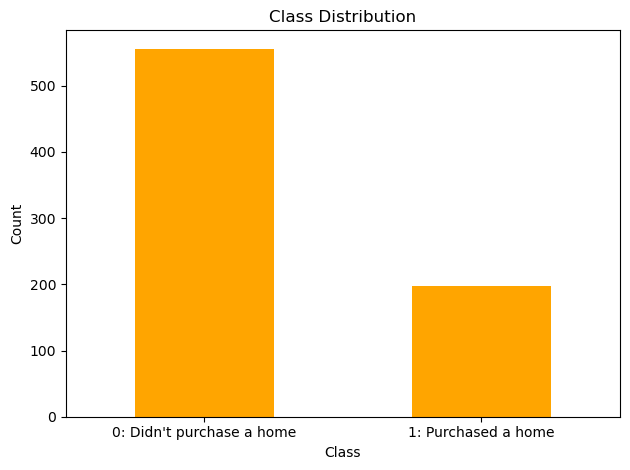

0    556
1    198
Name: home_ownership_class, dtype: int64

0    0.737401
1    0.262599
Name: home_ownership_class, dtype: float64

In [232]:
class_counts = df['home_ownership_class'].value_counts()
class_counts = class_counts.rename({0: "0: Didn't purchase a home",
                                    1: "1: Purchased a home"})

# Plot
class_counts.plot(kind='bar', color='orange')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

display(df['home_ownership_class'].value_counts())
display(df['home_ownership_class'].value_counts(normalize=True))

## Runs: RobustScaler()

In [233]:
scaler = RobustScaler()

In [234]:
t10_adaboost_gs, t10_adaboost_be, t10_adaboost_model_info, t10_adaboost_metrics_df = adaboost_class2(t10, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 40 candidates, totalling 400 fits
Best Hyperparameters: {'classifier__algorithm': 'SAMME', 'classifier__estimator': RandomForestClassifier(random_state=0), 'classifier__n_estimators': 200, 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.36122050069462874
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 AdaBoostClassifier(algorithm='SAMME',
                                    estimator=RandomForestClassifier(random_state=0),
                                    n_estimators=200, random_state=0))])
Mean Train Score (Precision) 0.8242649326874038
Std Train Score (Precision) 0.009735660590968611
GridSearchCV Runtime: 9.65074872970581 secs
Run 1 - Random State: 0
Test Precision: 0.32954545454545453
Run 2 - Random State: 1
Test Precision: 0.3582089552238806
Run 3 - Random State: 2
Test Precision: 0.3026315789473684
Run

In [235]:
t10_dt_gs, t10_dt_be, t10_dt_model_info, t10_dt_metrics_df = dt_class2(t10, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 1728 candidates, totalling 17280 fits



4320 fits failed out of a total of 17280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1971 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 638, in _

Best Hyperparameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 5, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 2, 'resampling': TomekLinks()}
Best Validation Score (Precision): 0.48678571428571427
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()), ('resampling', TomekLinks()),
                ('classifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=5,
                                        max_features='log2', min_samples_leaf=3,
                                        random_state=0))])
Mean Train Score (Precision) nan
Std Train Score (Precision) nan
GridSearchCV Runtime: 47.31779456138611 secs
Run 1 - Random State: 0
Test Precision: 0.42857142857142855
Run 2 - Random State: 1
Test Precision: 0.2608695652173913
Run 3 - Random State: 2
Test Precision: 0.16666666666666666
Run 4 - Random State: 3
Test Precision: 0.3103448275862069
Run 5 - Random State: 4
Test Precision: 

In [236]:
t10_logreg_gs, t10_logreg_be, t10_logreg_model_info, t10_logreg_metrics_df = logreg_class2(t10, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 390 candidates, totalling 3900 fits



650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 10.0, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.35032517395148577
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=10.0, max_iter=1000, random_state=0))])
Mean Train Score (Precision) nan
Std Train Score (Precision) nan
GridSearchCV Runtime: 43.47320342063904 secs


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Run 1 - Random State: 0
Test Precision: 0.32857142857142857


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Run 2 - Random State: 1
Test Precision: 0.3373493975903614


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Run 3 - Random State: 2
Test Precision: 0.3783783783783784


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Run 4 - Random State: 3
Test Precision: 0.34285714285714286
Run 5 - Random State: 4
Test Precision: 0.2916666666666667
Ave Test Precision: 0.33576460281279563
Stdev Test Precision: 0.031085041799619073
Ave Test Accuracy: 0.6074074074074074
Stdev Test Accuracy: 0.024361617848087495
Ave Test Specificity: 0.6474820143884892
Ave Test Recall: 0.496
Ave Test NPV: 0.7815814166477681
Ave Test F1-Score: 0.4000522326440109
Ave Test G-mean: 0.5655959916291802
Ave Runtime: 0.28438739776611327


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [237]:
t10_knn_gs, t10_knn_be, t10_knn_model_info, t10_knn_metrics_df = knn_class2(t10, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 600 candidates, totalling 6000 fits
Best Hyperparameters: {'classifier__metric': 'hamming', 'classifier__n_neighbors': 4, 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.41666666666666663
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 KNeighborsClassifier(metric='hamming', n_neighbors=4))])
Mean Train Score (Precision) 0.5086082998570941
Std Train Score (Precision) 0.02044392670021914
GridSearchCV Runtime: 46.04779005050659 secs
Run 1 - Random State: 0
Test Precision: 0.5
Run 2 - Random State: 1
Test Precision: 0.1
Run 3 - Random State: 2
Test Precision: 0.2727272727272727
Run 4 - Random State: 3
Test Precision: 0.5
Run 5 - Random State: 4
Test Precision: 0.5714285714285714
Ave Test Precision: 0.3888311688311688
Stdev Test Precision: 0.19682631192315825
Ave Test Accuracy: 0.7227513227513228
Stdev Test Accuracy: 0.02

In [238]:
t10_svm_gs, t10_svm_be, t10_svm_model_info, t10_svm_metrics_df = svm_class2(t10, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 520 candidates, totalling 5200 fits
[LibSVM]Best Hyperparameters: {'classifier__C': 0.01, 'classifier__kernel': 'poly', 'classifier__probability': True, 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.43499999999999994
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 SVC(C=0.01, kernel='poly', max_iter=1000, probability=True,
                     random_state=0, verbose=True))])
Mean Train Score (Precision) 0.31840025414788303
Std Train Score (Precision) 0.058317034551787515
GridSearchCV Runtime: 59.11695575714111 secs
[LibSVM]Run 1 - Random State: 0
Test Precision: 0.5
[LibSVM]Run 2 - Random State: 1
Test Precision: 0.4444444444444444
[LibSVM]Run 3 - Random State: 2
Test Precision: 0.8
[LibSVM]Run 4 - Random State: 3
Test Precision: 0.5294117647058824
[LibSVM]Run 5 - Random State: 4
Test Precision: 0.6
Ave Test

In [239]:
t10_catboost_gs, t10_catboost_be, t10_catboost_model_info, t10_catboost_metrics_df = catboost_class2(t10, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Learning rate set to 0.009534
0:	learn: 0.6907215	total: 3.4ms	remaining: 3.39s
1:	learn: 0.6894419	total: 5.93ms	remaining: 2.96s
2:	learn: 0.6869944	total: 8.68ms	remaining: 2.88s
3:	learn: 0.6847512	total: 11.7ms	remaining: 2.9s
4:	learn: 0.6832846	total: 14.4ms	remaining: 2.86s
5:	learn: 0.6812034	total: 17.6ms	remaining: 2.92s
6:	learn: 0.6790220	total: 20.3ms	remaining: 2.88s
7:	learn: 0.6767542	total: 23.1ms	remaining: 2.86s
8:	learn: 0.6750134	total: 25.8ms	remaining: 2.84s
9:	learn: 0.6736859	total: 28.8ms	remaining: 2.85s
10:	learn: 0.6708656	total: 31.7ms	remaining: 2.85s
11:	learn: 0.6686952	total: 34.7ms	remaining: 2.86s
12:	learn: 0.6666132	total: 37.4ms	remaining: 2.84s
13:	learn: 0.6643226	total: 40.7ms	remaining: 2.87s
14:	learn: 0.6619944	total: 43.9ms	remaining: 2.88s
15:	learn: 0.6600451	total: 46.9ms	remaining: 2.88s
16:	learn: 0.6581778	total: 49.7ms	remaining: 2.87s
17:	learn: 0.6559160	total: 52.2ms	re

In [240]:
t10_lgbm_gs, t10_lgbm_be, t10_lgbm_model_info, t10_lgbm_metrics_df = lgbm_class2(t10, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits
[LightGBM] [Info] Number of positive: 388, number of negative: 417
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6506
[LightGBM] [Info] Number of data points in the train set: 805, number of used features: 87
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.481988 -> initscore=-0.072081
[LightGBM] [Info] Start training from score -0.072081
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [241]:
t10_gbm_gs, t10_gbm_be, t10_gbm_model_info, t10_gbm_metrics_df = gbm_class2(t10, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


Best Hyperparameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 250, 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.4527777777777778
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 GradientBoostingClassifier(min_samples_leaf=3,
                                            n_estimators=250,
                                            random_state=0))])
Mean Train Score (Precision) 0.8012069726542166
Std Train Score (Precision) 0.011930844740485589
GridSearchCV Runtime: 153.86245679855347 secs
Run 1 - Random State: 0
Test Precision: 0.34375
Run 2 - Random State: 1
Test Precision: 0.3902439024390244
Run 3 - Random State: 2
Test Precision: 0.41379310344827586
Run 4 - Random State: 3
Test Precision: 0.4782608695652174
Run 5 - Random S

In [242]:
t10_rf_gs, t10_rf_be, t10_rf_model_info, t10_rf_metrics_df = rf_class2(t10, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 480 candidates, totalling 4800 fits
Best Hyperparameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300, 'classifier__oob_score': True, 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.389325334795923
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 RandomForestClassifier(criterion='entropy', max_depth=3,
                                        min_samples_leaf=3, n_estimators=300,
                                        oob_score=True, random_state=0))])
Mean Train Score (Precision) 0.470288788729708
Std Train Score (Precision) 0.017613484423120666
GridSearchCV Runtime: 284.44421195983887 secs
Run 1 - Random State: 0
Test Precision: 0.36363636363636365
Run 2 - Random State: 1
Test Precision: 0.3809

In [243]:
t10_xgb_gs, t10_xgb_be, t10_xgb_model_info, t10_xgb_metrics_df = xgb_class2(t10, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 540 candidates, totalling 5400 fits
Best Hyperparameters: {'classifier__grow_policy': 'depthwise', 'classifier__learning_rate': 0.01, 'classifier__max_depth': None, 'classifier__max_leaves': 10, 'classifier__n_estimators': 250, 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.47000000000000003
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy='depthwise', importance_type=None,
       

In [244]:
model_vars = ['knn', 'svm', 'logreg', 'dt', 'rf', 'gbm', 'lgbm', 'xgb', 'adaboost', 'catboost']

var_df = {
    'Classifier model': [
        'k-Nearest Neighbors', 'SVM Classifier',
        'Logistic Regression', 'Decision Tree', 'Random Forest',
        'Gradient Boosting Machine (GBM)',
        'LightGBM', 'Extreme Gradient Boosting (XGBoost)',
        'AdaBoost', 'CatBoost'
    ],
    'Best Hyperparameters': [],
    'Average Val Precision': [],
    'Average Train Precision': [],
    'Stdev Train Precision': [],
    'Average Test Precision': [],
    'Stdev Test Precision': [],
    'Average Test Accuracy': [],
    'Stdev Test Accuracy': [],
    'Average Runtime': [],
    'Average Test Specificity': [],
    'Average Test Recall': [],
    'Average Test NPV': [],
    'Average Test F1-score': [],
    'Average Test G-mean': []
}

prefix = 't10_'
for name in model_vars:
    var_df['Best Hyperparameters'].append(globals()[prefix+name+'_model_info']['best_params'])
    var_df['Average Val Precision'].append(globals()[prefix+name+'_model_info']['best_cv_score'])
    var_df['Average Train Precision'].append(globals()[prefix+name+'_model_info']['mean_train_score'])
    var_df['Stdev Train Precision'].append(globals()[prefix+name+'_model_info']['std_train_score'])
    var_df['Average Test Precision'].append(globals()[prefix+name+'_model_info']['average_test_precision'])
    var_df['Stdev Test Precision'].append(globals()[prefix+name+'_model_info']['stdev_test_precision'])
    var_df['Average Test Accuracy'].append(globals()[prefix+name+'_model_info']['average_test_accuracy'])
    var_df['Stdev Test Accuracy'].append(globals()[prefix+name+'_model_info']['stdev_test_accuracy'])
    var_df['Average Runtime'].append(globals()[prefix+name+'_model_info']['average_runtime'])
    var_df['Average Test Specificity'].append(globals()[prefix+name+'_model_info']['average_test_specificity'])
    var_df['Average Test Recall'].append(globals()[prefix+name+'_model_info']['average_test_recall'])
    var_df['Average Test NPV'].append(globals()[prefix+name+'_model_info']['average_test_npv'])
    var_df['Average Test F1-score'].append(globals()[prefix+name+'_model_info']['average_test_f1_score'])
    var_df['Average Test G-mean'].append(globals()[prefix+name+'_model_info']['average_test_g_mean'])

# display(t10_model_summ)
t10_summ = pd.DataFrame(var_df)

# columns_to_exclude = ['Best Hyperparameters', 'Average Runtime']
# selected_columns = [col for col in ho_t1__summ.columns if col not in columns_to_exclude]
# ho_t1__summ[selected_columns]

t10_summ[[
    'Classifier model', 'Average Test Precision', 'Stdev Test Precision',
    'Average Val Precision', 'Average Train Precision', 'Stdev Train Precision',
    'Average Test Accuracy', 'Stdev Test Accuracy', 'Average Test Specificity',
    'Average Test Recall', 'Average Test NPV', 'Average Test F1-score', 'Average Test G-mean'
]].sort_values(by='Average Test Precision', ascending=False)

Classifier model  Average Test Precision  \
1                       SVM Classifier                0.574771   
9                             CatBoost                0.444673   
5      Gradient Boosting Machine (GBM)                0.428067   
7  Extreme Gradient Boosting (XGBoost)                0.391017   
0                  k-Nearest Neighbors                0.388831   
6                             LightGBM                0.385524   
4                        Random Forest                0.376160   
8                             AdaBoost                0.351165   
2                  Logistic Regression                0.335765   
3                        Decision Tree                0.309761   

   Stdev Test Precision  Average Val Precision  Average Train Precision  \
1              0.137838               0.435000                 0.318400   
9              0.109832               0.435794                 0.824468   
5              0.068368               0.452778                 0.801207   
7              0.074459               0.470000                 0.750464   
0              0.196826               0.416667                 0.508608   
6              0.072035               0.451524                 0.647531   
4              0.020256               0.389325                 0.470289   
8              0.040736               0.361221                 0.824265   
2              0.031085               0.350325                      NaN   
3              0.102777               0.486786                      NaN   

   Stdev Train Precision  Average Test Accuracy  Stdev Test Accuracy  \
1               0.058317               0.740741             0.008366   
9               0.008721               0.713228             0.030024   
5               0.011931               0.710053             0.025485   
7               0.015602               0.703704             0.026189   
0               0.020444               0.722751             0.020696   
6               0.020284               0.692063             0.030715   
4               0.017613               0.674074             0.008024   
8               0.009736               0.615873             0.037711   
2                    NaN               0.607407             0.024362   
3                    NaN               0.693122             0.019440   

   Average Test Specificity  Average Test Recall  Average Test NPV  \
1                  0.969784                0.104          0.750686   
9                  0.892086                0.216          0.759699   
5                  0.867626                0.272          0.768326   
7                  0.874820                0.228          0.759604   
0                  0.964029                0.052          0.738658   
6                  0.847482                0.260          0.760823   
4                  0.788489                0.356          0.773167   
8                  0.646043                0.532          0.793837   
2                  0.647482                0.496          0.781581   
3                  0.890647                0.144          0.743473   

   Average Test F1-score  Average Test G-mean  
1               0.171369             0.311017  
9               0.283832             0.436597  
5               0.329728             0.482774  
7               0.283032             0.438433  
0               0.089687             0.214798  
6               0.309385             0.468555  
4               0.365078             0.528515  
8               0.422020             0.584143  
2               0.400052             0.565596  
3               0.190754             0.343173

In [245]:
best_scores_models = {
    'Best Score': [],
    'Best Model': []
}

indices = [
    'Highest Test Accuracy',
    'Highest Test G-mean',
    'Highest Test Recall',
    'Highest Test Precision',
    'Highest Test Specificity',
    'Highest Test F1-score'
]

# Corresponding column names in your original dataframe
columns = [
    'Average Test Accuracy',
    'Average Test G-mean',
    'Average Test Recall',
    'Average Test Precision',
    'Average Test Specificity',
    'Average Test F1-score'
]

df = t10_summ
# Finding the best model for each metric
for col in columns:
    best_score = df[col].max()
    best_model = df.loc[df[col] == best_score, 'Classifier model'].values[0]
    
    best_scores_models['Best Score'].append(best_score)
    best_scores_models['Best Model'].append(best_model)

# Creating the new dataframe
best_df = pd.DataFrame(best_scores_models, index=indices)

# Displaying the new dataframe
best_df

Best Score      Best Model
Highest Test Accuracy       0.740741  SVM Classifier
Highest Test G-mean         0.584143        AdaBoost
Highest Test Recall         0.532000        AdaBoost
Highest Test Precision      0.574771  SVM Classifier
Highest Test Specificity    0.969784  SVM Classifier
Highest Test F1-score       0.422020        AdaBoost

# HO_T11: Yes - 4, 30

In [246]:
t11 = dataset.copy().drop(columns=cols_with_nulls)
t11 = t11[t11['positiveMonthlyFamilyNetIncome'] != 0]
# t11_num = t11.drop(columns=['gender', 'province', 'job'])
t11 = pd.get_dummies(t11, columns=['gender'], prefix='gender', drop_first='True')
t11 = pd.get_dummies(t11, columns=['province'], prefix='province', drop_first='True')
t11 = pd.get_dummies(t11, columns=['job'], prefix='job', drop_first='True')

# t11.isna().sum()[t11.isna().sum() > 0]
df = t11

## EDA on Dataset

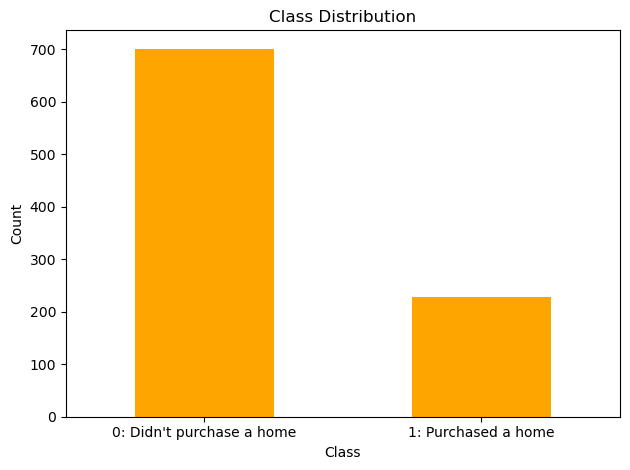

0    701
1    229
Name: home_ownership_class, dtype: int64

0    0.753763
1    0.246237
Name: home_ownership_class, dtype: float64

In [247]:
class_counts = df['home_ownership_class'].value_counts()
class_counts = class_counts.rename({0: "0: Didn't purchase a home",
                                    1: "1: Purchased a home"})

# Plot
class_counts.plot(kind='bar', color='orange')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

display(df['home_ownership_class'].value_counts())
display(df['home_ownership_class'].value_counts(normalize=True))

## Runs: RobustScaler()

In [248]:
scaler = RobustScaler()

In [249]:
t11_adaboost_gs, t11_adaboost_be, t11_adaboost_model_info, t11_adaboost_metrics_df = adaboost_class2(t11, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


Best Hyperparameters: {'classifier__algorithm': 'SAMME', 'classifier__estimator': RandomForestClassifier(random_state=0), 'classifier__n_estimators': 200, 'resampling': RandomOverSampler(random_state=0)}
Best Validation Score (Precision): 0.43833333333333335
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomOverSampler(random_state=0)),
                ('classifier',
                 AdaBoostClassifier(algorithm='SAMME',
                                    estimator=RandomForestClassifier(random_state=0),
                                    n_estimators=200, random_state=0))])
Mean Train Score (Precision) 0.8325433323122564
Std Train Score (Precision) 0.00991512712131218
GridSearchCV Runtime: 12.023531436920166 secs
Run 1 - Random State: 0
Test Precision: 0.23076923076923078
Run 2 - Random State: 1
Test Precision: 0.35714285714285715
Run 3 - Random State: 2
Test Precision: 0.38095238095238093
Run 4 - Random State: 3
Test Precision: 0.47826

In [250]:
t11_dt_gs, t11_dt_be, t11_dt_model_info, t11_dt_metrics_df = dt_class2(t11, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 1728 candidates, totalling 17280 fits



4320 fits failed out of a total of 17280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2366 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 638, in _

Best Hyperparameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 3, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'resampling': TomekLinks()}
Best Validation Score (Precision): 0.475
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()), ('resampling', TomekLinks()),
                ('classifier',
                 DecisionTreeClassifier(max_depth=3, max_features='log2',
                                        random_state=0))])
Mean Train Score (Precision) nan
Std Train Score (Precision) nan
GridSearchCV Runtime: 167.25408935546875 secs
Run 1 - Random State: 0
Test Precision: 0.14285714285714285
Run 2 - Random State: 1
Test Precision: 0.2
Run 3 - Random State: 2
Test Precision: 0.0
Run 4 - Random State: 3
Test Precision: 0.2857142857142857
Run 5 - Random State: 4
Test Precision: 0.5
Ave Test Precision: 0.2257142857142857
Stdev Test Precision: 0.18527420384998255
Ave Test Accuracy: 0.7450643776824035
Stdev

In [251]:
t11_logreg_gs, t11_logreg_be, t11_logreg_model_info, t11_logreg_metrics_df = logreg_class2(t11, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 390 candidates, totalling 3900 fits



650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cholesky', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.35928921568627453
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=0.01, max_iter=1000, random_state=0,
                                    solver='newton-cholesky'))])
Mean Train Score (Precision) nan
Std Train Score (Precision) nan
GridSearchCV Runtime: 77.91486287117004 secs
Run 1 - Random State: 0
Test Precision: 0.26785714285714285
Run 2 - Random State: 1
Test Precision: 0.38095238095238093
Run 3 - Random State: 2
Test Precision: 0.30666666666666664
Run 4 - Random State: 3
Test Precision: 0.25
Run 5 - Random State: 4
Test Precision: 0.34375
Ave Test Precision: 0.30984523809523806
Stdev Test Precision: 0.05375945178722143
Ave Test Accuracy: 0.657510729613

In [252]:
t11_knn_gs, t11_knn_be, t11_knn_model_info, t11_knn_metrics_df = knn_class2(t11, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 600 candidates, totalling 6000 fits


Best Hyperparameters: {'classifier__metric': 'chebyshev', 'classifier__n_neighbors': 14, 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.3909307359307359
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 KNeighborsClassifier(metric='chebyshev', n_neighbors=14))])
Mean Train Score (Precision) 0.5184383443776149
Std Train Score (Precision) 0.020082672907045785
GridSearchCV Runtime: 114.94907021522522 secs
Run 1 - Random State: 0
Test Precision: 0.3
Run 2 - Random State: 1
Test Precision: 0.2916666666666667
Run 3 - Random State: 2
Test Precision: 0.3235294117647059
Run 4 - Random State: 3
Test Precision: 0.4444444444444444
Run 5 - Random State: 4
Test Precision: 0.375
Ave Test Precision: 0.34692810457516343
Stdev Test Precision: 0.06344493714673843
Ave Test Accuracy: 0.7218884120171675
Stdev Test Accuracy: 0.014990771842551919
Ave Test Specific

In [253]:
t11_svm_gs, t11_svm_be, t11_svm_model_info, t11_svm_metrics_df = svm_class2(t11, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 520 candidates, totalling 5200 fits


[LibSVM]Best Hyperparameters: {'classifier__C': 0.1, 'classifier__kernel': 'poly', 'classifier__probability': True, 'resampling': RandomOverSampler(random_state=0)}
Best Validation Score (Precision): 0.5316666666666665
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomOverSampler(random_state=0)),
                ('classifier',
                 SVC(C=0.1, kernel='poly', max_iter=1000, probability=True,
                     random_state=0, verbose=True))])
Mean Train Score (Precision) 0.2920573308146965
Std Train Score (Precision) 0.04376542478232012
GridSearchCV Runtime: 117.25064635276794 secs
[LibSVM]

Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


Run 1 - Random State: 0
Test Precision: 0.2
[LibSVM]Run 2 - Random State: 1
Test Precision: 0.23580786026200873
[LibSVM]

Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


Run 3 - Random State: 2
Test Precision: 0.24675324675324675
[LibSVM]Run 4 - Random State: 3
Test Precision: 0.6666666666666666
[LibSVM]Run 5 - Random State: 4
Test Precision: 0.2222222222222222
Ave Test Precision: 0.3142899991808289
Stdev Test Precision: 0.19775531238946262
Ave Test Accuracy: 0.5467811158798284
Stdev Test Accuracy: 0.27617617239059505
Ave Test Specificity: 0.5875
Ave Test Recall: 0.42105263157894735
Ave Test NPV: 0.706234335839599
Ave Test F1-Score: 0.20962760357921648
Ave Test G-mean: 0.16322546430610407
Ave Runtime: 0.1751741886138916


Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


In [254]:
t11_catboost_gs, t11_catboost_be, t11_catboost_model_info, t11_catboost_metrics_df = catboost_class2(t11, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


Learning rate set to 0.010519
0:	learn: 0.6905500	total: 3.62ms	remaining: 3.62s
1:	learn: 0.6890648	total: 6.55ms	remaining: 3.27s
2:	learn: 0.6866645	total: 9.56ms	remaining: 3.18s
3:	learn: 0.6839312	total: 12.7ms	remaining: 3.16s
4:	learn: 0.6807912	total: 16.2ms	remaining: 3.22s
5:	learn: 0.6778273	total: 19.2ms	remaining: 3.19s
6:	learn: 0.6743650	total: 22.4ms	remaining: 3.17s
7:	learn: 0.6720123	total: 25.9ms	remaining: 3.22s
8:	learn: 0.6701852	total: 28.8ms	remaining: 3.17s
9:	learn: 0.6685285	total: 32ms	remaining: 3.17s
10:	learn: 0.6662708	total: 35.2ms	remaining: 3.16s
11:	learn: 0.6637560	total: 42.3ms	remaining: 3.48s
12:	learn: 0.6615317	total: 46.7ms	remaining: 3.55s
13:	learn: 0.6596167	total: 50ms	remaining: 3.52s
14:	learn: 0.6568968	total: 53ms	remaining: 3.48s
15:	learn: 0.6543288	total: 55.9ms	remaining: 3.44s
16:	learn: 0.6523656	total: 58.9ms	remaining: 3.4s
17:	learn: 0.6497679	total: 61.8ms	remaining: 3.37s
18:	learn: 0.6477678	total: 64.6ms	remaining: 3.33s

In [255]:
t11_lgbm_gs, t11_lgbm_be, t11_lgbm_model_info, t11_lgbm_metrics_df = lgbm_class2(t11, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


[LightGBM] [Info] Number of positive: 527, number of negative: 525
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9568
[LightGBM] [Info] Number of data points in the train set: 1052, number of used features: 90
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500951 -> initscore=0.003802
[LightGBM] [Info] Start training from score 0.003802
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [256]:
t11_gbm_gs, t11_gbm_be, t11_gbm_model_info, t11_gbm_metrics_df = gbm_class2(t11, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


Best Hyperparameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 2, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200, 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.4353818403818404
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 GradientBoostingClassifier(max_depth=2, min_samples_leaf=3,
                                            n_estimators=200,
                                            random_state=0))])
Mean Train Score (Precision) 0.8033609130062171
Std Train Score (Precision) 0.014343423482245137
GridSearchCV Runtime: 180.21633076667786 secs
Run 1 - Random State: 0
Test Precision: 0.28125
Run 2 - Random State: 1
Test Precision: 0.47058823529411764
Run 3 - Random State: 2
Test Precision: 0.5
Run 4 - Random State: 3
Test Precision: 0.5806451612903226
Run 5 - Random S

In [257]:
t11_rf_gs, t11_rf_be, t11_rf_model_info, t11_rf_metrics_df = rf_class2(t11, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 480 candidates, totalling 4800 fits


Best Hyperparameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300, 'classifier__oob_score': True, 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.37931704260651633
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 RandomForestClassifier(max_depth=3, min_samples_leaf=2,
                                        n_estimators=300, oob_score=True,
                                        random_state=0))])
Mean Train Score (Precision) 0.4551970347544455
Std Train Score (Precision) 0.021226479609525627
GridSearchCV Runtime: 289.4492905139923 secs
Run 1 - Random State: 0
Test Precision: 0.2777777777777778
Run 2 - Random State: 1
Test Precision: 0.40350877192982454
Run 3 - Random State: 2
Test Precision: 0.38666666666666666
Run 4 - 

In [258]:
t11_xgb_gs, t11_xgb_be, t11_xgb_model_info, t11_xgb_metrics_df = xgb_class2(t11, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

Fitting 10 folds for each of 540 candidates, totalling 5400 fits


Best Hyperparameters: {'classifier__grow_policy': 'depthwise', 'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__max_leaves': 10, 'classifier__n_estimators': 200, 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.4702211187505306
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints=None, learning_rate

In [259]:
model_vars = ['knn', 'svm', 'logreg', 'dt', 'rf', 'gbm', 'lgbm', 'xgb', 'adaboost', 'catboost']

var_df = {
    'Classifier model': [
        'k-Nearest Neighbors', 'SVM Classifier',
        'Logistic Regression', 'Decision Tree', 'Random Forest',
        'Gradient Boosting Machine (GBM)',
        'LightGBM', 'Extreme Gradient Boosting (XGBoost)',
        'AdaBoost', 'CatBoost'
    ],
    'Best Hyperparameters': [],
    'Average Val Precision': [],
    'Average Train Precision': [],
    'Stdev Train Precision': [],
    'Average Test Precision': [],
    'Stdev Test Precision': [],
    'Average Test Accuracy': [],
    'Stdev Test Accuracy': [],
    'Average Runtime': [],
    'Average Test Specificity': [],
    'Average Test Recall': [],
    'Average Test NPV': [],
    'Average Test F1-score': [],
    'Average Test G-mean': []
}

prefix = 't11_'
for name in model_vars:
    var_df['Best Hyperparameters'].append(globals()[prefix+name+'_model_info']['best_params'])
    var_df['Average Val Precision'].append(globals()[prefix+name+'_model_info']['best_cv_score'])
    var_df['Average Train Precision'].append(globals()[prefix+name+'_model_info']['mean_train_score'])
    var_df['Stdev Train Precision'].append(globals()[prefix+name+'_model_info']['std_train_score'])
    var_df['Average Test Precision'].append(globals()[prefix+name+'_model_info']['average_test_precision'])
    var_df['Stdev Test Precision'].append(globals()[prefix+name+'_model_info']['stdev_test_precision'])
    var_df['Average Test Accuracy'].append(globals()[prefix+name+'_model_info']['average_test_accuracy'])
    var_df['Stdev Test Accuracy'].append(globals()[prefix+name+'_model_info']['stdev_test_accuracy'])
    var_df['Average Runtime'].append(globals()[prefix+name+'_model_info']['average_runtime'])
    var_df['Average Test Specificity'].append(globals()[prefix+name+'_model_info']['average_test_specificity'])
    var_df['Average Test Recall'].append(globals()[prefix+name+'_model_info']['average_test_recall'])
    var_df['Average Test NPV'].append(globals()[prefix+name+'_model_info']['average_test_npv'])
    var_df['Average Test F1-score'].append(globals()[prefix+name+'_model_info']['average_test_f1_score'])
    var_df['Average Test G-mean'].append(globals()[prefix+name+'_model_info']['average_test_g_mean'])

# display(t11_model_summ)
t11_summ = pd.DataFrame(var_df)

# columns_to_exclude = ['Best Hyperparameters', 'Average Runtime']
# selected_columns = [col for col in ho_t1__summ.columns if col not in columns_to_exclude]
# ho_t1__summ[selected_columns]

t11_summ[[
    'Classifier model', 'Average Test Precision', 'Stdev Test Precision',
    'Average Val Precision', 'Average Train Precision', 'Stdev Train Precision',
    'Average Test Accuracy', 'Stdev Test Accuracy', 'Average Test Specificity',
    'Average Test Recall', 'Average Test NPV', 'Average Test F1-score', 'Average Test G-mean'
]].sort_values(by='Average Test Precision', ascending=False)

Classifier model  Average Test Precision  \
6                             LightGBM                0.459034   
9                             CatBoost                0.455835   
5      Gradient Boosting Machine (GBM)                0.442172   
8                             AdaBoost                0.400536   
7  Extreme Gradient Boosting (XGBoost)                0.385426   
4                        Random Forest                0.371504   
0                  k-Nearest Neighbors                0.346928   
1                       SVM Classifier                0.314290   
2                  Logistic Regression                0.309845   
3                        Decision Tree                0.225714   

   Stdev Test Precision  Average Val Precision  Average Train Precision  \
6              0.153416               0.454396                 0.653376   
9              0.056386               0.450198                 0.841211   
5              0.115425               0.435382                 0.803361   
8              0.123652               0.438333                 0.832543   
7              0.075981               0.470221                 0.757858   
4              0.055665               0.379317                 0.455197   
0              0.063445               0.390931                 0.518438   
1              0.197755               0.531667                 0.292057   
2              0.053759               0.359289                      NaN   
3              0.185274               0.475000                      NaN   

   Stdev Train Precision  Average Test Accuracy  Stdev Test Accuracy  \
6               0.020688               0.743348             0.034920   
9               0.009342               0.741631             0.018056   
5               0.014343               0.738197             0.032260   
8               0.009915               0.742489             0.015174   
7               0.014977               0.723605             0.022832   
4               0.021226               0.693562             0.026905   
0               0.020083               0.721888             0.014991   
1               0.043765               0.546781             0.276176   
2                    NaN               0.657511             0.023390   
3                    NaN               0.745064             0.008366   

   Average Test Specificity  Average Test Recall  Average Test NPV  \
6                  0.915909             0.210526          0.781724   
9                  0.896591             0.263158          0.789730   
5                  0.888636             0.273684          0.790845   
8                  0.940909             0.129825          0.769664   
7                  0.893182             0.200000          0.775112   
4                  0.798864             0.368421          0.796868   
0                  0.904545             0.157895          0.768412   
1                  0.587500             0.421053          0.706234   
2                  0.761364             0.336842          0.780612   
3                  0.980682             0.017544          0.755024   

   Average Test F1-score  Average Test G-mean  
6               0.286651             0.435189  
9               0.333044             0.485548  
5               0.337020             0.488994  
8               0.194671             0.341024  
7               0.261183             0.421144  
4               0.367159             0.538004  
0               0.215676             0.374568  
1               0.209628             0.163225  
2               0.321236             0.501256  
3               0.031981             0.115566

In [260]:
best_scores_models = {
    'Best Score': [],
    'Best Model': []
}

indices = [
    'Highest Test Accuracy',
    'Highest Test G-mean',
    'Highest Test Recall',
    'Highest Test Precision',
    'Highest Test Specificity',
    'Highest Test F1-score'
]

# Corresponding column names in your original dataframe
columns = [
    'Average Test Accuracy',
    'Average Test G-mean',
    'Average Test Recall',
    'Average Test Precision',
    'Average Test Specificity',
    'Average Test F1-score'
]

df = t11_summ
# Finding the best model for each metric
for col in columns:
    best_score = df[col].max()
    best_model = df.loc[df[col] == best_score, 'Classifier model'].values[0]
    
    best_scores_models['Best Score'].append(best_score)
    best_scores_models['Best Model'].append(best_model)

# Creating the new dataframe
best_df = pd.DataFrame(best_scores_models, index=indices)

# Displaying the new dataframe
best_df

Best Score      Best Model
Highest Test Accuracy       0.745064   Decision Tree
Highest Test G-mean         0.538004   Random Forest
Highest Test Recall         0.421053  SVM Classifier
Highest Test Precision      0.459034        LightGBM
Highest Test Specificity    0.980682   Decision Tree
Highest Test F1-score       0.367159   Random Forest